In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/predictive_distribution


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np
import jsons

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration, BaseConfiguration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentDataNAS, ExperimentDataNE
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimatorGenome
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions, plot_metrics_by_quantile
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions
from deep_learning.probabilistic.deser import ProbabilisticFeedForwardDeser
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimatorNetwork 
from neat.analysis.experiment_data import ExperimentData
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_pca import plot_dimensionality_reduction
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.plotting.plot_prediction_probabilities import plot_prediction_probabilities
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [62]:
PROJECT = 'neuro-evolution'
ALGORITHM_VERSION = 'bayes-neat'
DATASET = 'iris'

# correlation_ids = [f'neat_ft_1_{DATASET}', f'bayesian_neat_ft_1_{DATASET}']
correlation_ids = [f'bayesian_neat_ft_10_{DATASET}'] 

In [63]:
# from IPython.core.debugger import set_trace
# set_trace()
experiment_data_ne = ExperimentDataNE(correlation_ids=correlation_ids, dataset_name=DATASET, n_samples=1000,
                                 project=PROJECT, algorithm_version=ALGORITHM_VERSION,
                                keep_top=1.0)\
                    .process_data()
data_ne = experiment_data_ne.get_experiment_data()
data_ne = data_ne.loc[data_ne['noise'] == 0.0]
data_ne['version'] = 'Bayesian Neuro-Evolution'
data_ne.head()

###########
CORRELATION ID: bayesian_neat_ft_10_iris
Fitness of best individual: -0.27851444482803345
Train percentage: 0.75
Random state: 0
Sum Train: -1.554347038269043
Training: 112. Testing: 38
Fitness of best individual: -0.16411148011684418
Train percentage: 0.75
Random state: 89
Sum Train: 19.857336044311523
Training: 112. Testing: 38
Fitness of best individual: -0.4013615846633911
Train percentage: 0.75
Random state: 36
Sum Train: -14.474637985229492
Training: 112. Testing: 38
Fitness of best individual: -0.06369274854660034
Train percentage: 0.75
Random state: 91
Sum Train: -6.405988693237305
Training: 112. Testing: 38
Fitness of best individual: -0.4058321416378021
Train percentage: 0.75
Random state: 59
Sum Train: -24.931804656982422
Training: 112. Testing: 38
Fitness of best individual: -0.39162275195121765
Train percentage: 0.75
Random state: 33
Sum Train: -29.462095260620117
Training: 112. Testing: 38
Fitness of best individual: -0.06673821806907654
Train percentage: 0.75

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1,version
0,bayesian_neat_ft_10_iris,4ae9eb30-077c-4293-af7b-5d63196f7857,0.75,0.0,True,0.0001,0.063693,0.042652,0:19:52.962718,normal,146,24,49,0.877698,99.657895,0.996579,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,910ac450-b4e1-46b8-9733-a7dffbf5014c,0.75,0.0,True,0.0001,0.066738,0.057213,0:07:27.614681,normal,70,11,24,0.626982,99.363158,0.993633,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,dc5ae0ea-6be7-4f8c-84de-536e8a8463e7,0.75,0.0,True,0.0001,0.082832,0.115599,0:14:26.026158,normal,104,17,35,0.780549,95.234211,0.952962,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,dd3325c5-dea9-4c2f-944c-73cfc1be42c3,0.75,0.0,True,0.0001,0.063728,0.096862,0:09:38.049719,normal,96,15,33,0.689483,97.289474,0.972896,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,eca515a0-b821-482d-bb9c-2f86ff9443fc,0.75,0.0,True,0.0001,0.044711,0.319815,0:09:45.733006,normal,150,24,51,0.779104,92.368421,0.923998,Bayesian Neuro-Evolution


In [64]:
data_ne

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1,version
0,bayesian_neat_ft_10_iris,4ae9eb30-077c-4293-af7b-5d63196f7857,0.75,0.0,True,0.0001,0.063693,0.042652,0:19:52.962718,normal,146,24,49,0.877698,99.657895,0.996579,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,910ac450-b4e1-46b8-9733-a7dffbf5014c,0.75,0.0,True,0.0001,0.066738,0.057213,0:07:27.614681,normal,70,11,24,0.626982,99.363158,0.993633,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,dc5ae0ea-6be7-4f8c-84de-536e8a8463e7,0.75,0.0,True,0.0001,0.082832,0.115599,0:14:26.026158,normal,104,17,35,0.780549,95.234211,0.952962,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,dd3325c5-dea9-4c2f-944c-73cfc1be42c3,0.75,0.0,True,0.0001,0.063728,0.096862,0:09:38.049719,normal,96,15,33,0.689483,97.289474,0.972896,Bayesian Neuro-Evolution
0,bayesian_neat_ft_10_iris,eca515a0-b821-482d-bb9c-2f86ff9443fc,0.75,0.0,True,0.0001,0.044711,0.319815,0:09:45.733006,normal,150,24,51,0.779104,92.368421,0.923998,Bayesian Neuro-Evolution


# Get NAS

In [50]:
project_nas='nas'
algorithm_version_nas ='nas'
# correlation_ids_nas = ['nas_v1']
correlation_ids_nas = ['nas_v1_test']

experiment_data_nas = ExperimentDataNAS(correlation_ids=correlation_ids_nas, dataset_name=DATASET, n_samples=1000,
                                    project=project_nas, algorithm_version=algorithm_version_nas,
                                    keep_top=1.0)
experiment_data_nas.process_data()
data_nas = experiment_data_nas.experiment_data
data_nas['version'] = 'NAS'
data_nas.head(1)

###########
CORRELATION ID: nas_v1_test


,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,duration,end_condition,n_parameters,n_nodes,n_connections,f1,accuracy,version
0,nas_v1_test,5eee7c05-8f2a-463e-b911-48588af38580,0.75,0.0,True,0.000001,0:17:01.822301,normal,134,11,56,0.957094,95.710526,NAS


# Combine data from Both Algorithm Executions

In [65]:
data = pd.concat([data_ne, data_nas])
data.dropna(axis=1, inplace=True)
data.drop(columns=['correlation_id' ], inplace=True)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,accuracy,beta,duration,end_condition,execution_id,f1,is_bayesian,n_connections,n_nodes,n_parameters,noise,train_percentage,version
0,99.657895,0.000100,0:19:52.962718,normal,4ae9eb30-077c-4293-af7b-5d63196f7857,0.996579,True,49,24,146,0.0,0.75,Bayesian Neuro-Evolution
0,99.363158,0.000100,0:07:27.614681,normal,910ac450-b4e1-46b8-9733-a7dffbf5014c,0.993633,True,24,11,70,0.0,0.75,Bayesian Neuro-Evolution
0,95.234211,0.000100,0:14:26.026158,normal,dc5ae0ea-6be7-4f8c-84de-536e8a8463e7,0.952962,True,35,17,104,0.0,0.75,Bayesian Neuro-Evolution
0,97.289474,0.000100,0:09:38.049719,normal,dd3325c5-dea9-4c2f-944c-73cfc1be42c3,0.972896,True,33,15,96,0.0,0.75,Bayesian Neuro-Evolution
0,92.368421,0.000100,0:09:45.733006,normal,eca515a0-b821-482d-bb9c-2f86ff9443fc,0.923998,True,51,24,150,0.0,0.75,Bayesian Neuro-Evolution
0,95.710526,0.000001,0:17:01.822301,normal,5eee7c05-8f2a-463e-b911-48588af38580,0.957094,True,56,11,134,0.0,0.75,NAS
0,95.763158,0.000001,0:00:42.249145,normal,7158952b-49b1-496e-9a10-27f30f7c082c,0.957458,True,70,13,166,0.0,0.75,NAS
0,96.631579,0.000001,0:00:42.127244,normal,7aba913e-7d4d-4611-be93-9549c2d0389e,0.966260,True,70,13,166,0.0,0.75,NAS
0,85.526316,0.000001,0:00:02.150157,normal,8828224f-36ca-4c98-a449-6578d3b086db,0.856110,True,70,13,166,0.0,0.75,NAS
0,69.105263,0.000001,0:00:02.163356,normal,a9f7e2d7-cd52-4333-87e2-366639dc55b1,0.696686,True,70,13,166,0.0,0.75,NAS


In [66]:
# get best executions for each version
best_executions = data.groupby('version').apply(lambda x: x.sort_values('f1', ascending=False).head(1)['execution_id'].values[0]).reset_index().rename(columns={0: 'execution_id'})
best_executions

,version,execution_id
0,Bayesian Neuro-Evolution,4ae9eb30-077c-4293-af7b-5d63196f7857
1,NAS,7aba913e-7d4d-4611-be93-9549c2d0389e


In [72]:
def _get_estimator_ne(experiment_data: ExperimentDataNE, execution_id, testing=True, dataset_random_state=42):
    genome = experiment_data.best_genomes[execution_id]
    config = experiment_data.configurations[execution_id]
    config.dataset_random_state = dataset_random_state
    estimator = PredictionDistributionEstimatorGenome(genome, config=config, testing=testing, n_samples=1000)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile()
    return estimator


def _get_estimator_nas(experiment_data: ExperimentDataNAS, execution_id, testing=True, dataset_random_state=42):
    report = experiment_data.reports[execution_id]
    config = jsons.load(report.configuration, BaseConfiguration)
    config.dataset_random_state = dataset_random_state
    network = ProbabilisticFeedForwardDeser.from_dict(report.best_network)
    
    estimator = PredictionDistributionEstimatorNetwork(network, config=config, testing=testing, n_samples=1000)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile()
    return estimator

In [73]:
testing=True
estimator_nas = _get_estimator_nas(experiment_data=experiment_data_nas, execution_id='7aba913e-7d4d-4611-be93-9549c2d0389e', 
                                   testing=testing, dataset_random_state=42)
estimator_ne = _get_estimator_ne(experiment_data=experiment_data_ne, execution_id='4ae9eb30-077c-4293-af7b-5d63196f7857', 
                                   testing=testing, dataset_random_state=42)

Sum Train: -0.8510899543762207
Training: 112. Testing: 38
Sum Train: -0.8510899543762207
Training: 112. Testing: 38


###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.07606449723243713


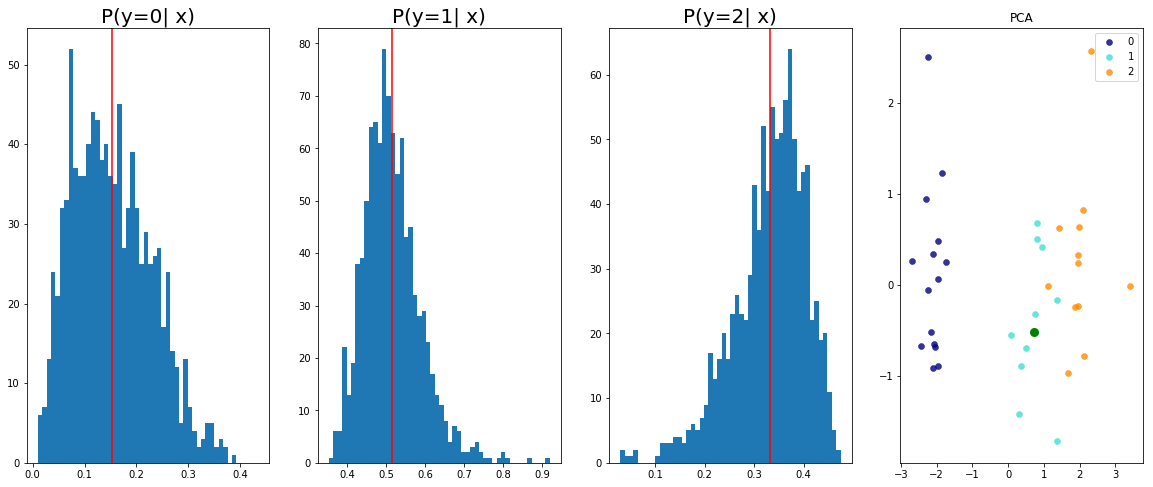

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.029446322470903397


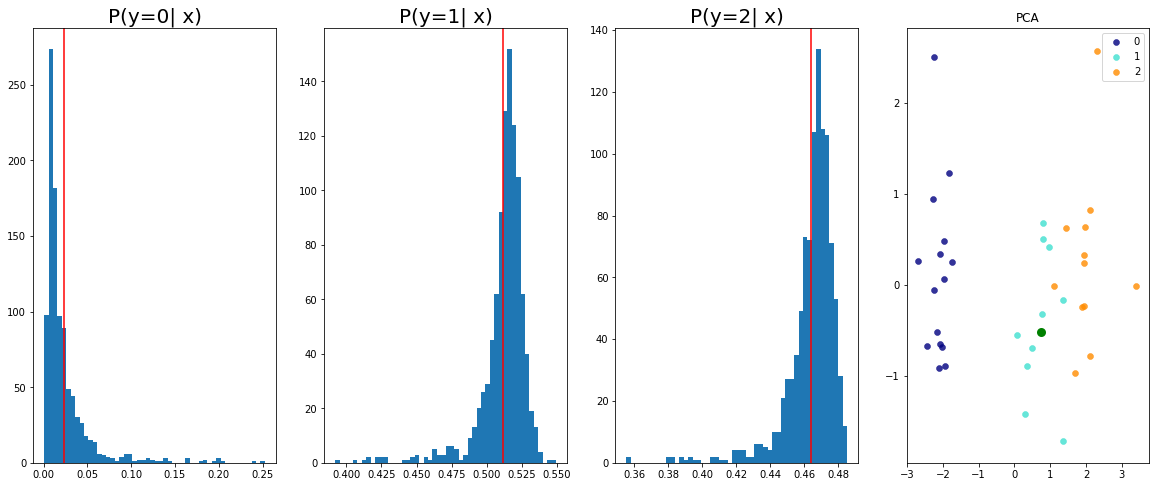

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.06966995447874069


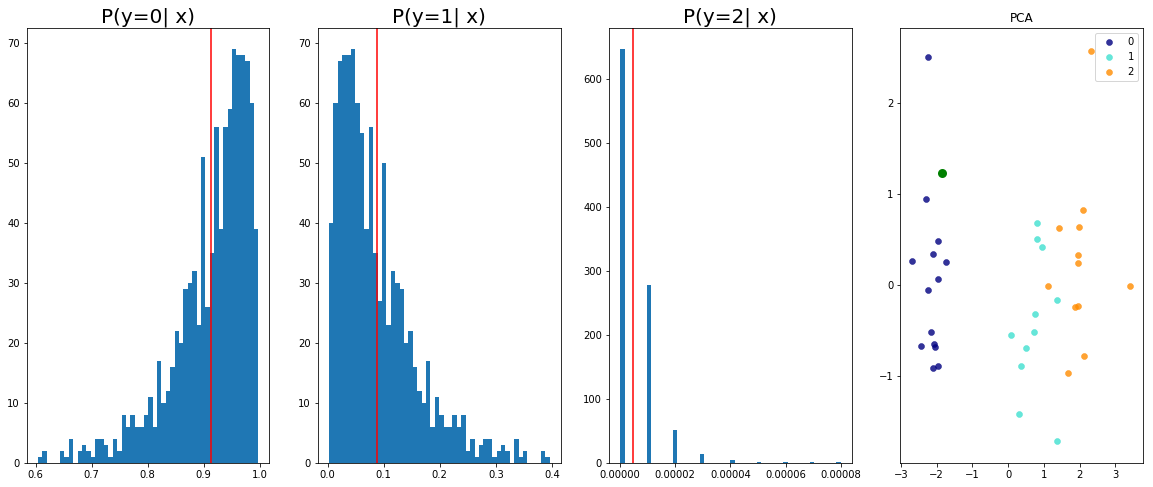

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.000744011253118515


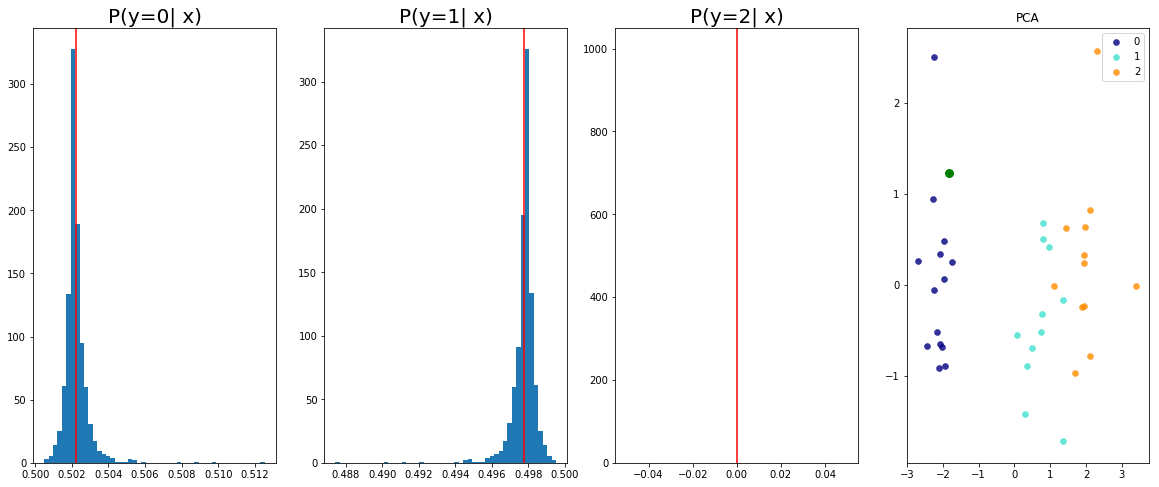

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.026059215888381004


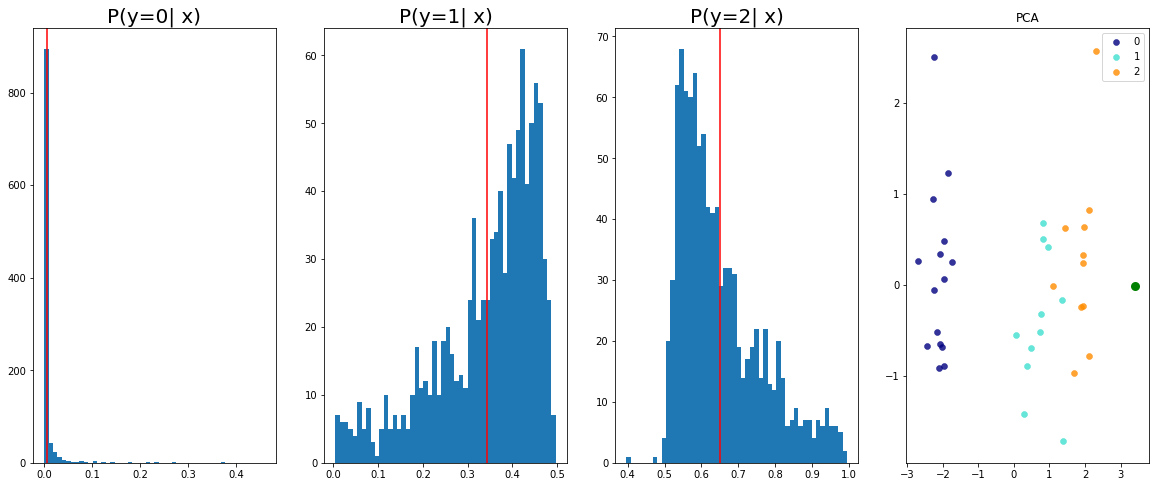

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 3.663482129923068e-05


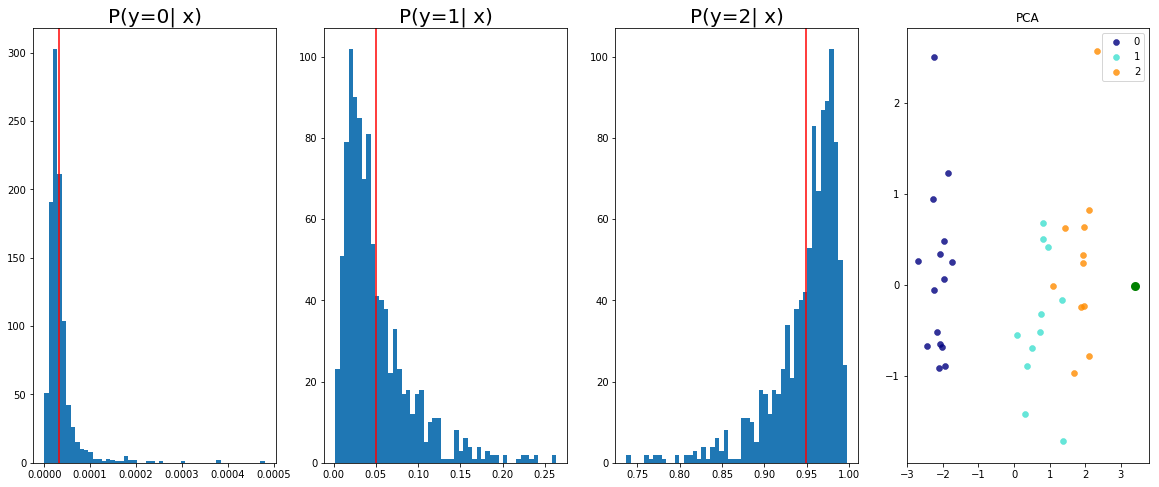

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.0636027380824089


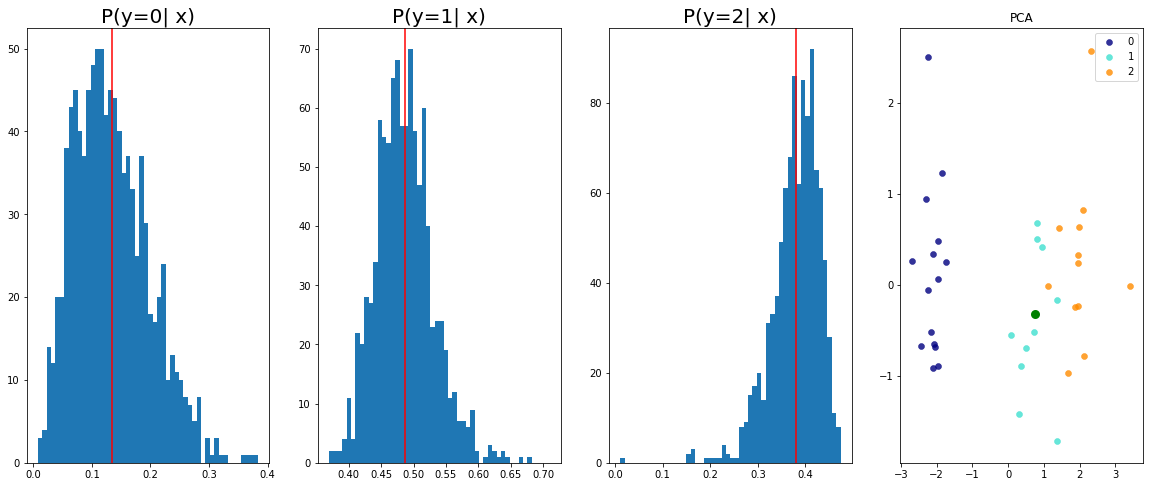

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.013677552342414856


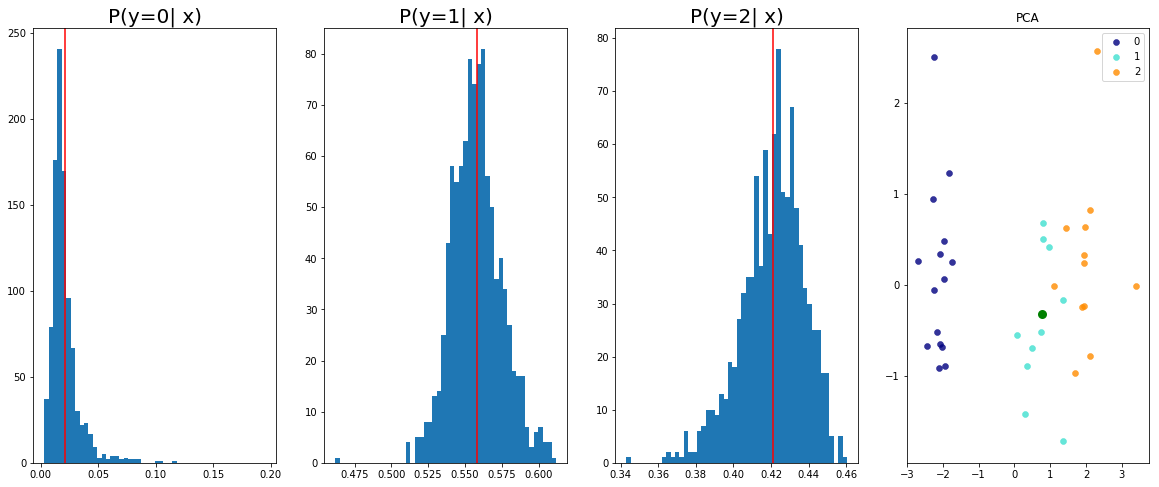

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.13437463343143463


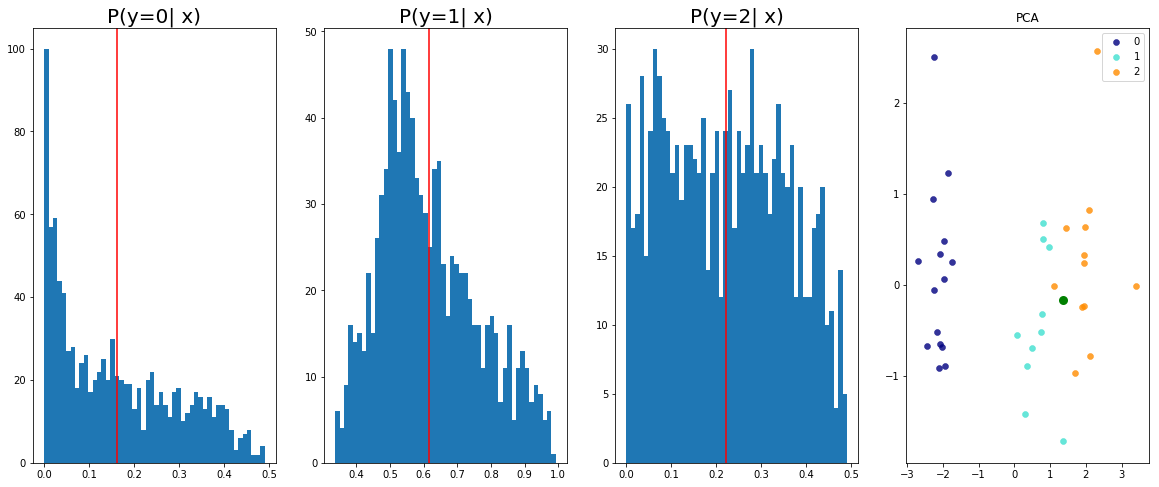

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.008684132248163223


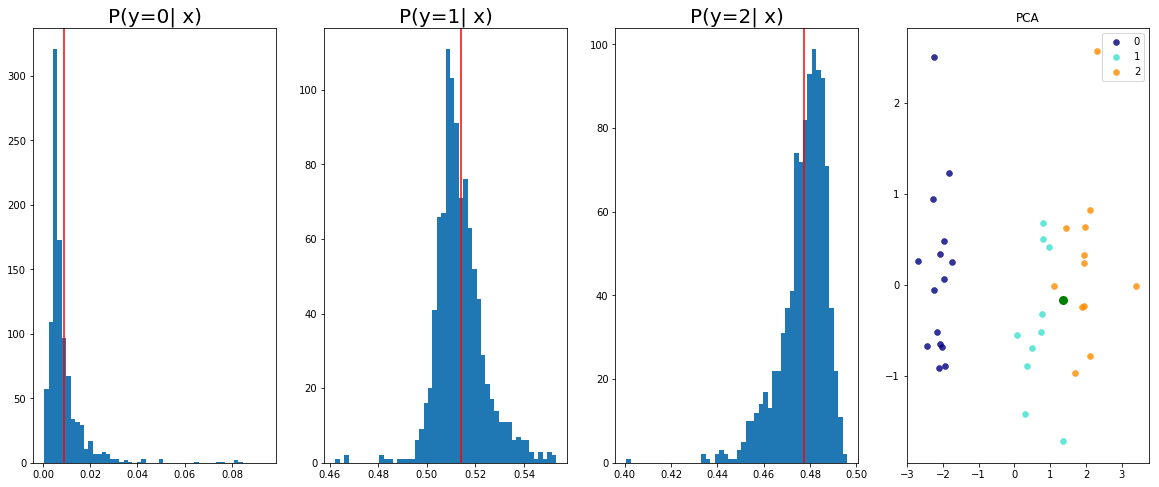

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.07031890749931335


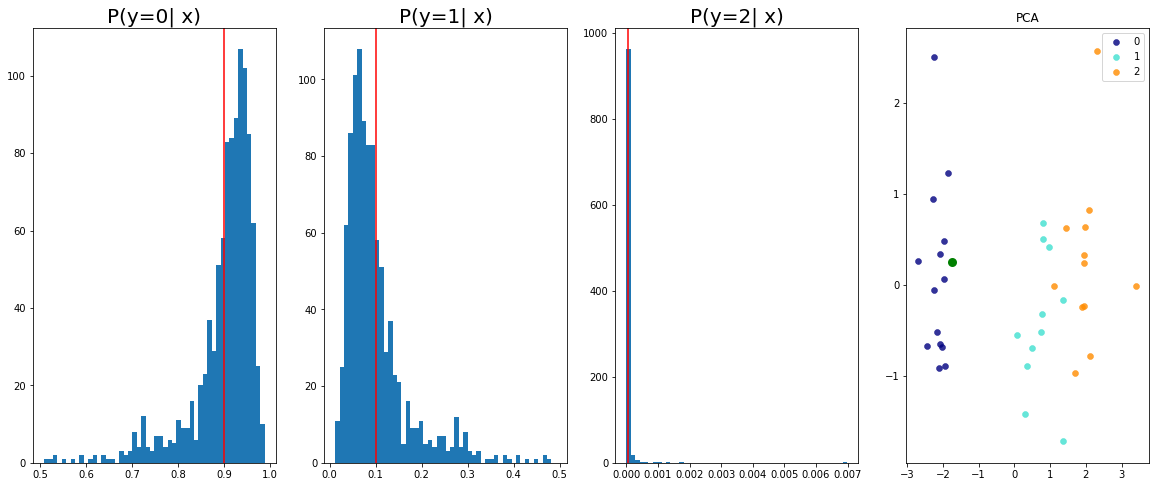

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0007219312246888876


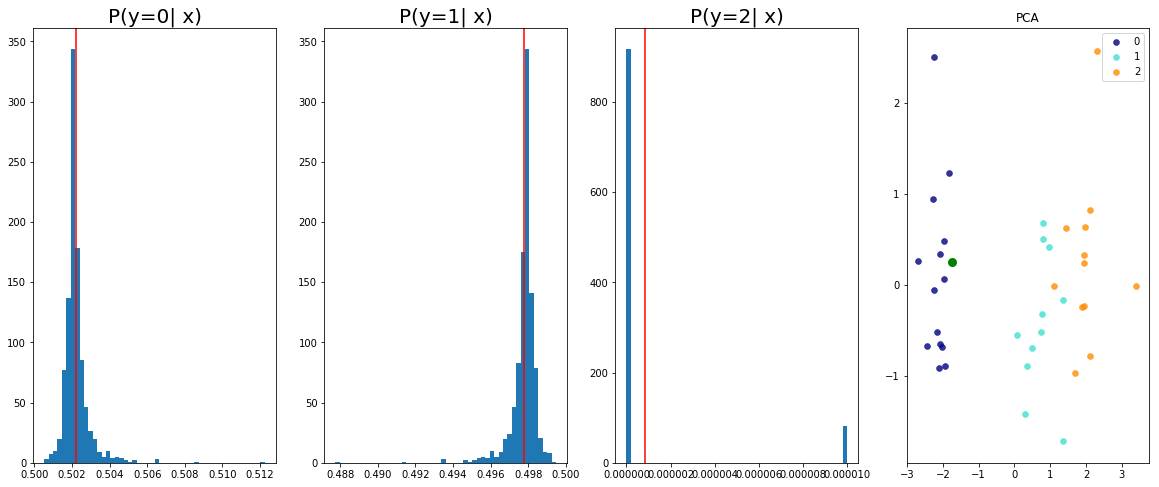

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.10160984843969345


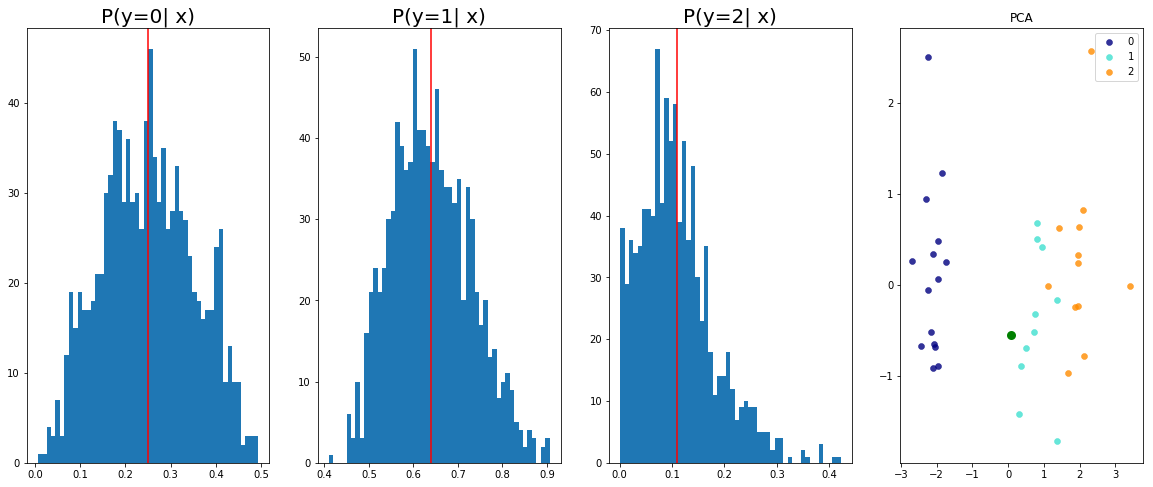

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.07843800634145737


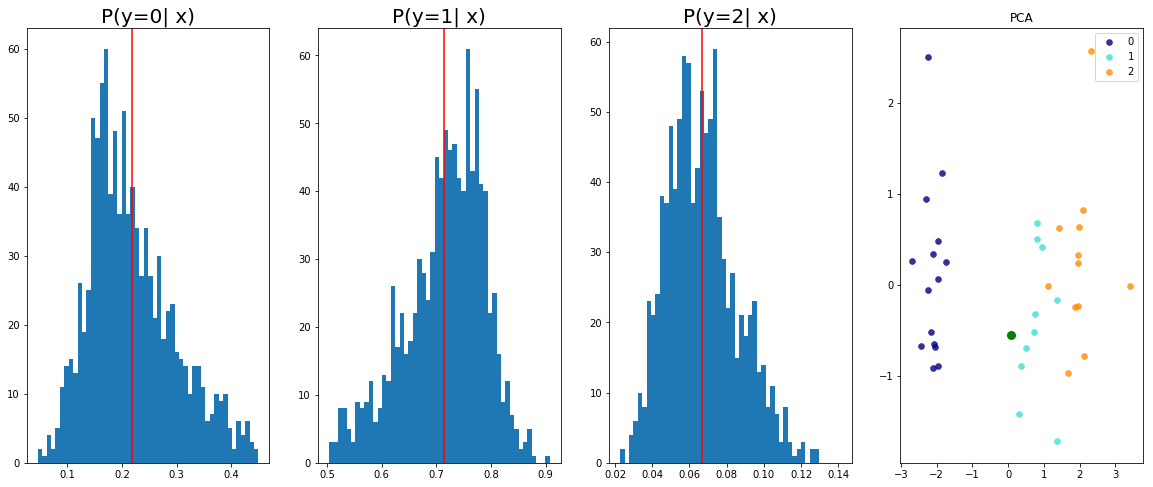

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.0787486582994461


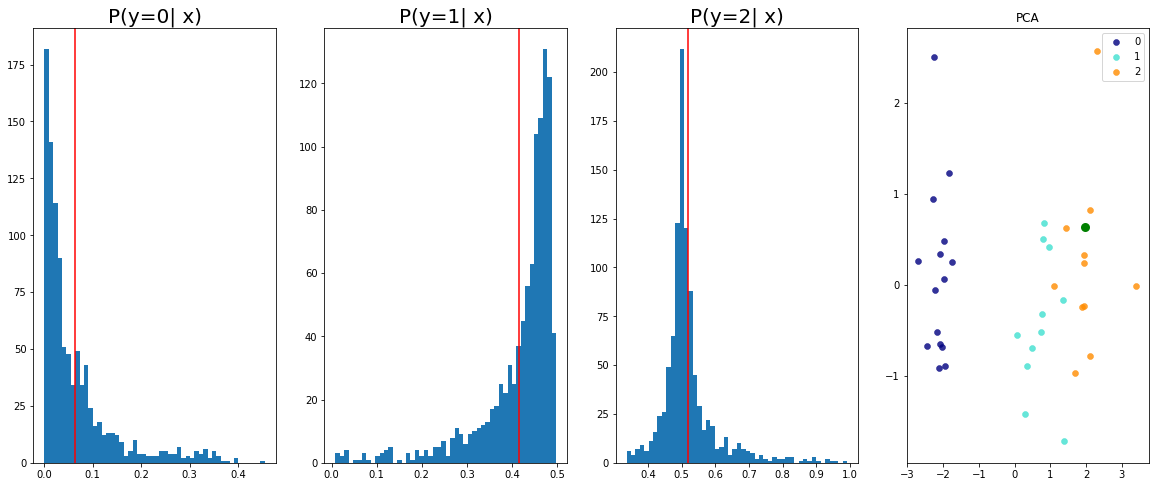

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.006420892663300037


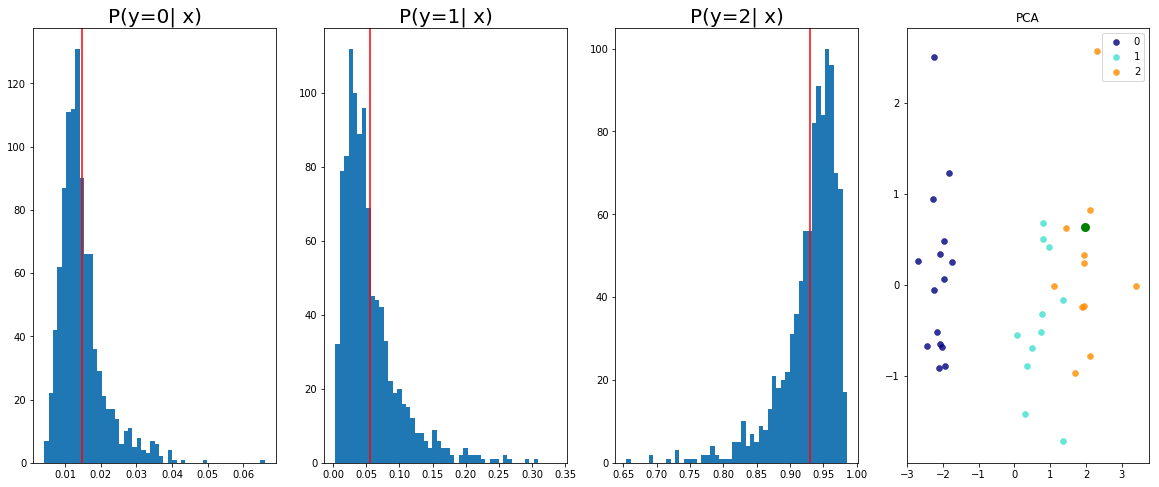

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.06948141008615494


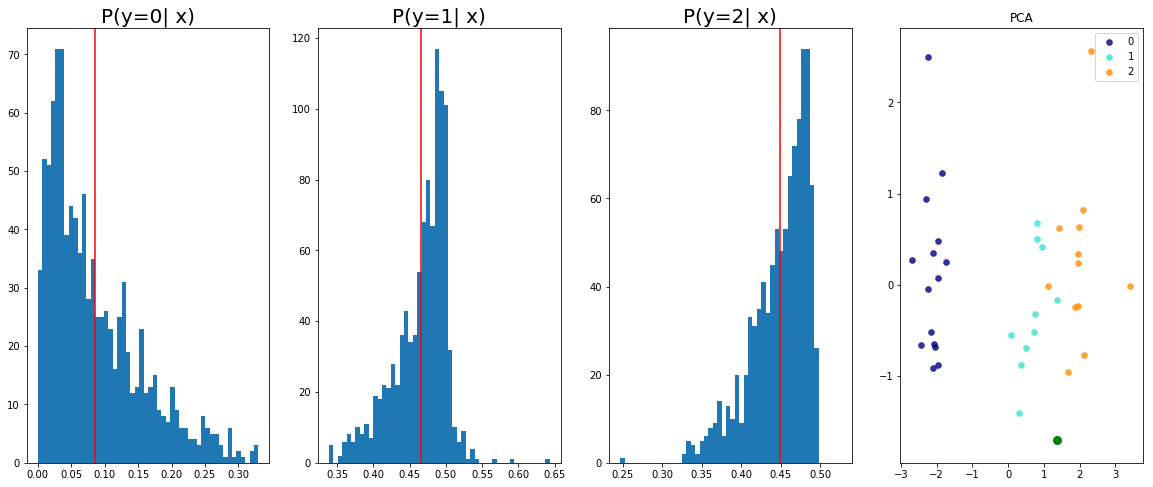

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.005981663707643747


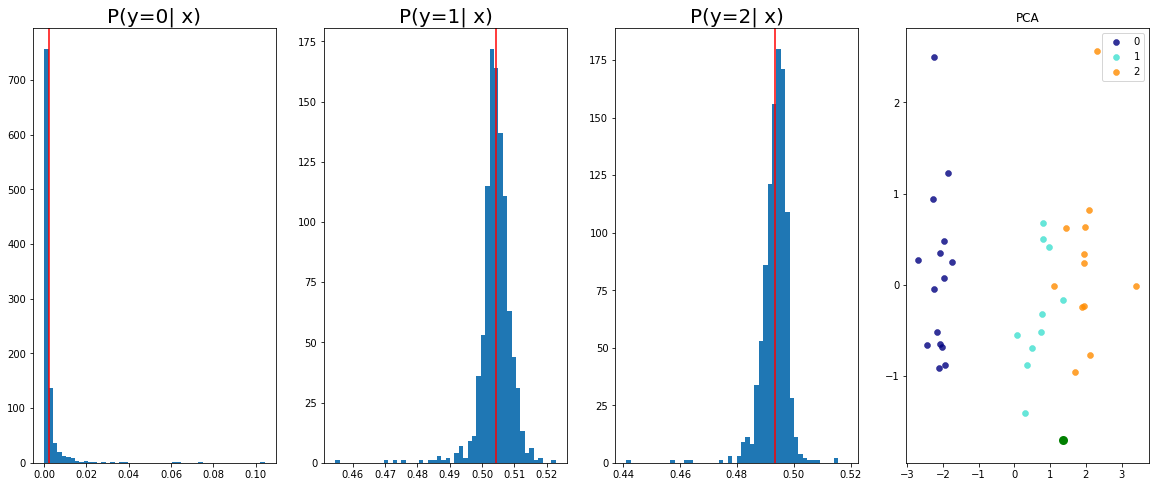

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.09491782635450363


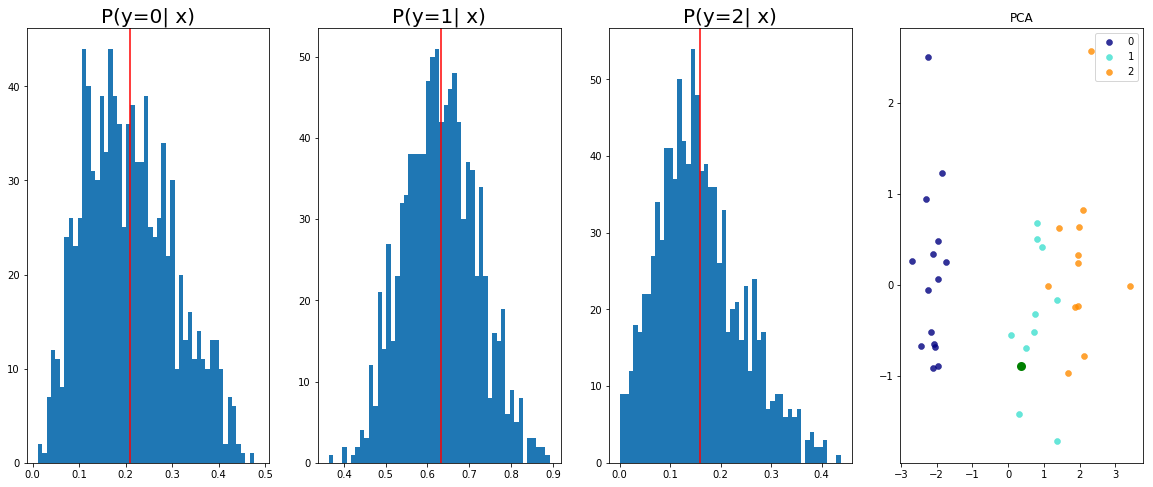

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.06976301968097687


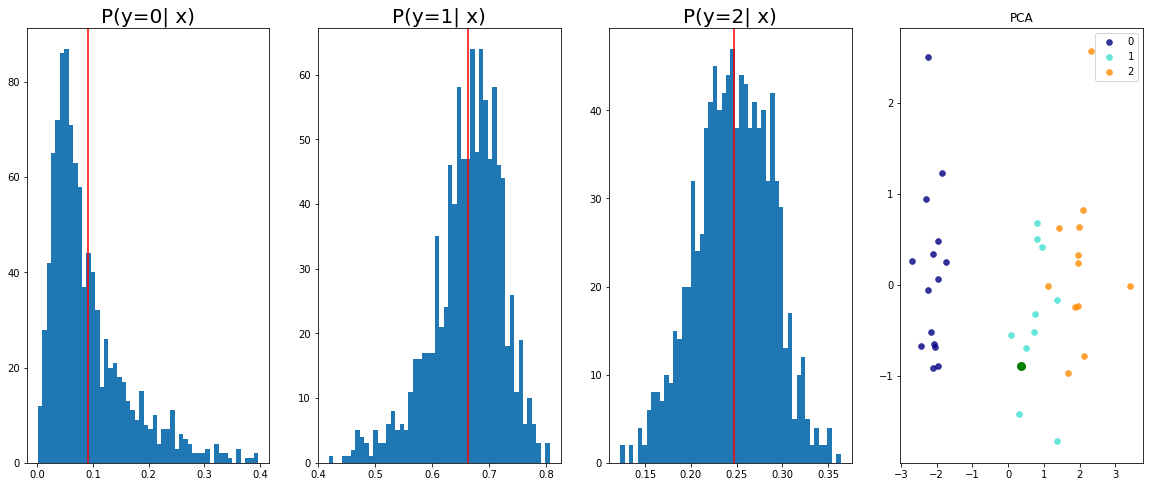

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.0621376670897007


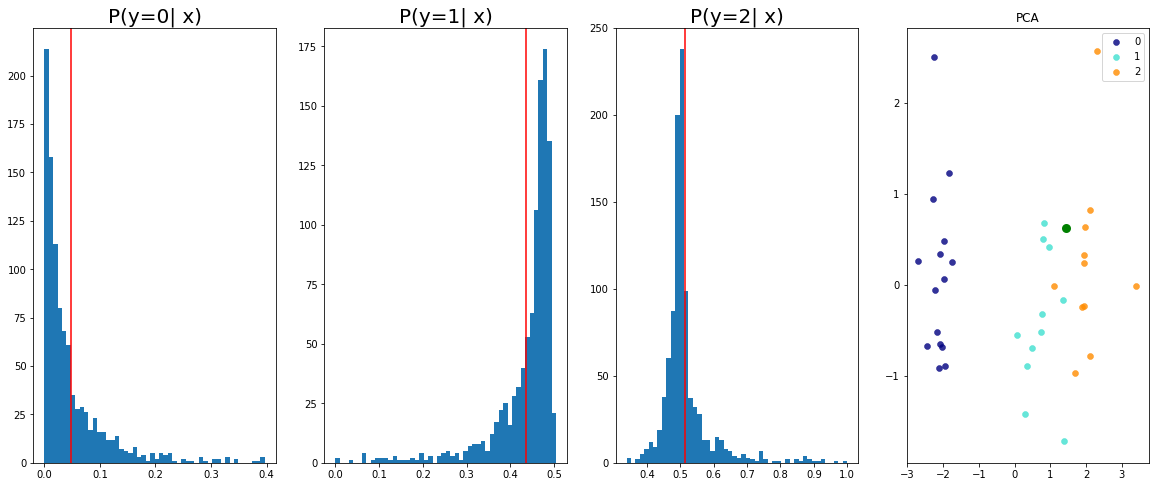

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.012225514277815819


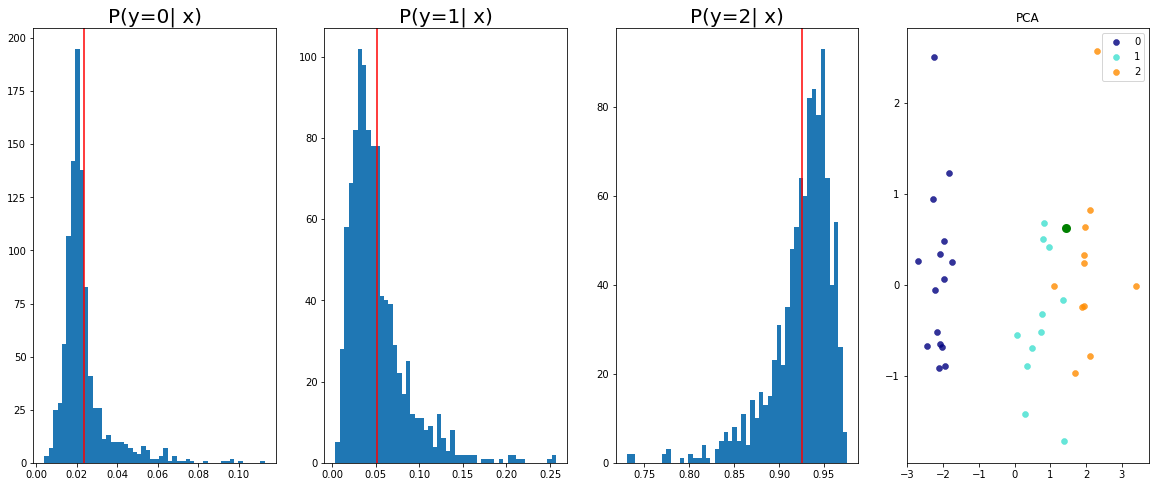

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.11068721860647202


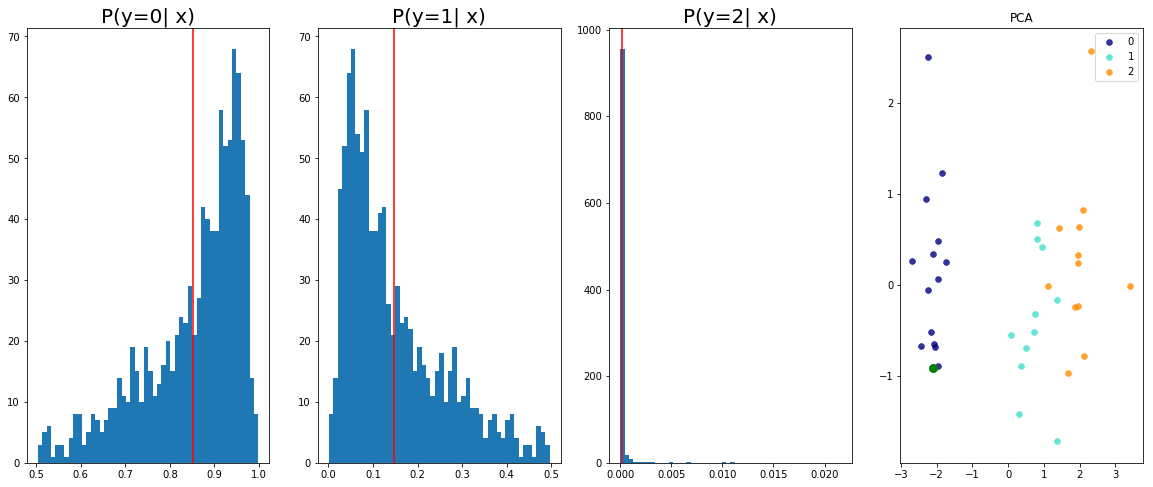

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0008059085230343044


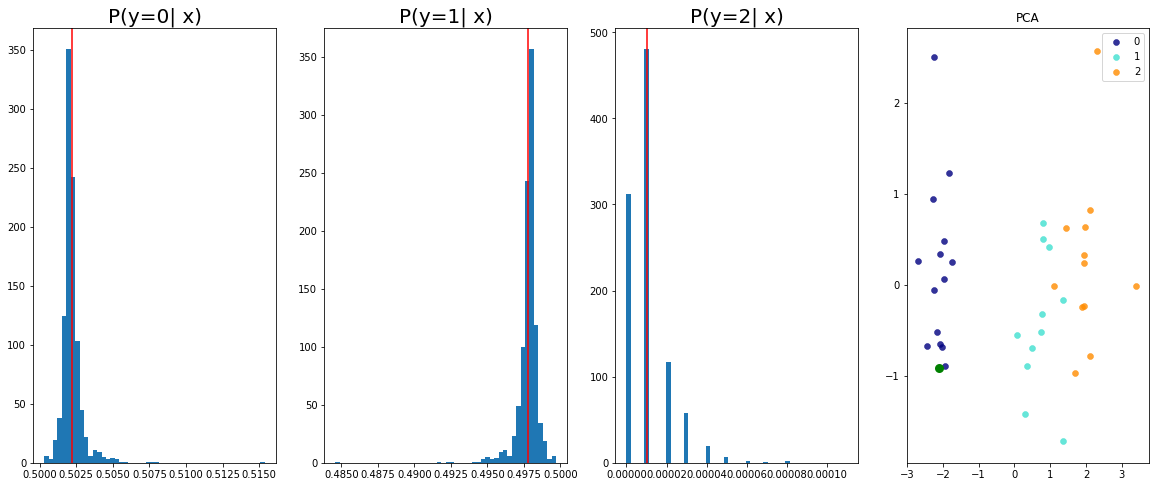

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.08597570657730103


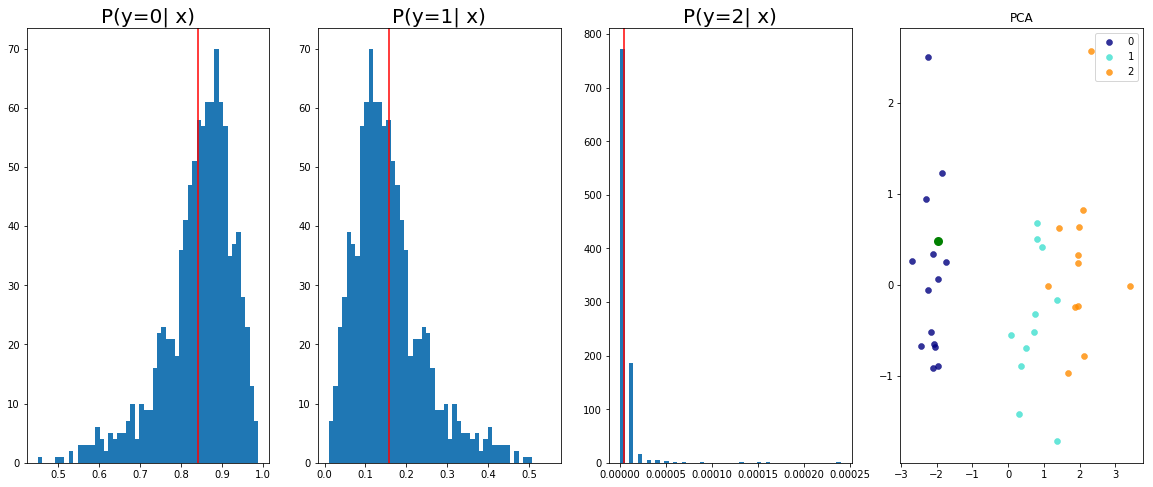

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.000823411566670984


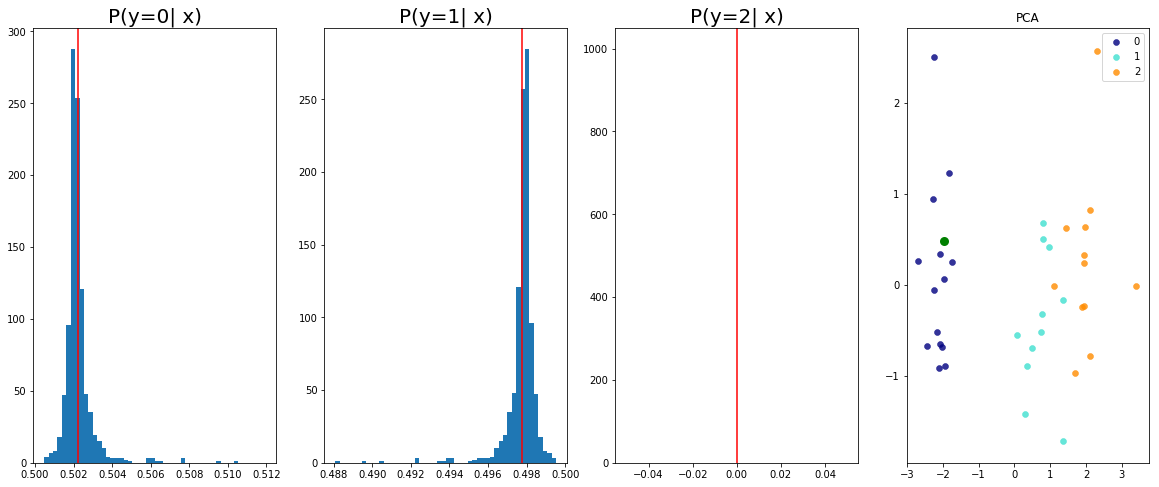

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.10548648983240128


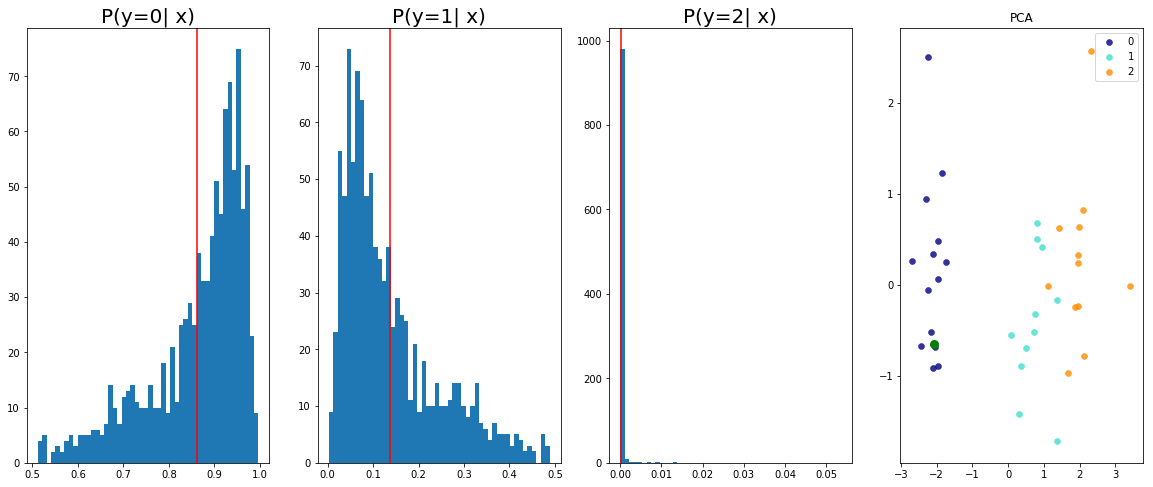

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0008908522431738675


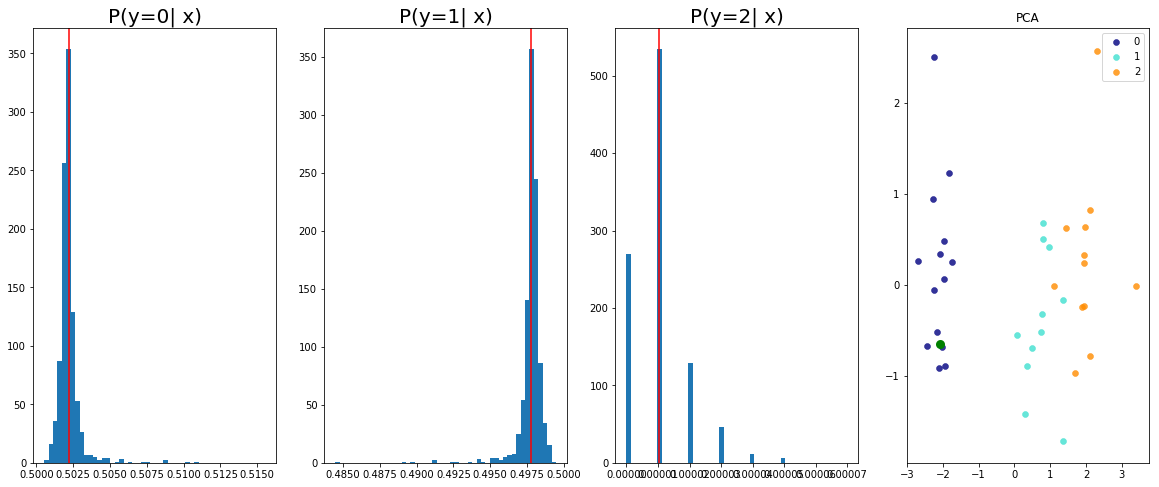

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.0749504417181015


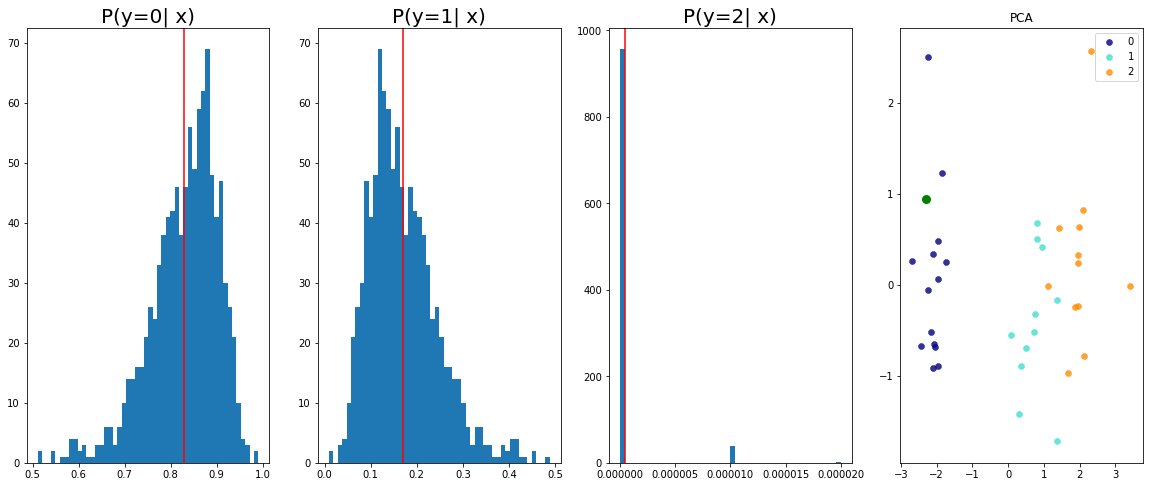

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0009093452244997025


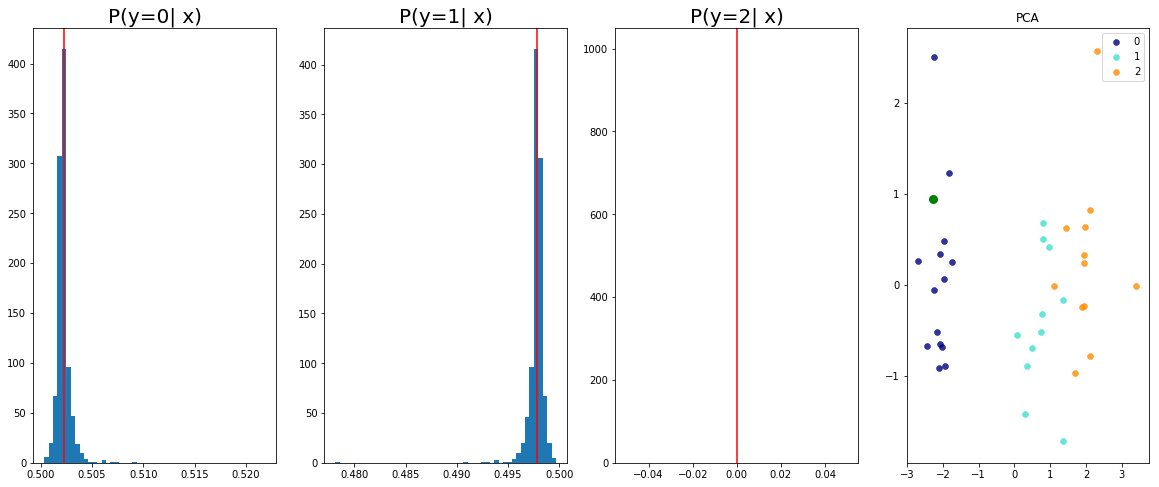

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.10702311247587204


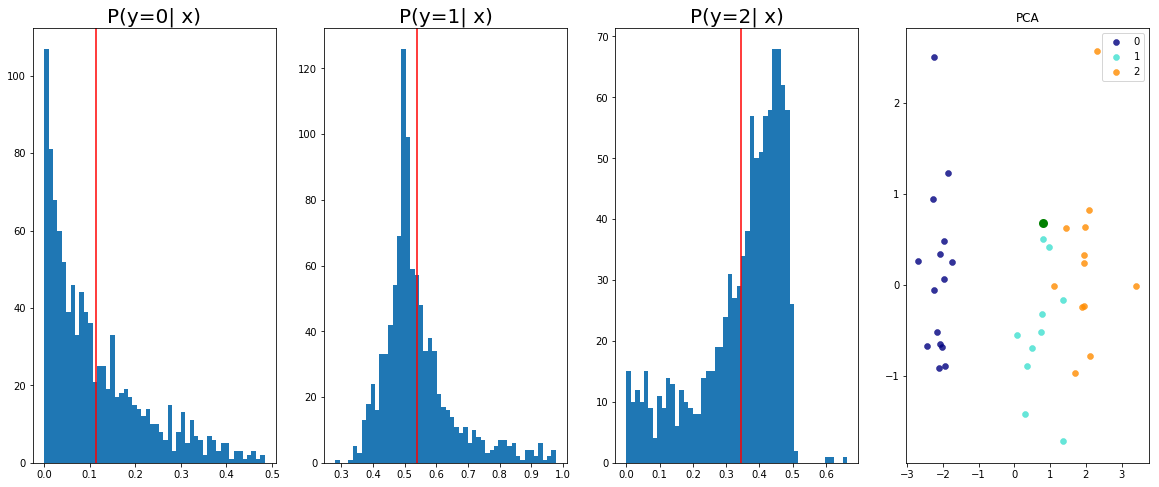

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.029406042769551277


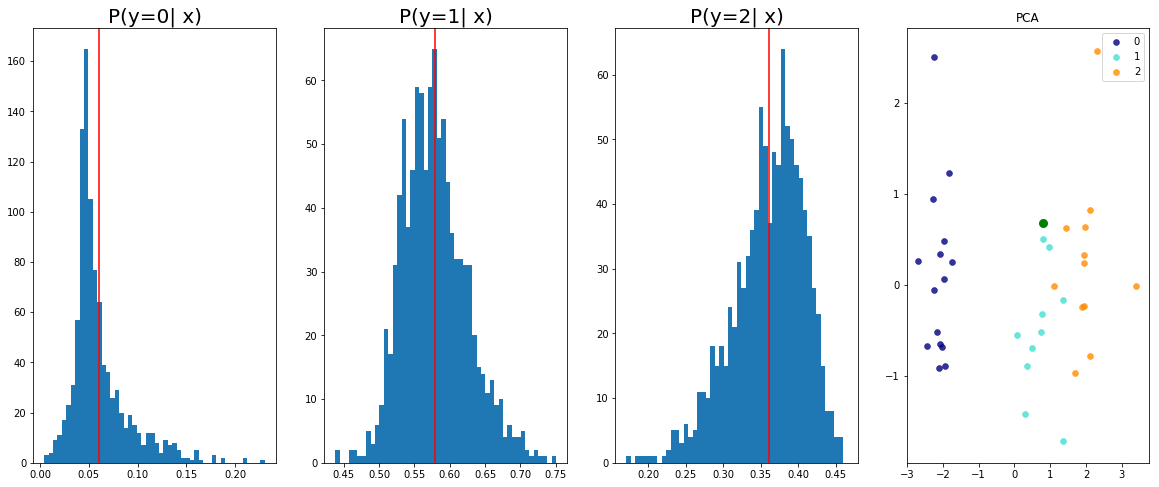

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.08301136642694473


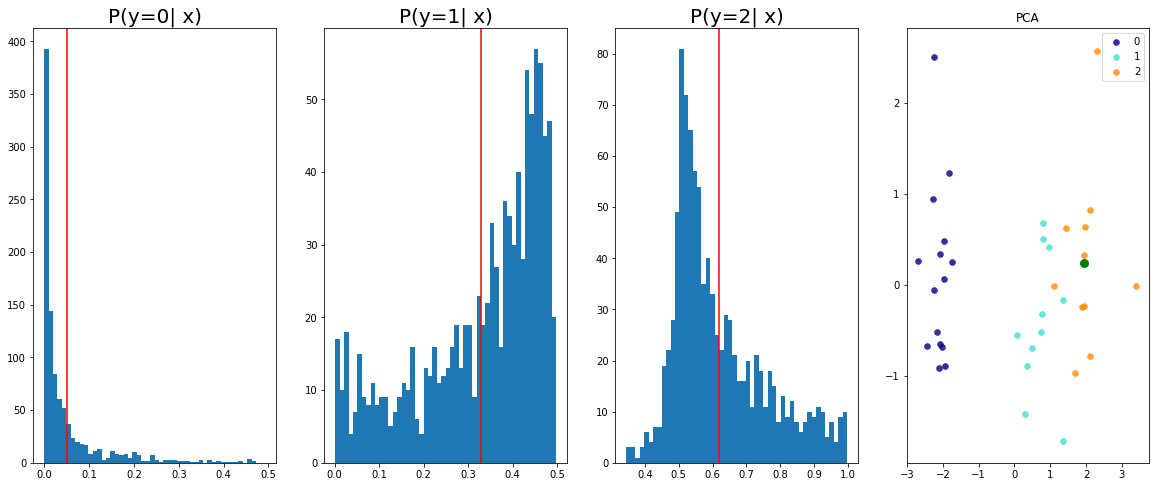

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0006687406566925347


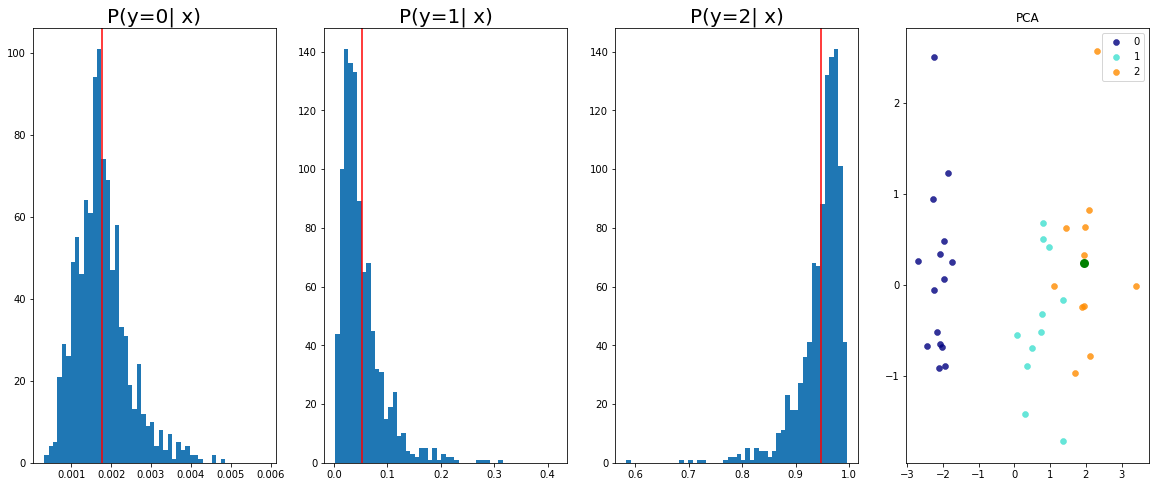

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.10966350138187408


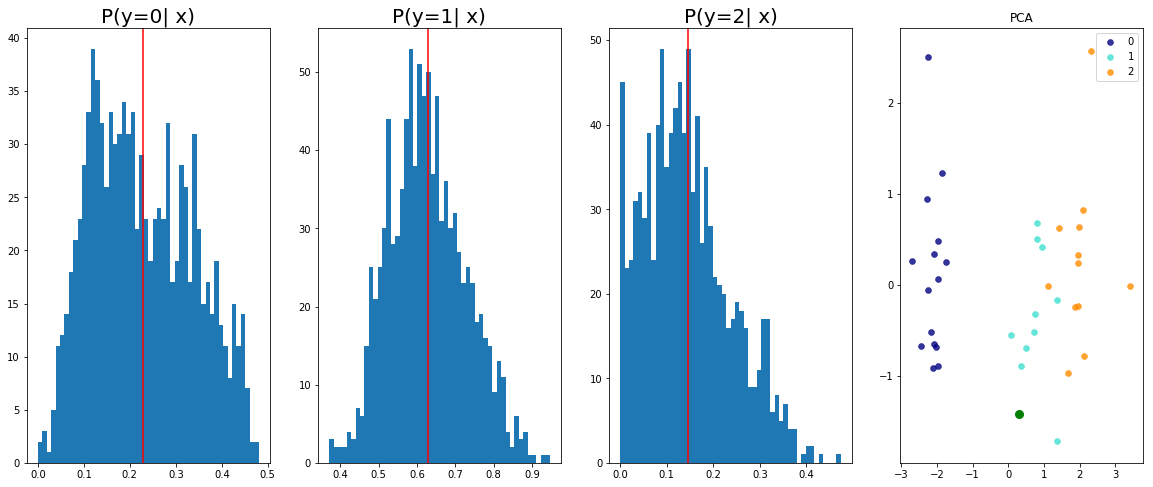

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.07249609380960464


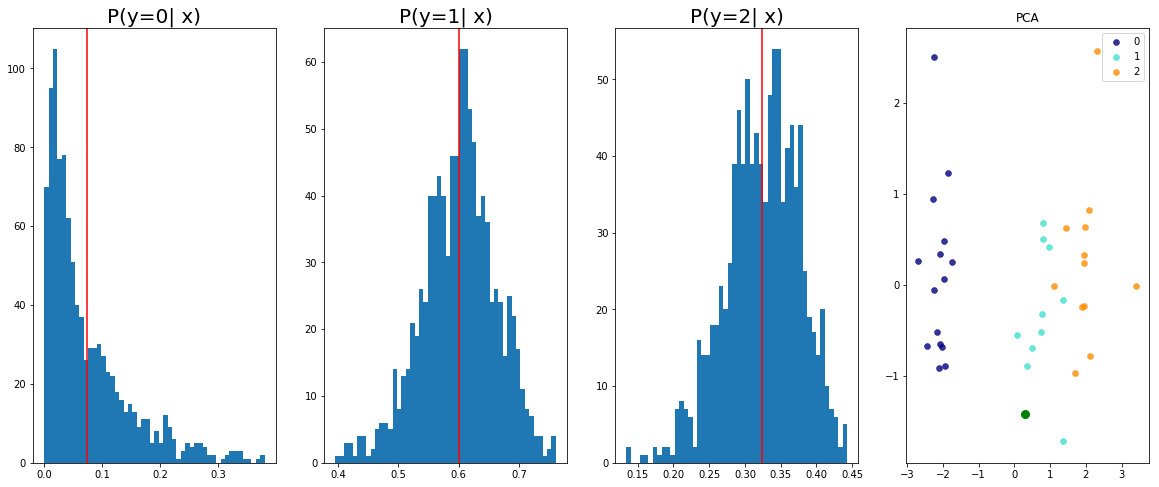

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.07323820888996124


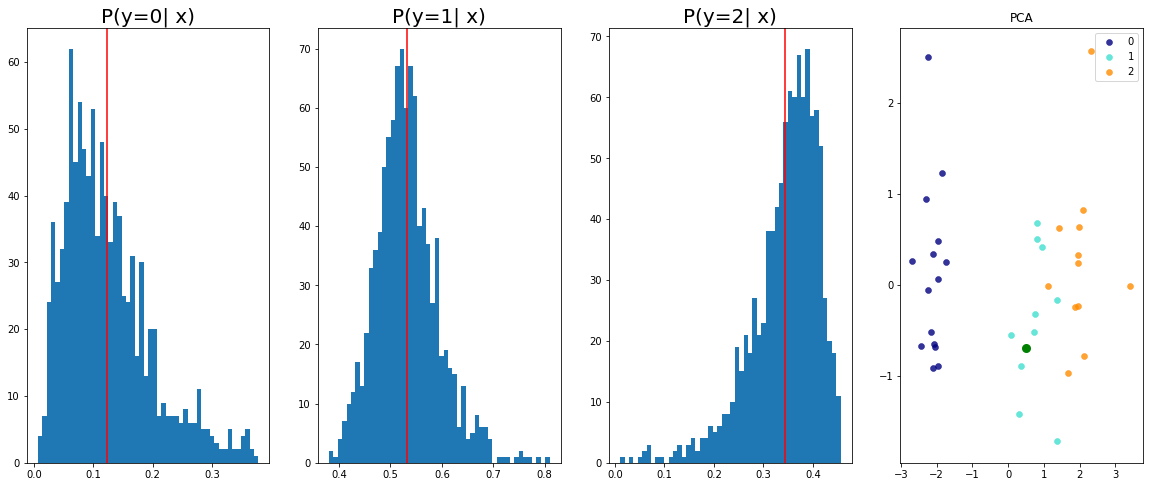

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.023048605769872665


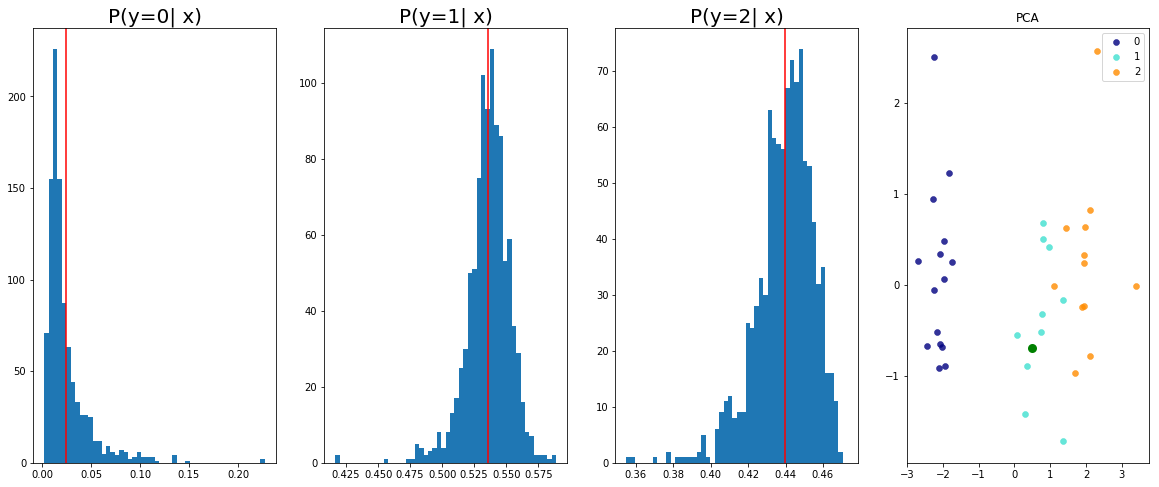

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.09459218382835388


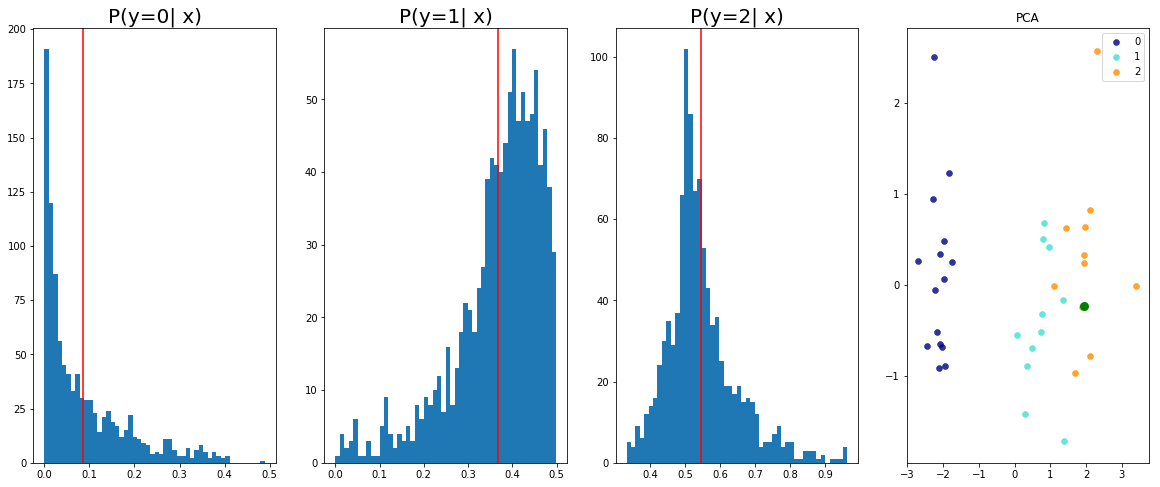

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0006898873252794147


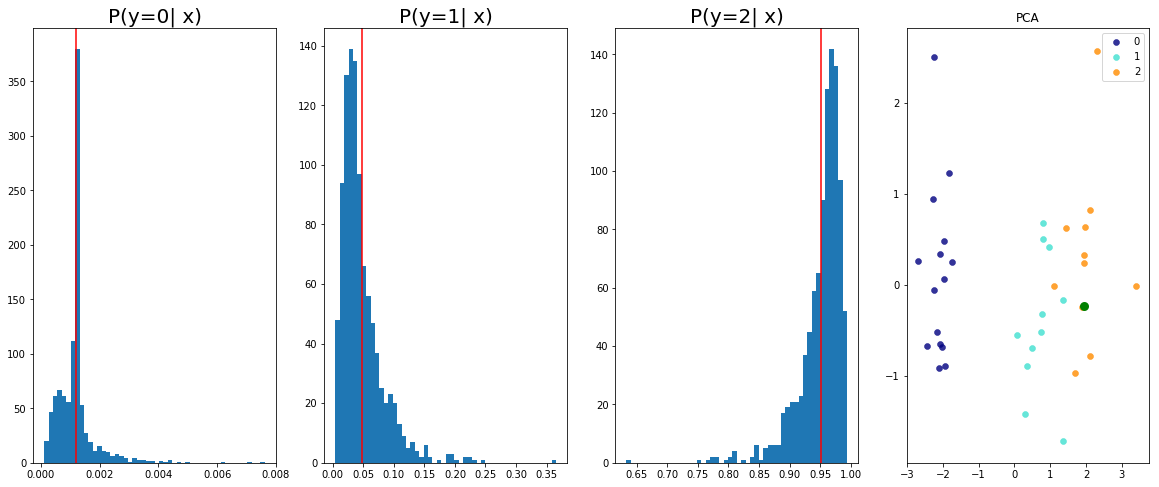

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.09719082713127136


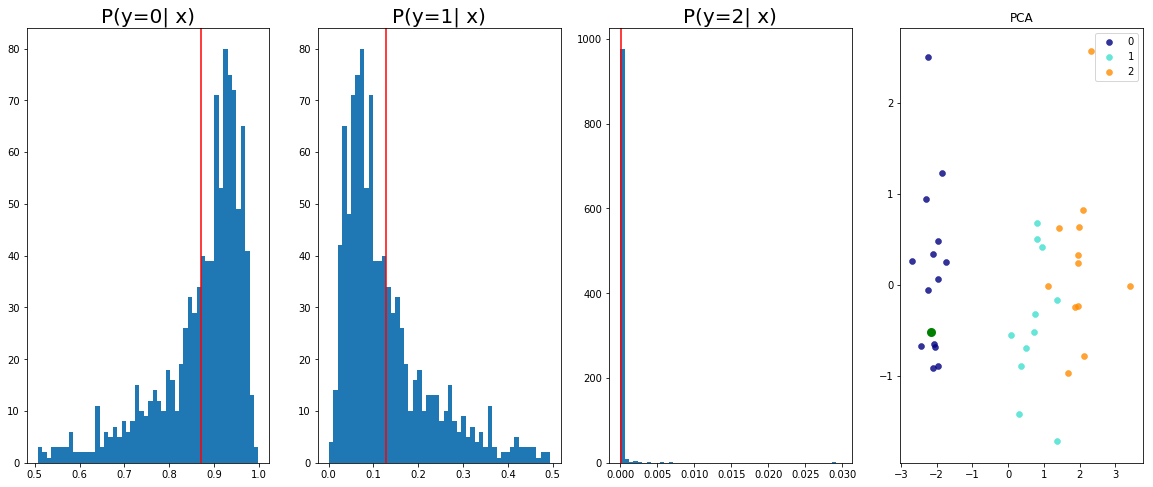

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0007462678477168083


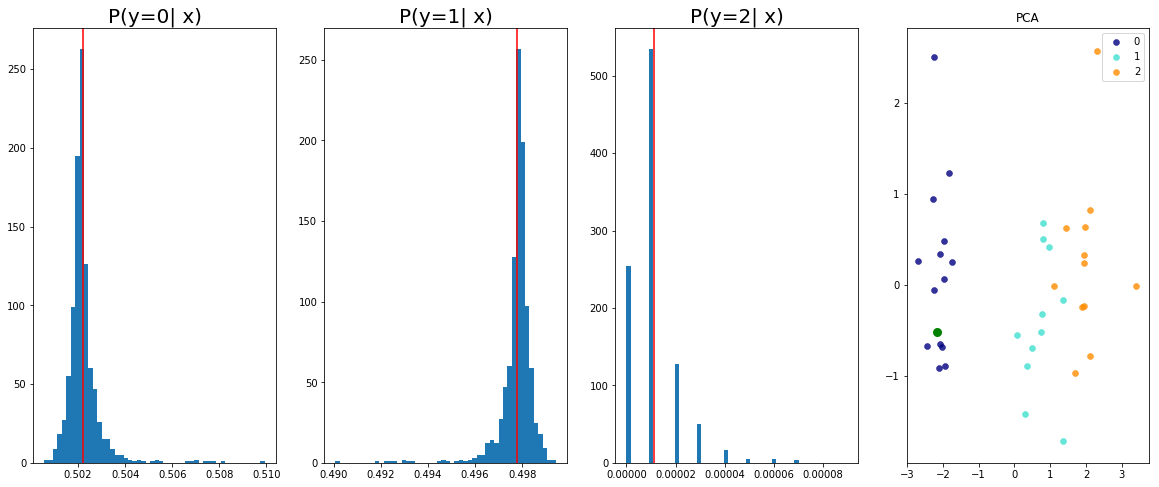

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.08041426539421082


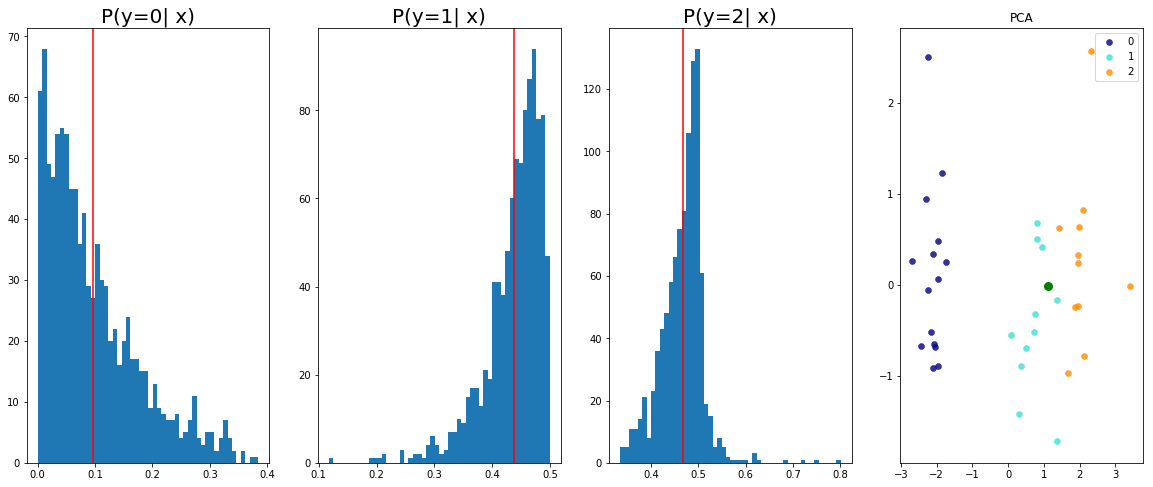

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.005737897474318743


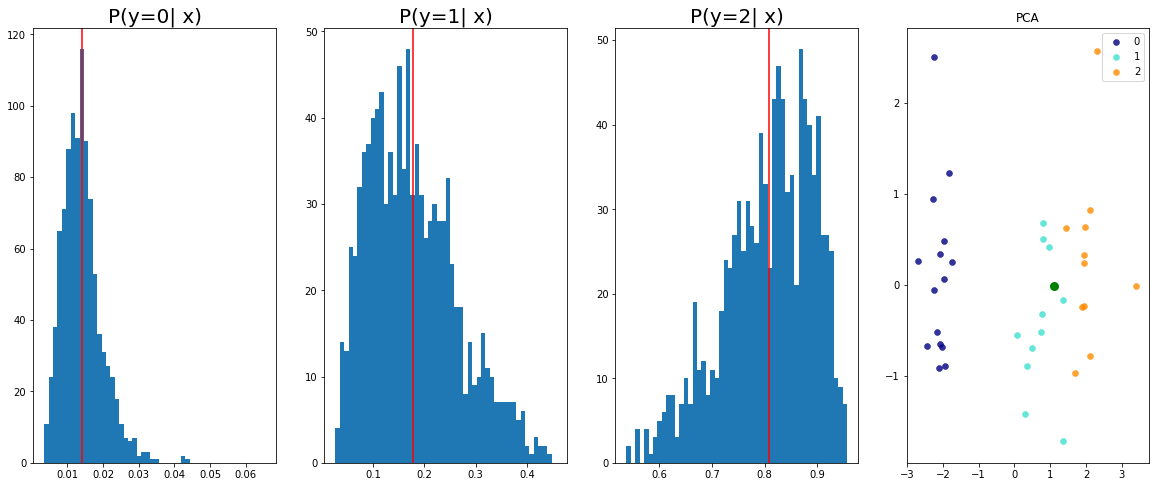

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.06831756979227066


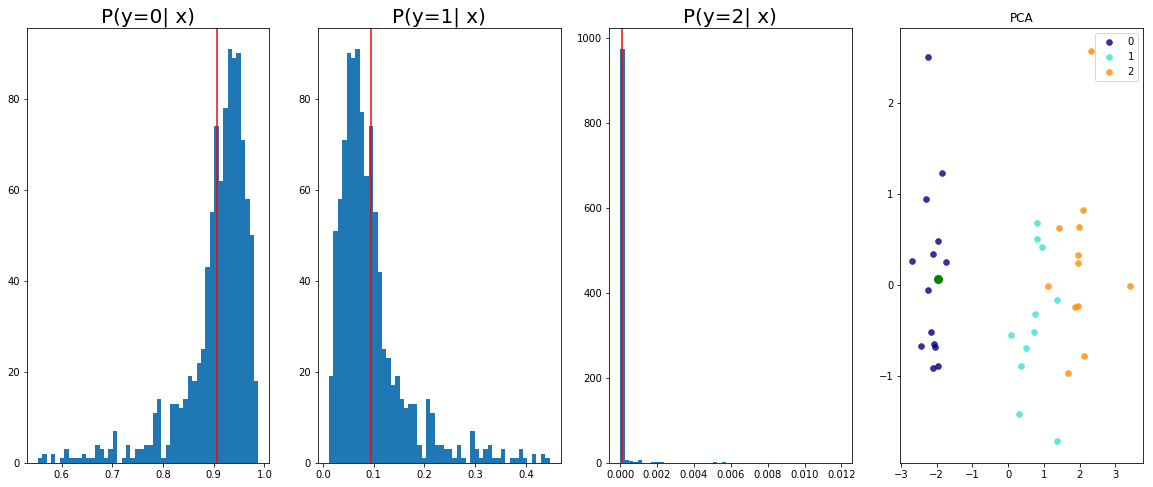

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0006759276730008423


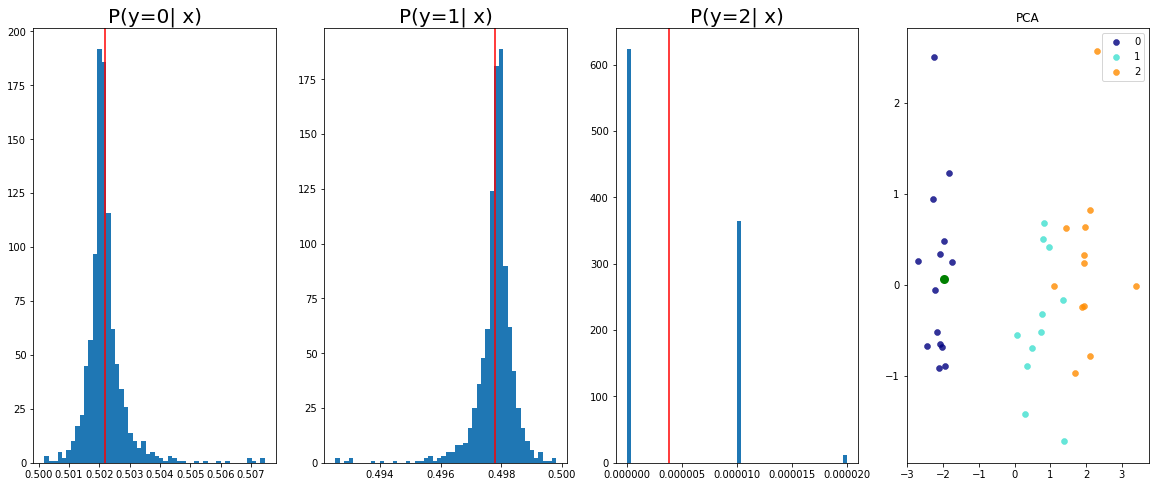

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.09550007432699203


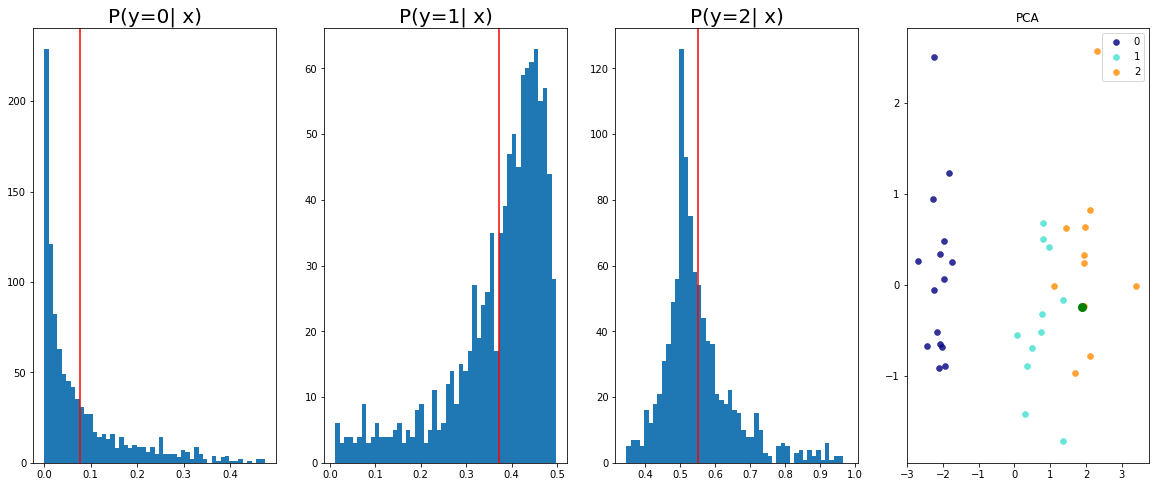

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0008054686477407813


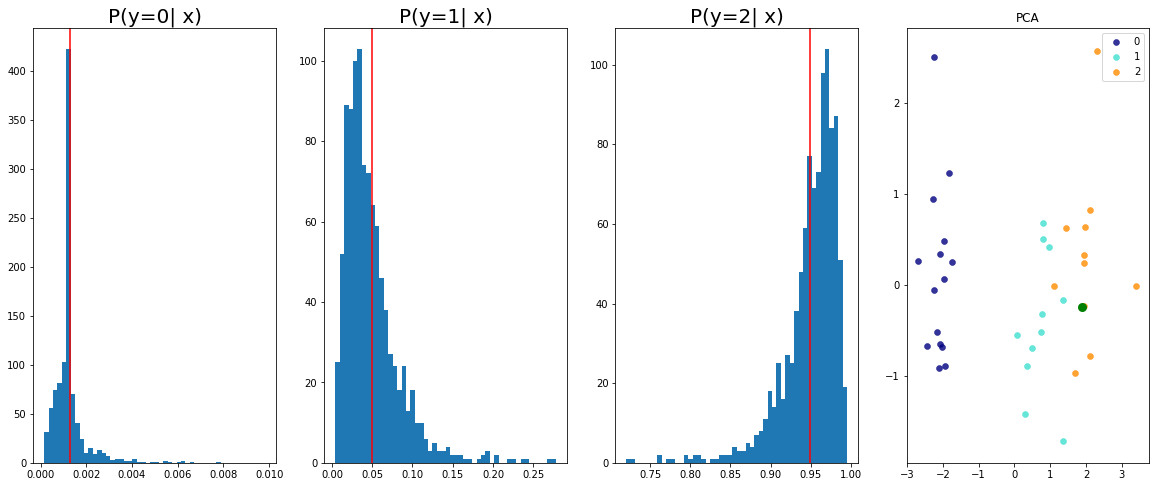

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.04751398414373398


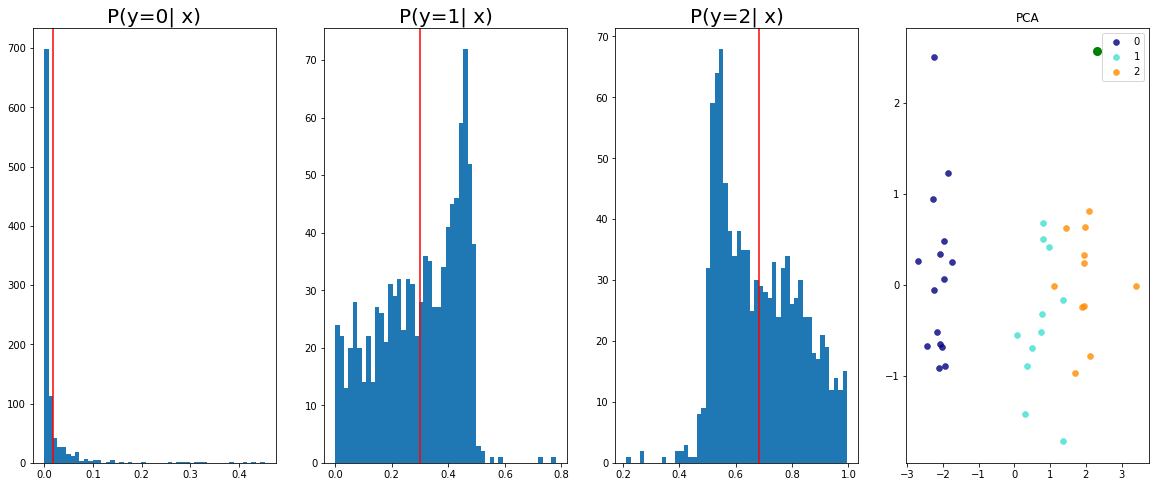

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.03420984372496605


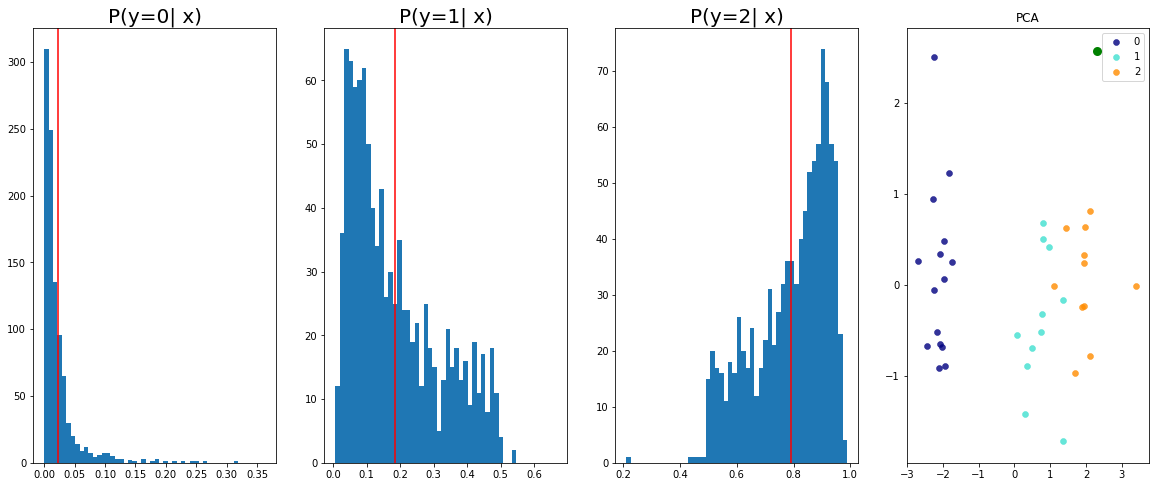

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.08766554296016693


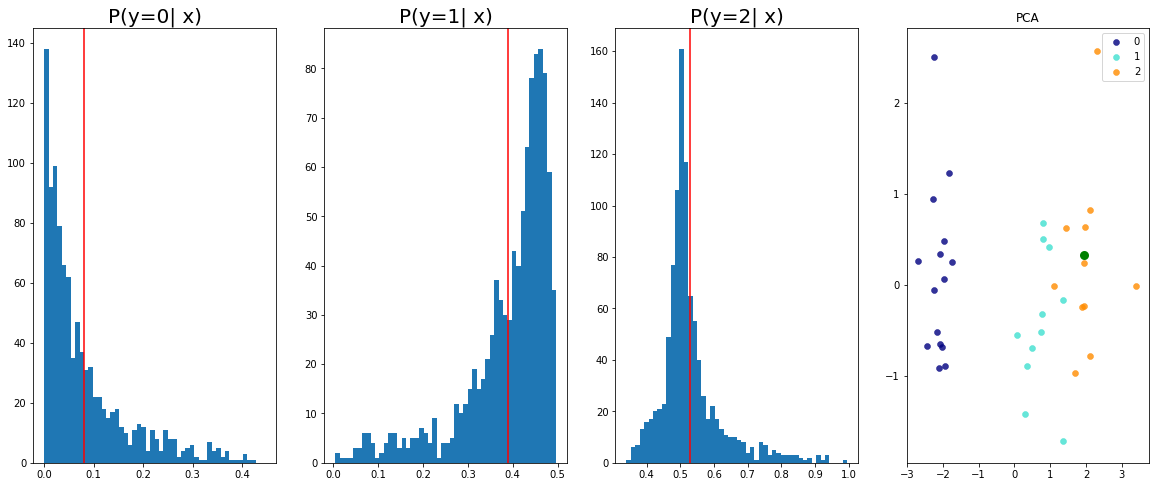

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0025616486091166735


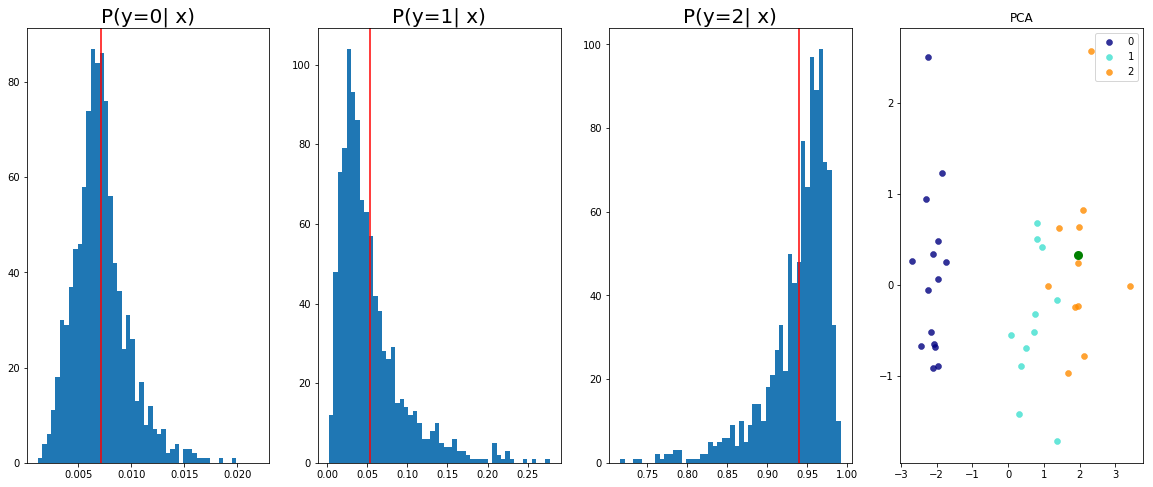

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.032007962465286255


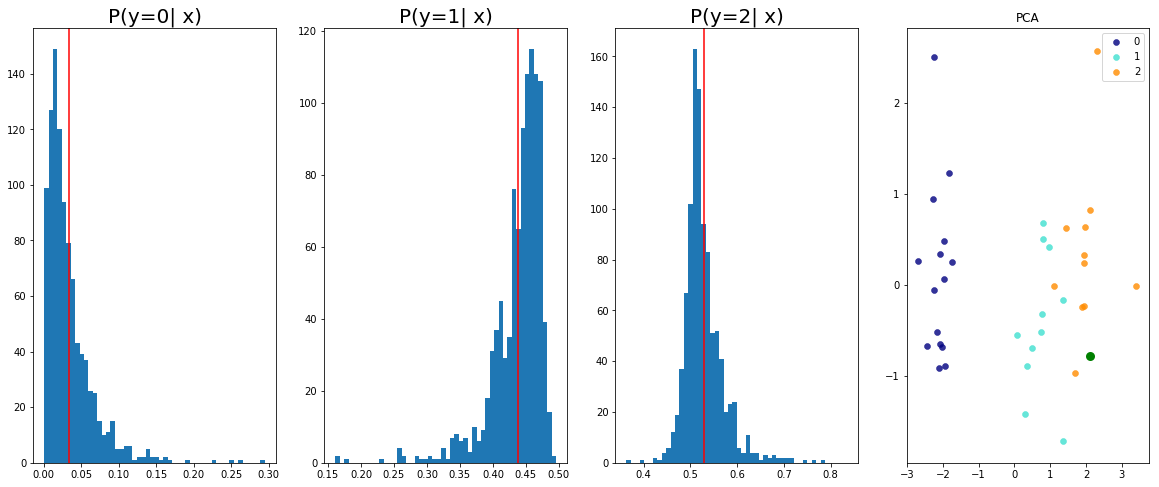

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0005595300463028252


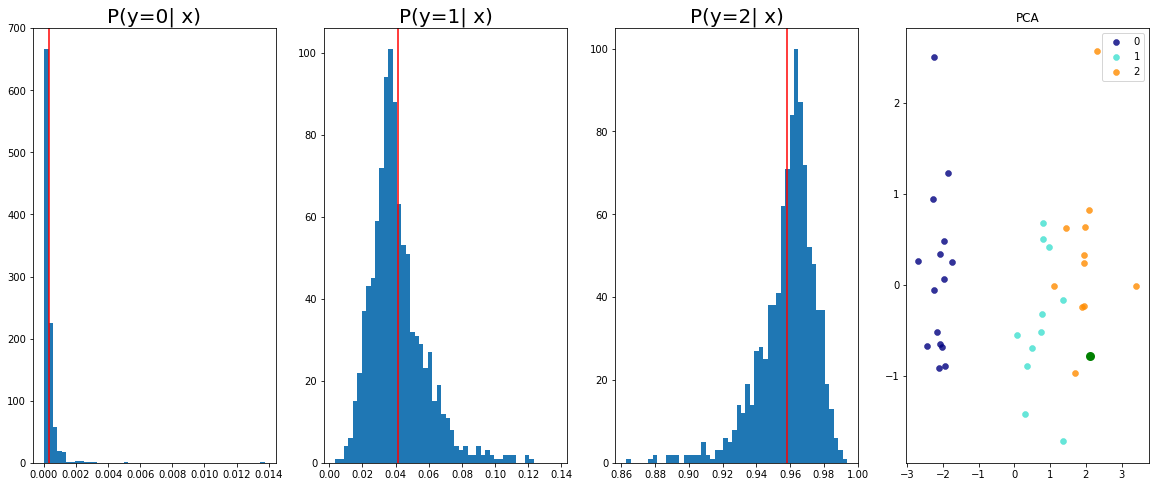

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.04679561033844948


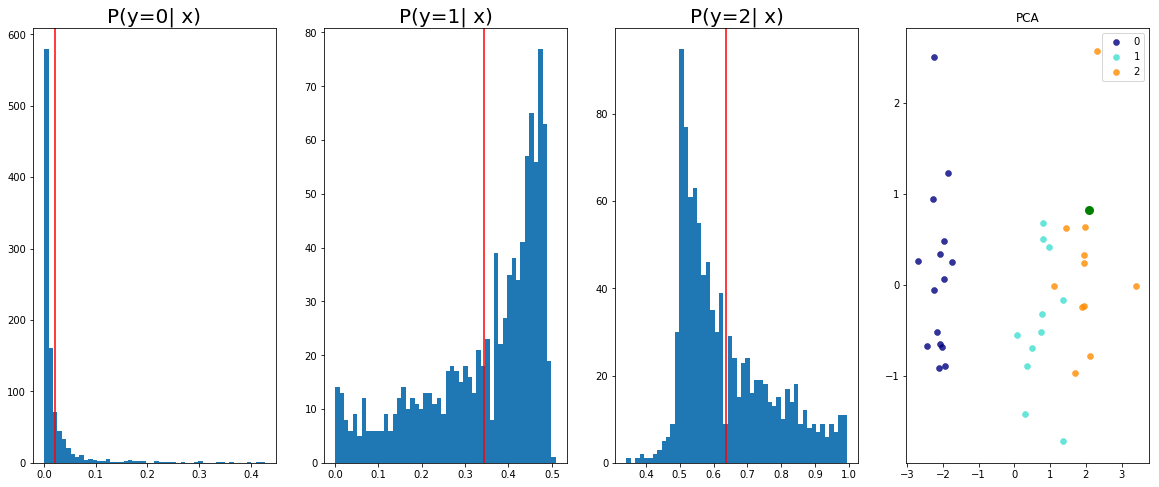

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0017264819471165538


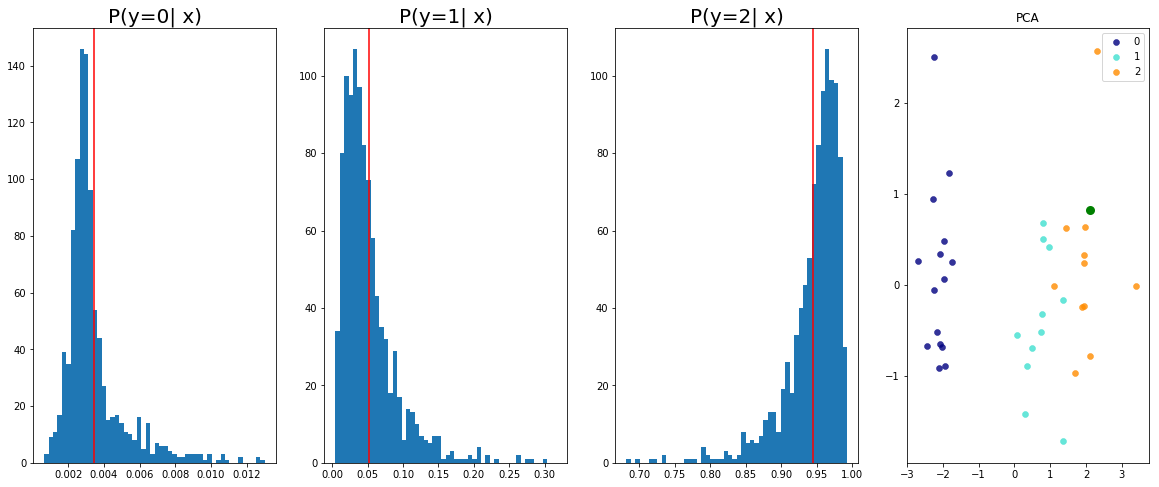

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.10840524733066559


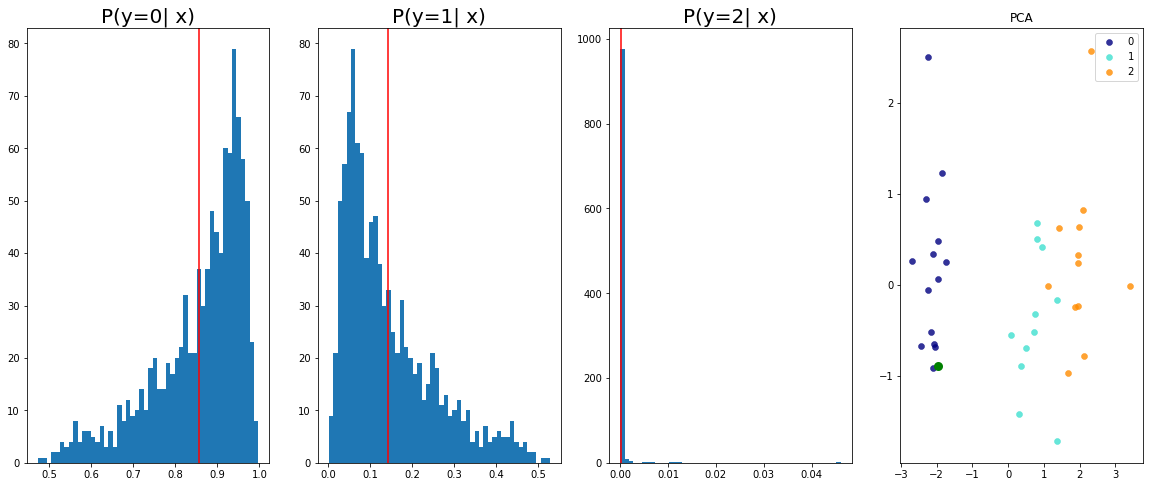

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0006874307873658836


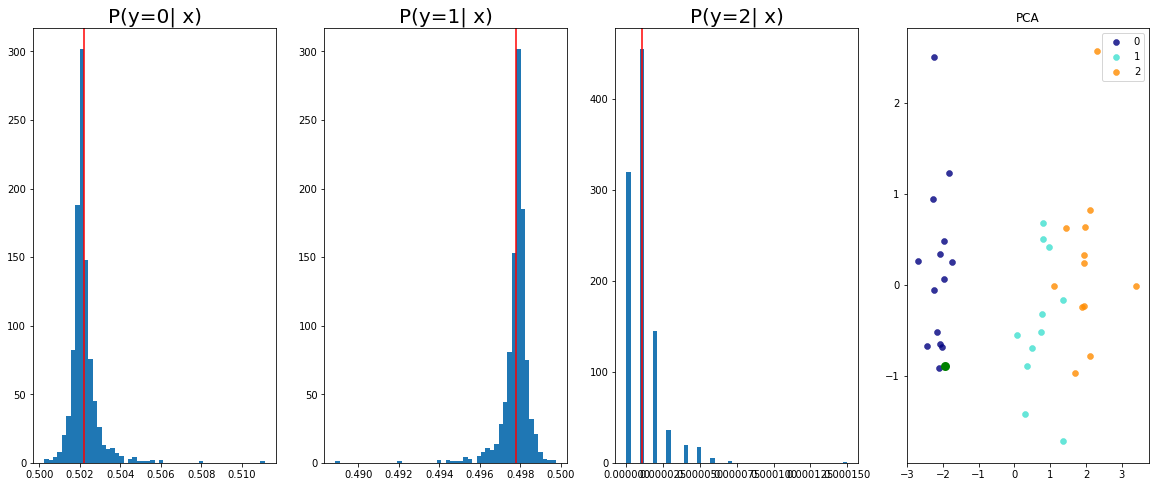

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.10567843168973923


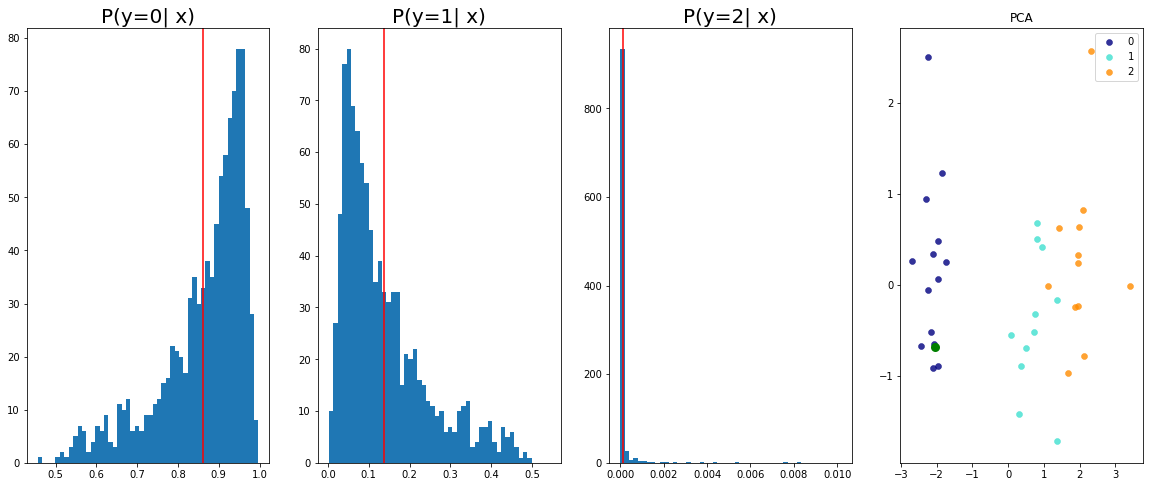

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.00075847830157727


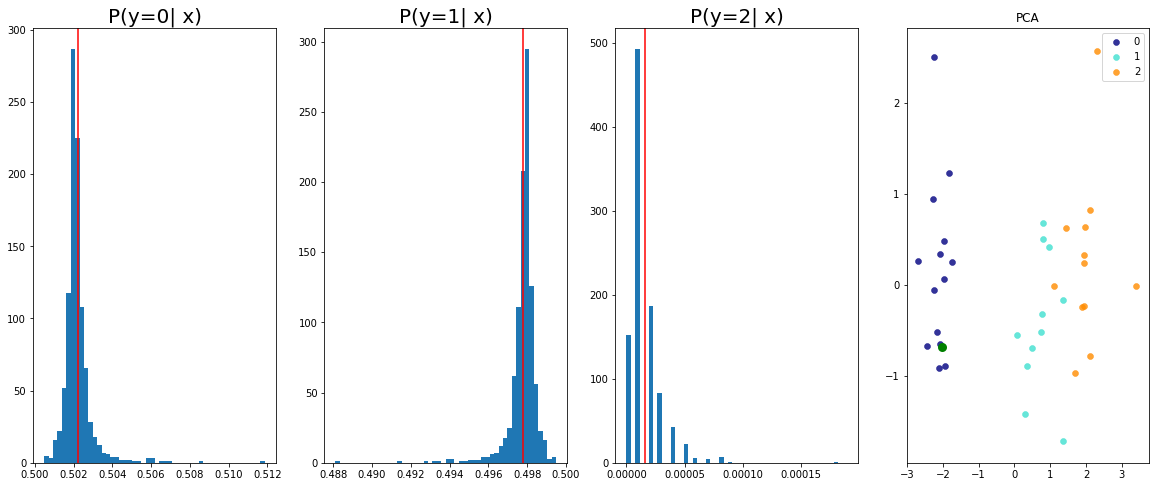

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.07513697445392609


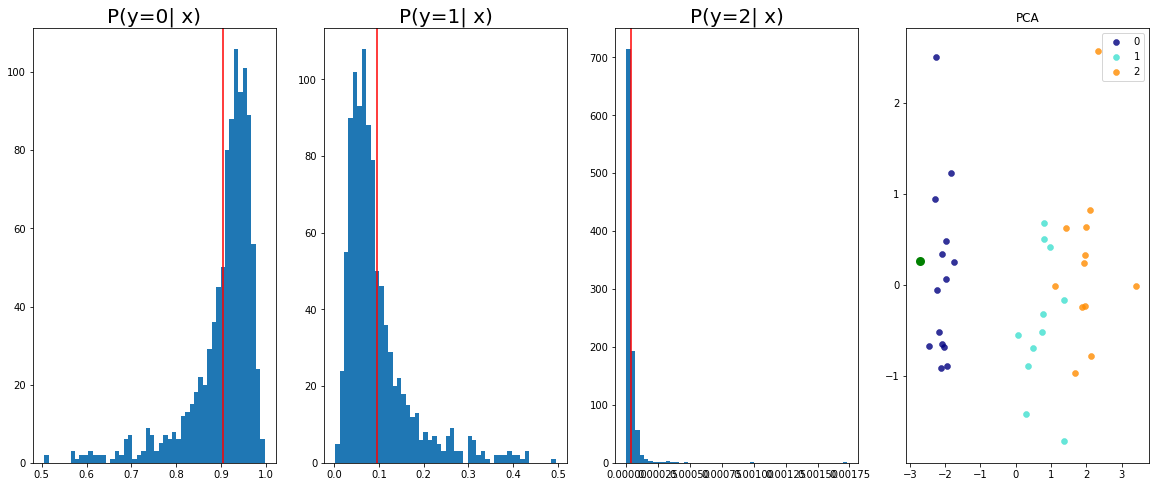

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.000655252777505666


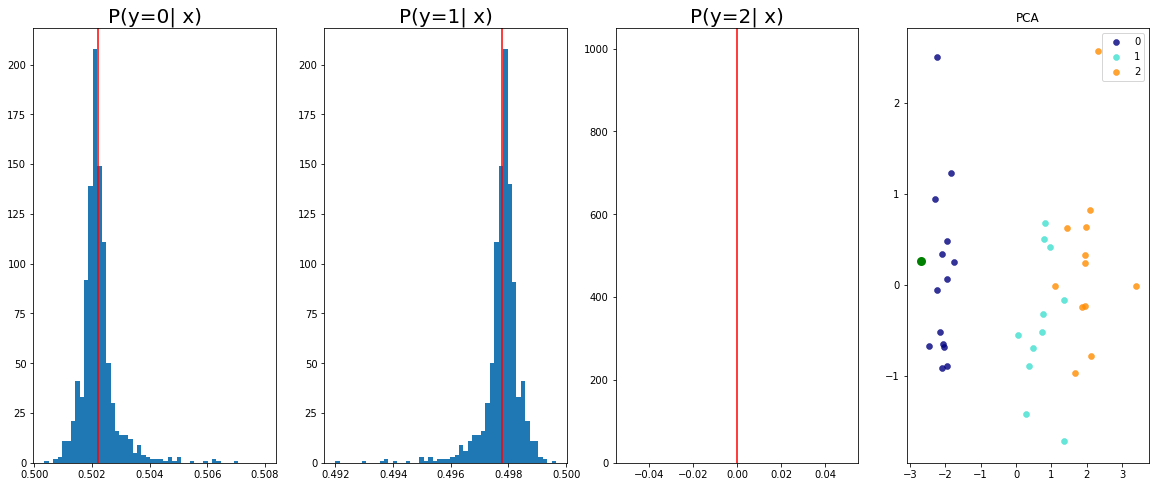

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.08846631646156311


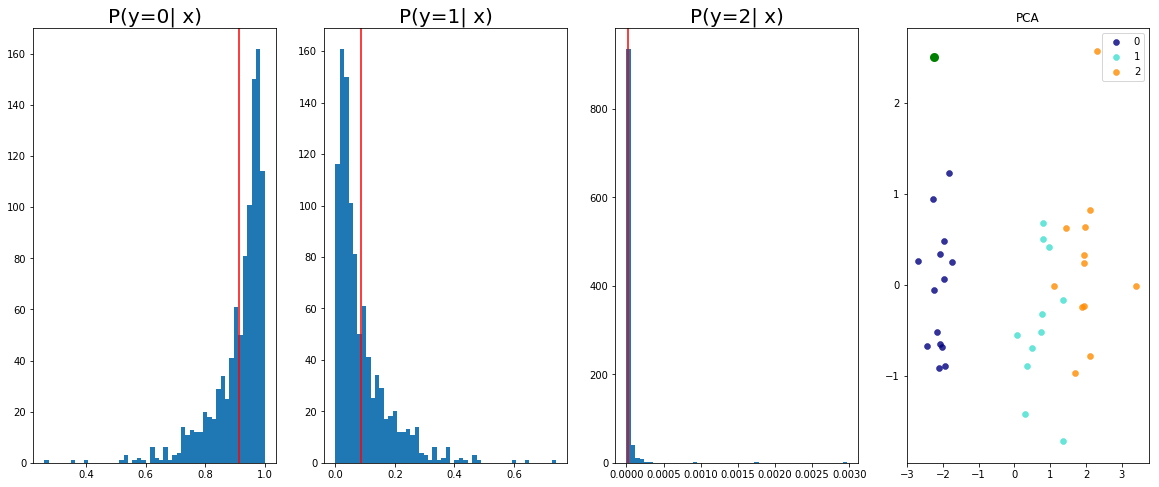

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0012009490747004747


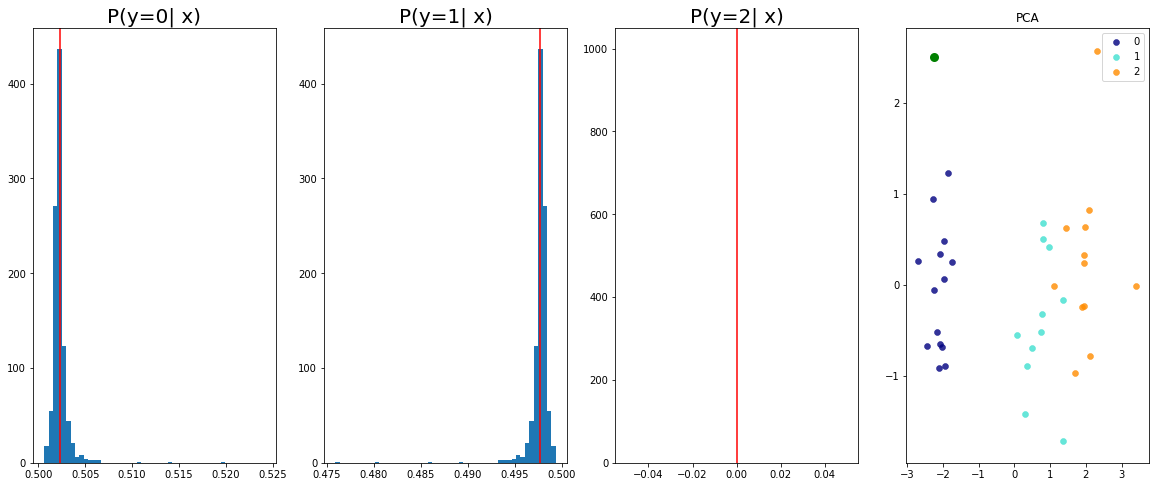

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.16093496978282928


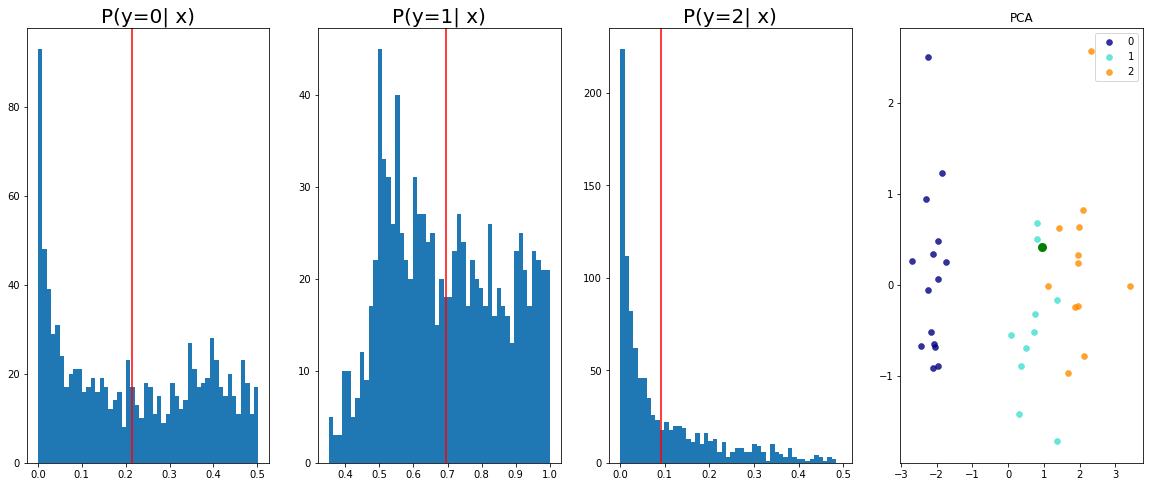

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.04023777320981026


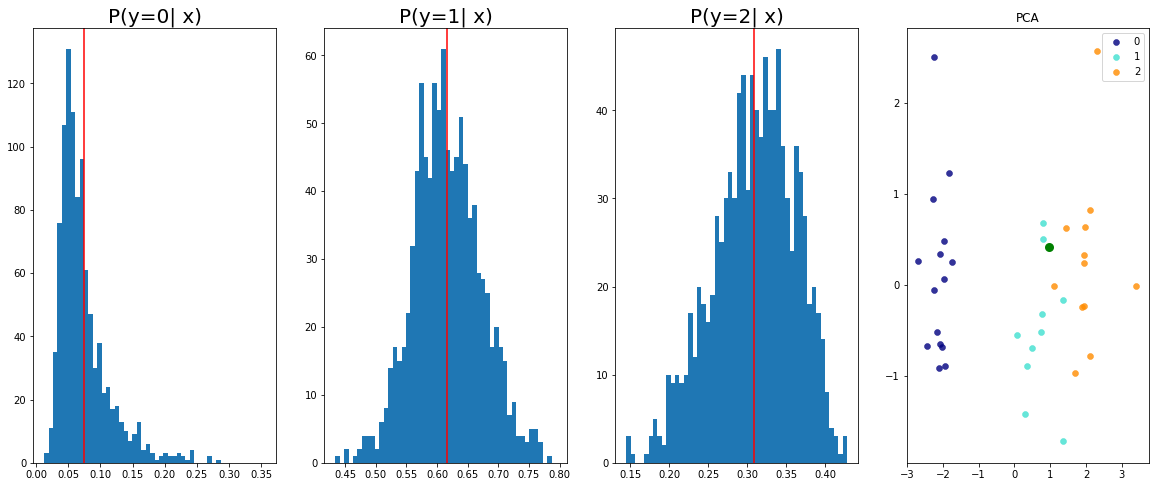

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.08915170282125473


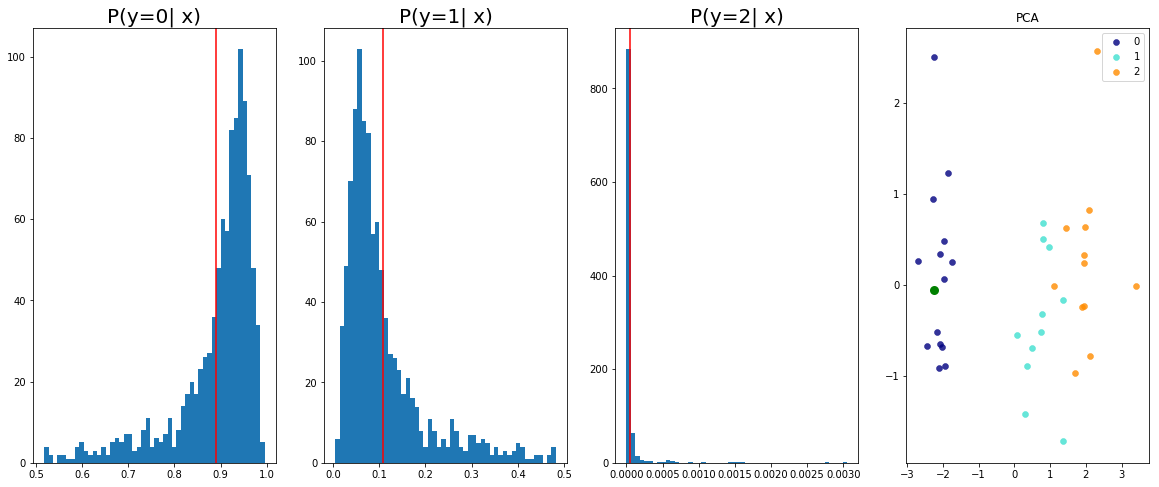

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0007275830139406025


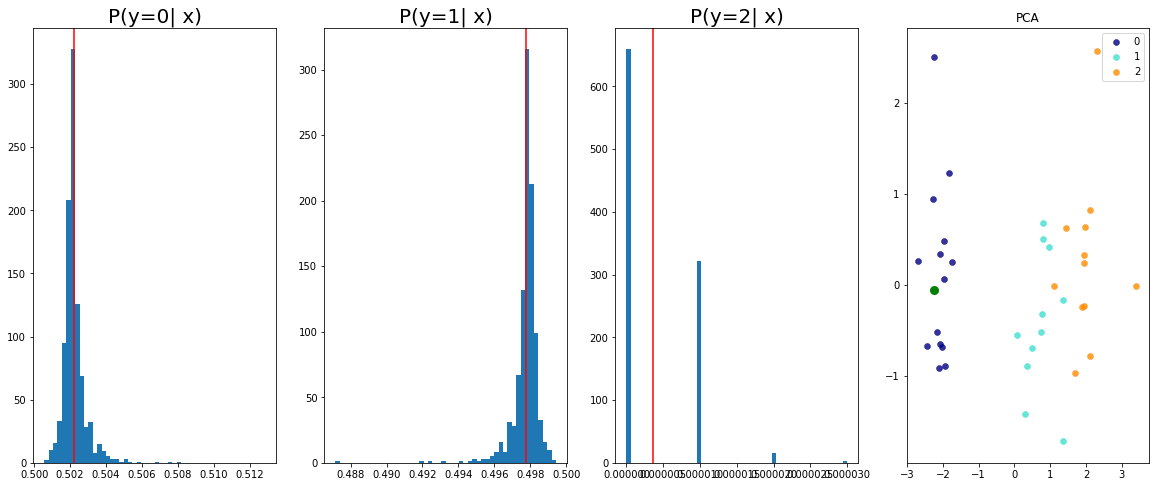

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.10296455770730972


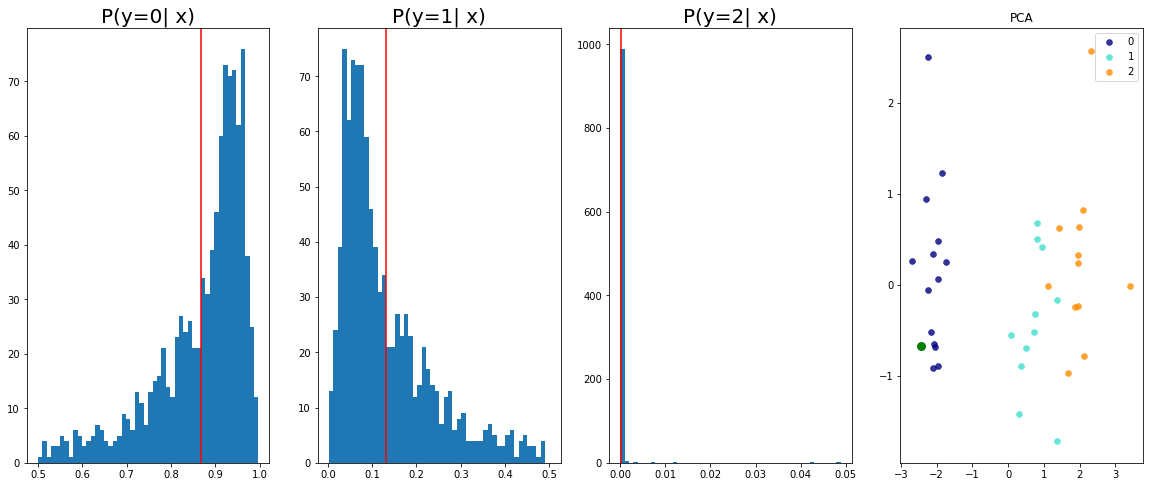

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.000827915093395859


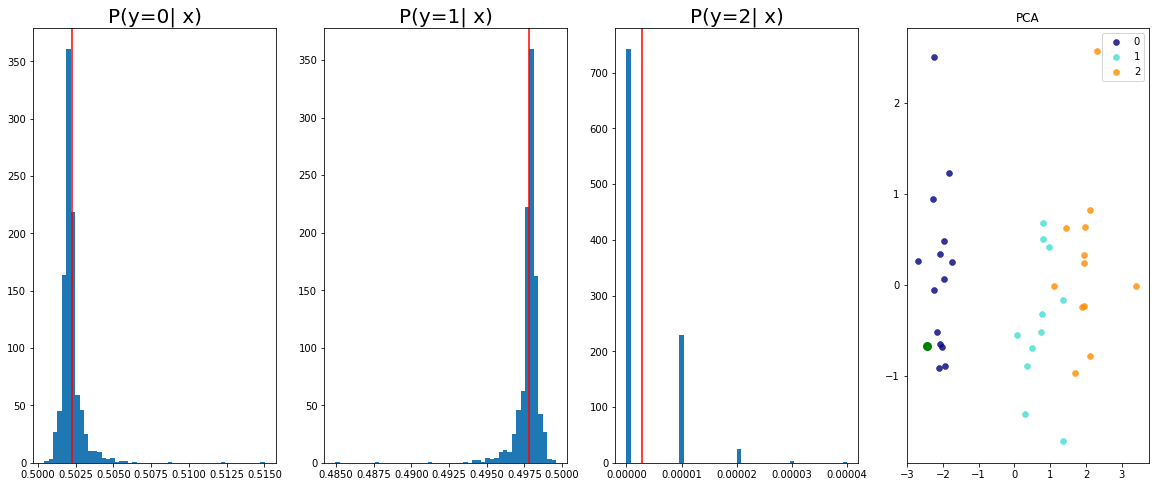

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.0607076957821846


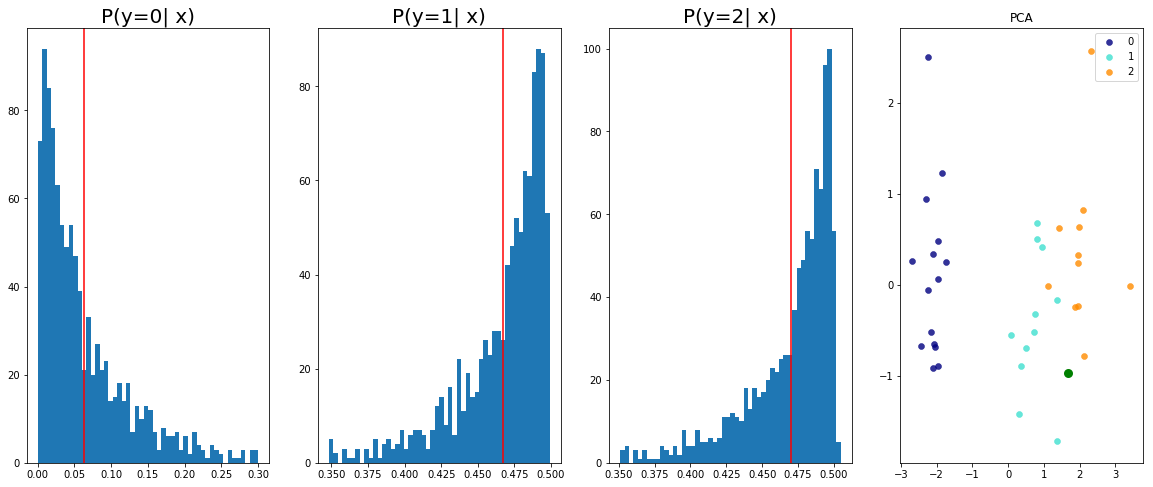

###################################  NE   ################################################
True -> 2
Predicted -> 2
STDS: 0.0030524637550115585


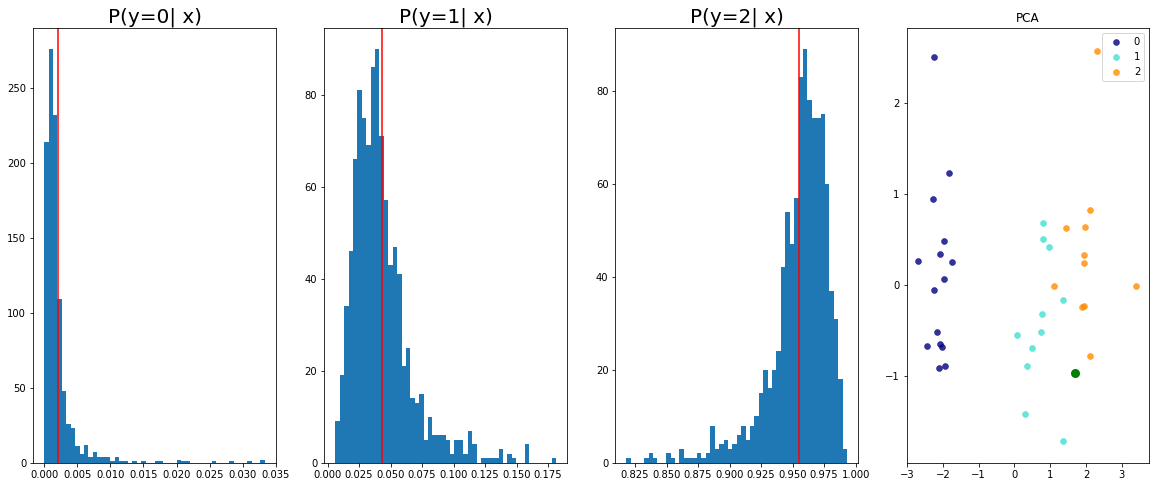

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.14437870681285858


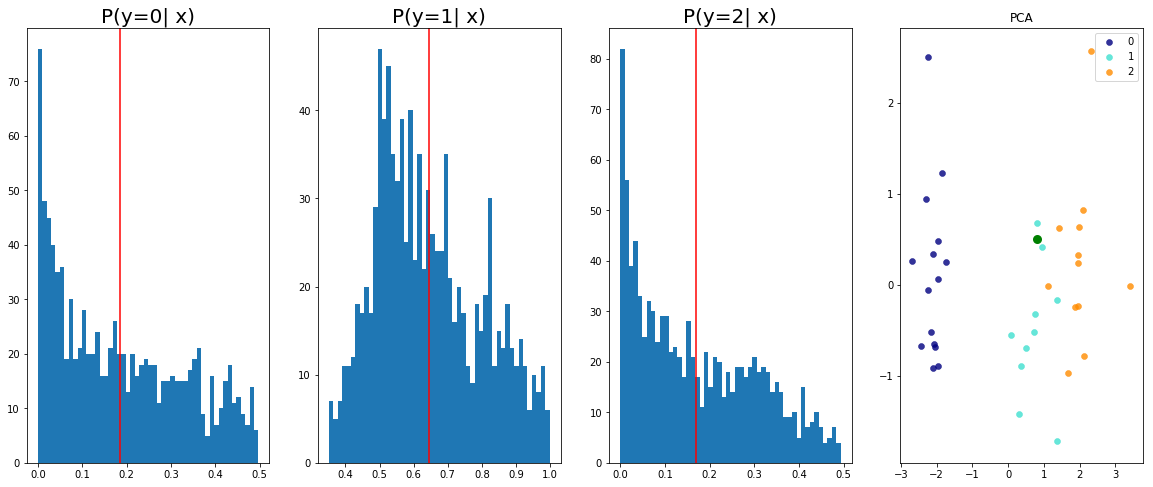

###################################  NE   ################################################
True -> 1
Predicted -> 1
STDS: 0.03503066673874855


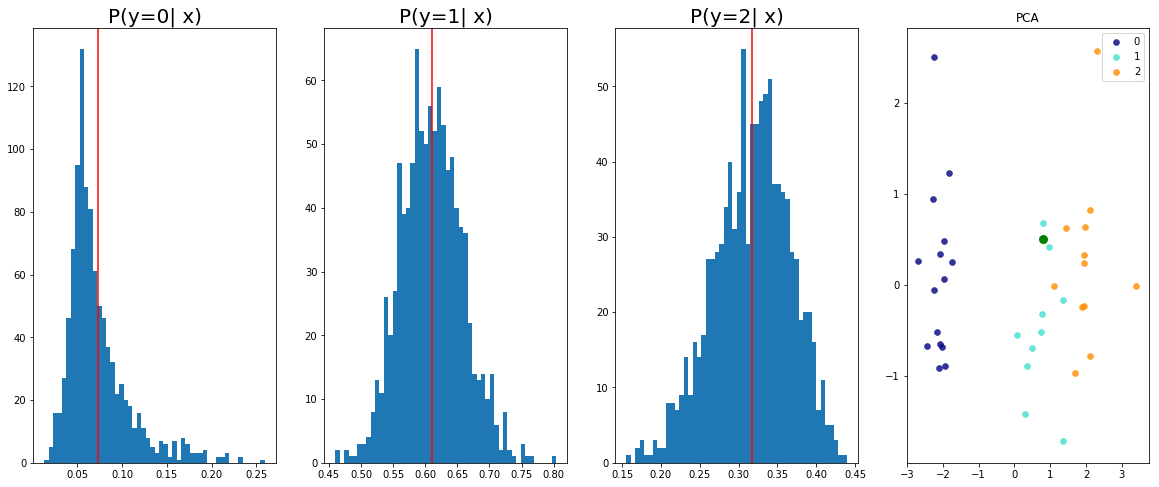

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.0818028673529625


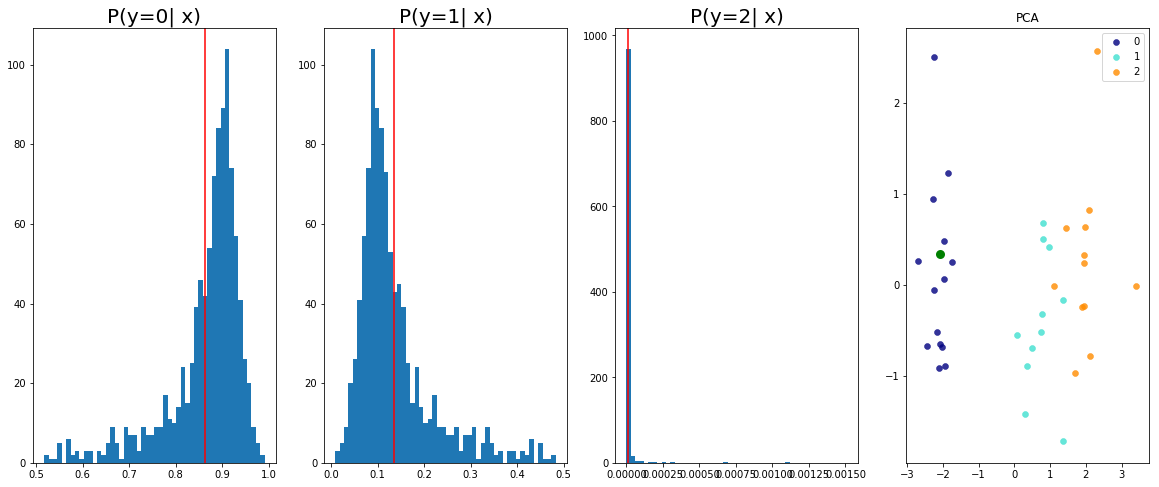

###################################  NE   ################################################
True -> 0
Predicted -> 0
STDS: 0.0007867051172070205


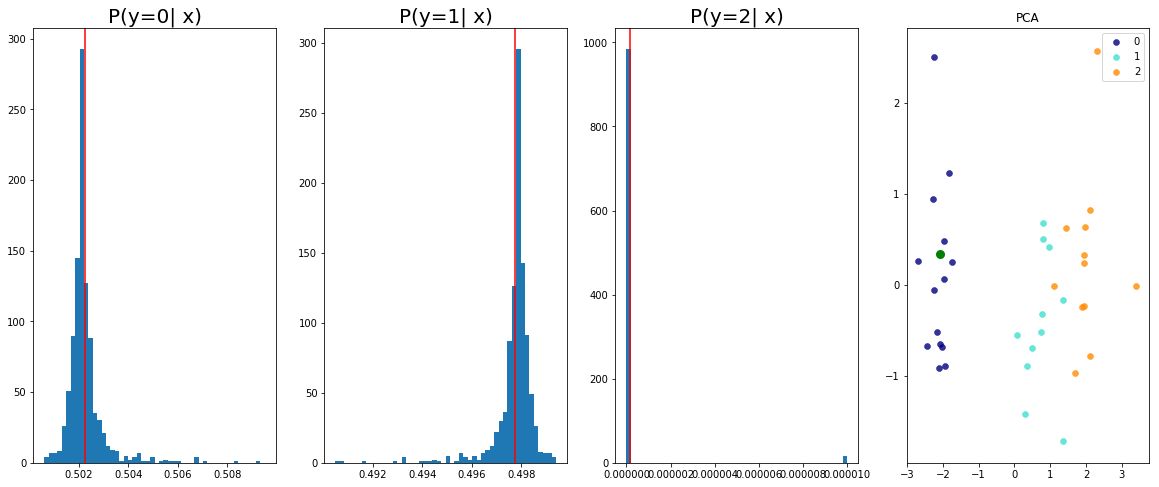

In [74]:
for i in range(len(estimator_nas)):
    print('###################################################################################')
    print('###################################################################################')
    print('###################################################################################')
    print('###################################  NAS   ################################################')
    plot_prediction_probabilities(estimator=estimator_nas, index_to_plot=i)
    print('###################################  NE   ################################################')
    plot_prediction_probabilities(estimator=estimator_ne, index_to_plot=i)


In [75]:
dataset = estimator_ne.get_dataset()

In [81]:
x_batch = dataset.x_train
display(x_batch.mean(0))
display(x_batch.std(0))

tensor([-0.0157, -0.0395,  0.0279,  0.0197])

tensor([0.9925, 1.0062, 0.9863, 0.9845])

In [20]:
report = experiment_data_ne.reports['7aba913e-7d4d-4611-be93-9549c2d0389e']

In [21]:
config = jsons.load(report.configuration, BaseConfiguration)
network = ProbabilisticFeedForwardDeser.from_dict(report.best_network)
network

ProbabilisticFeedForward(
  (activation): Tanh()
  (layer_1): ComplexStochasticLinear (4 -> 10)
  (activation_1): Tanh()
  (layer_0): StochasticLinear (10 -> 3)
)

In [26]:
config.dataset_random_state = 1

In [27]:
estimator = PredictionDistributionEstimatorNetwork(network, config=config, testing=False, n_samples=1000)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile()

Sum Train: -6.481589317321777
Training: 112. Testing: 38


,order_std,accuracy,f1
0,10,0.980198,0.980003
1,11,0.980000,0.979803
2,12,0.979798,0.979599
3,13,0.979592,0.979371
4,14,0.979381,0.979136
...,...,...,...
87,97,1.000000,1.000000
88,98,1.000000,1.000000
89,99,1.000000,1.000000
90,100,1.000000,1.000000


,order_std,accuracy,f1
0,10,0.980198,0.980003
1,11,0.980000,0.979803
2,12,0.979798,0.979599
3,13,0.979592,0.979371
4,14,0.979381,0.979136


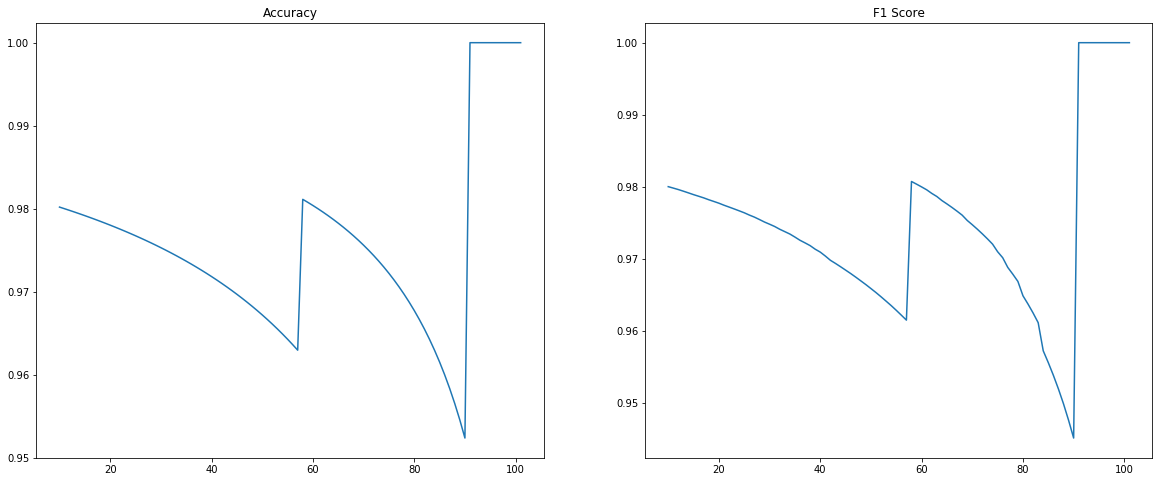

In [29]:
display(estimator.metrics_by_quantile.head())
plot_metrics_by_quantile(metrics_by_quantile=estimator.metrics_by_quantile)

True -> 1
Predicted -> 1
STDS: 0.13165701925754547


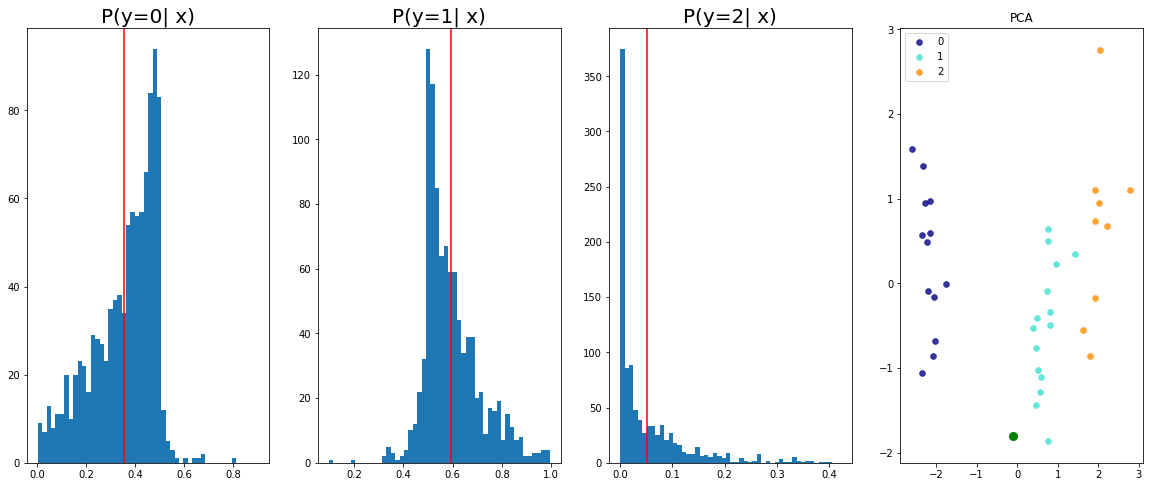

In [28]:
plot_prediction_probabilities(estimator=estimator, index_to_plot=1)

True -> 0
Predicted -> 0
STDS: 0.07055343687534332


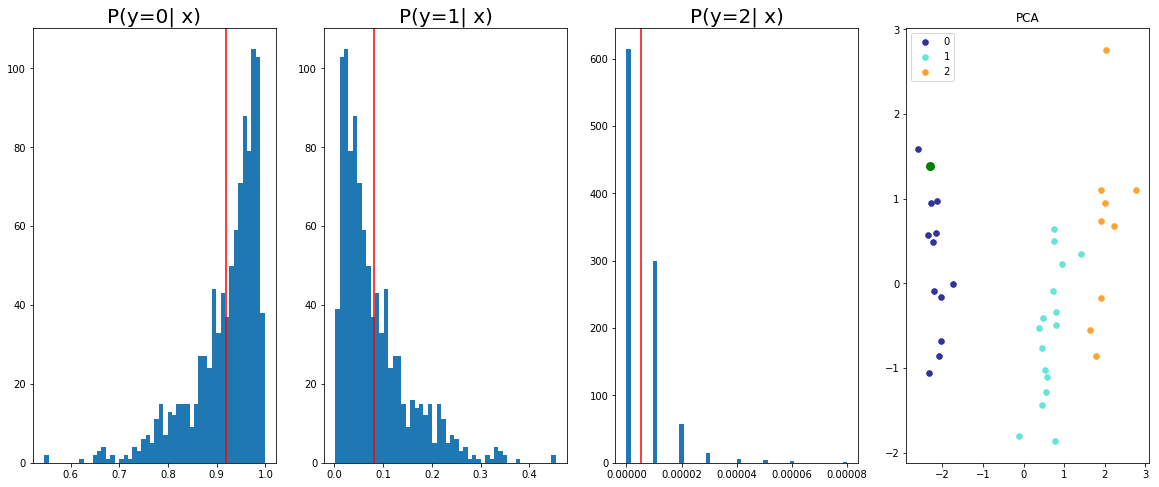

True -> 1
Predicted -> 1
STDS: 0.13165701925754547


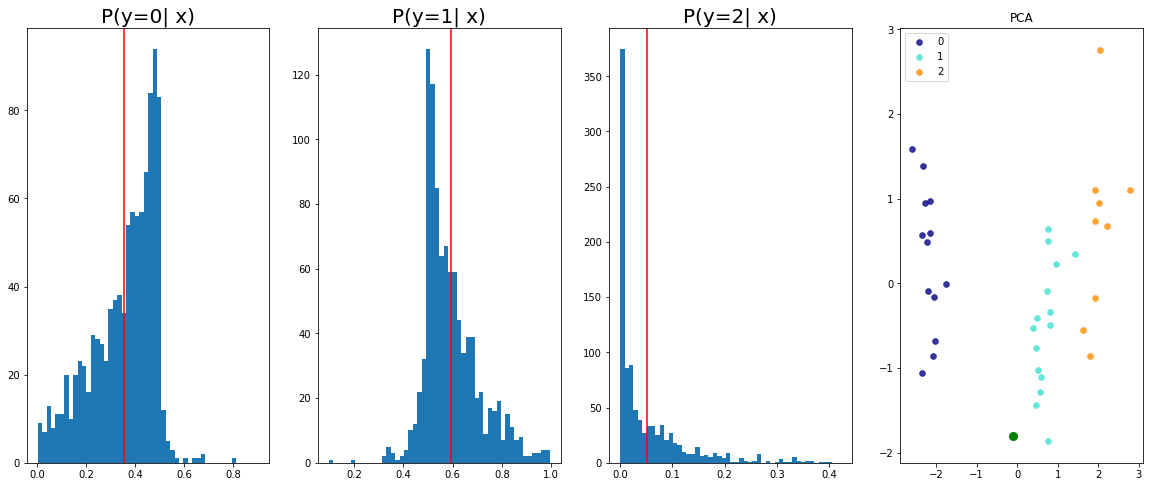

True -> 1
Predicted -> 1
STDS: 0.15950532257556915


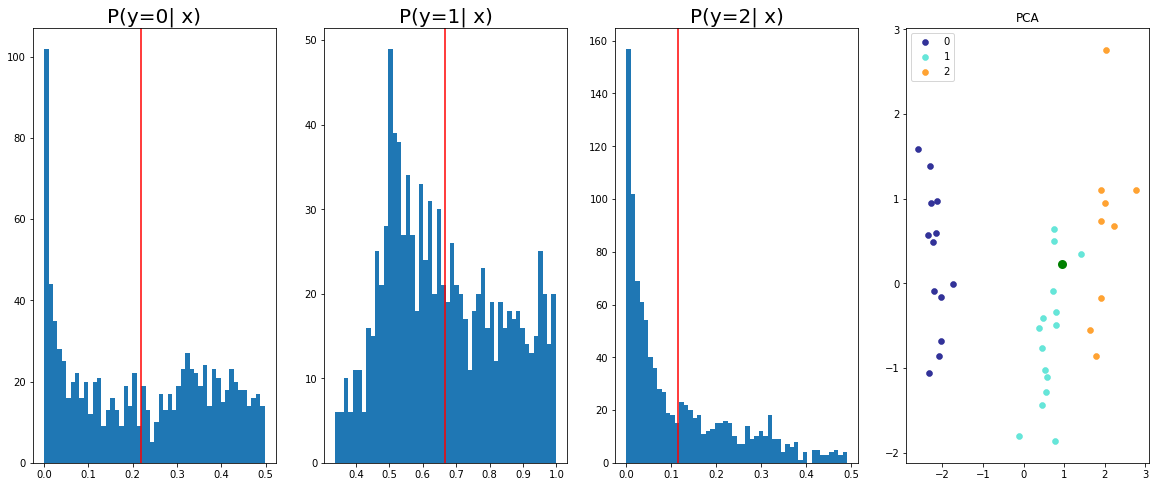

True -> 0
Predicted -> 0
STDS: 0.07272834330797195


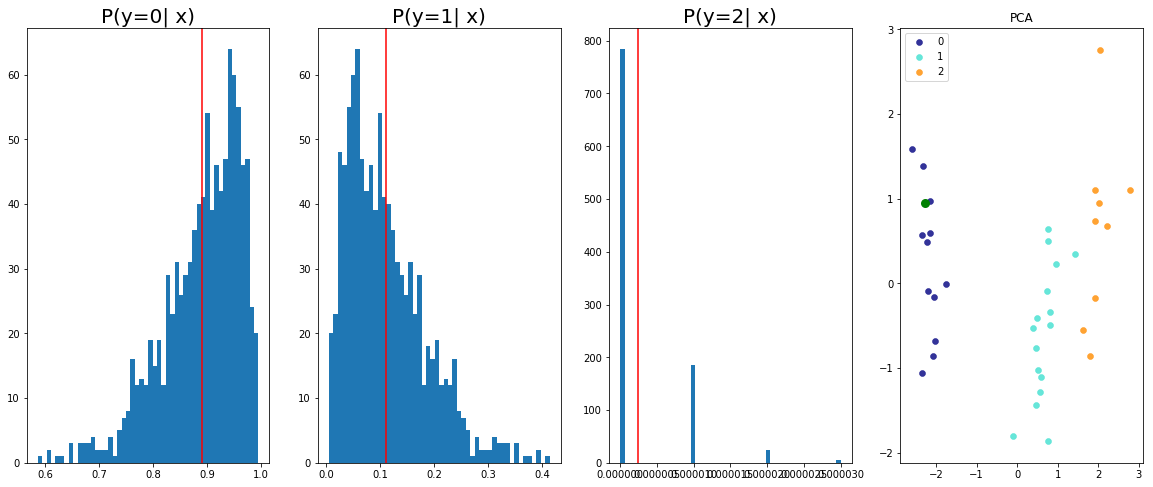

True -> 2
Predicted -> 2
STDS: 0.03955630585551262


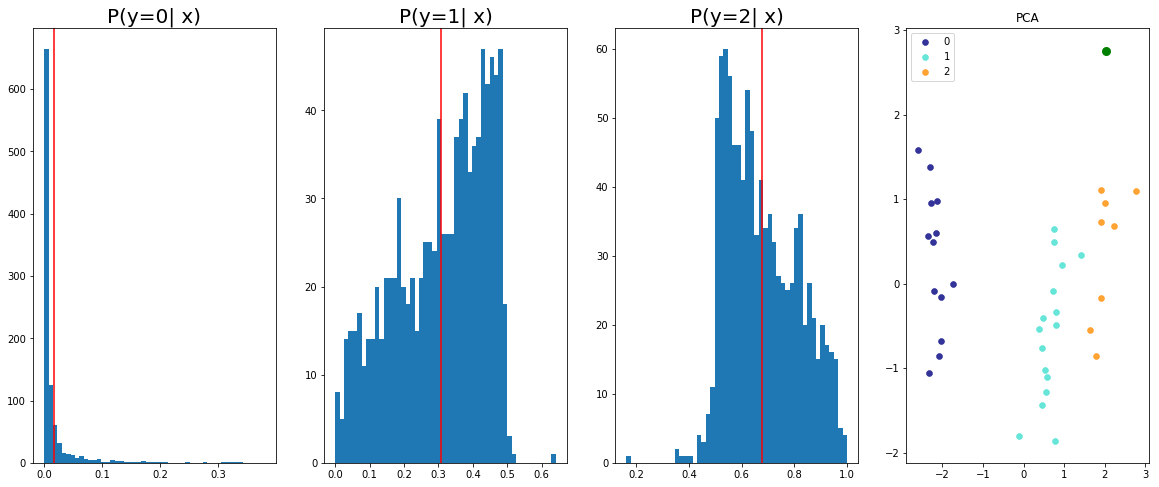

True -> 1
Predicted -> 1
STDS: 0.10696055740118027


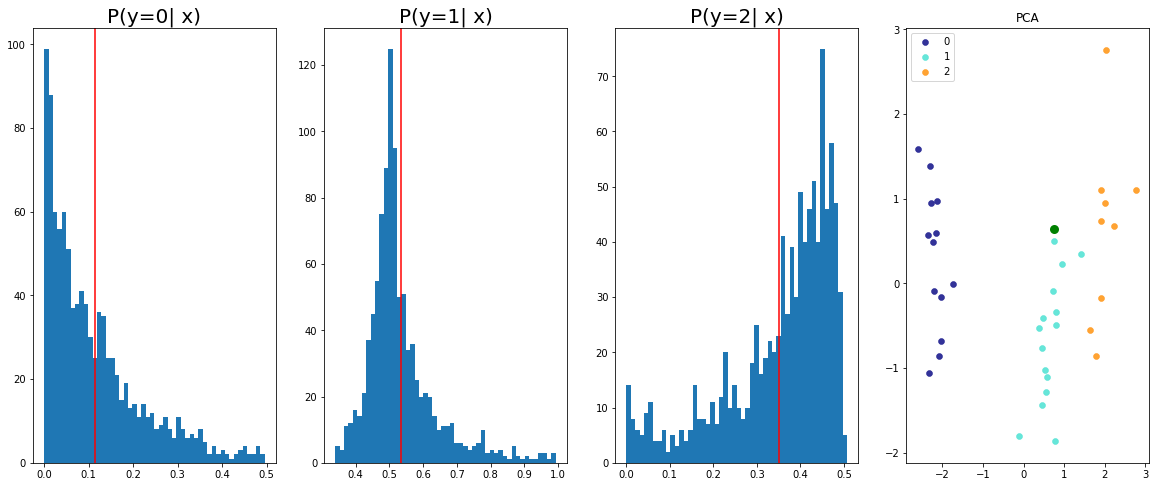

True -> 2
Predicted -> 2
STDS: 0.07213427871465683


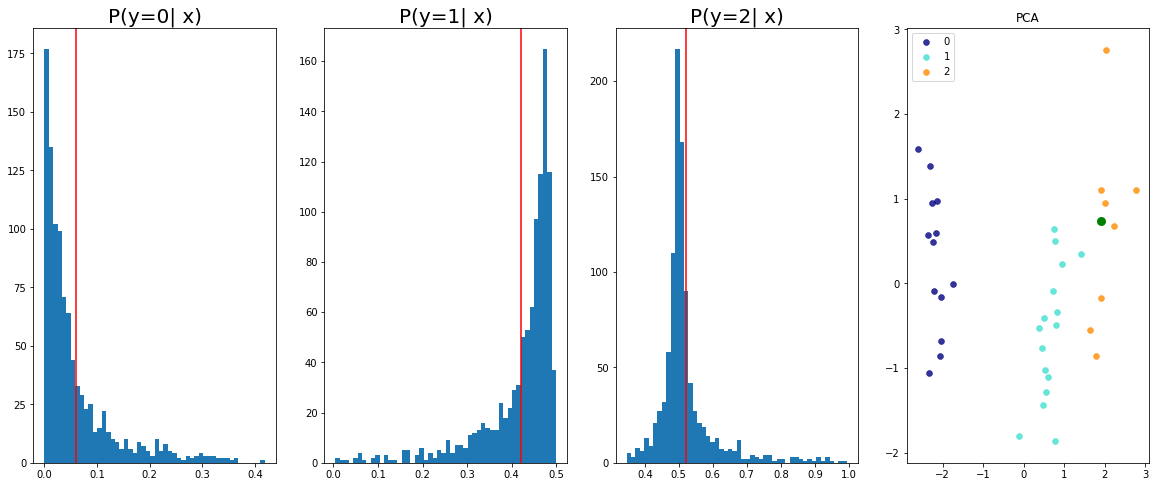

True -> 0
Predicted -> 0
STDS: 0.07141809910535812


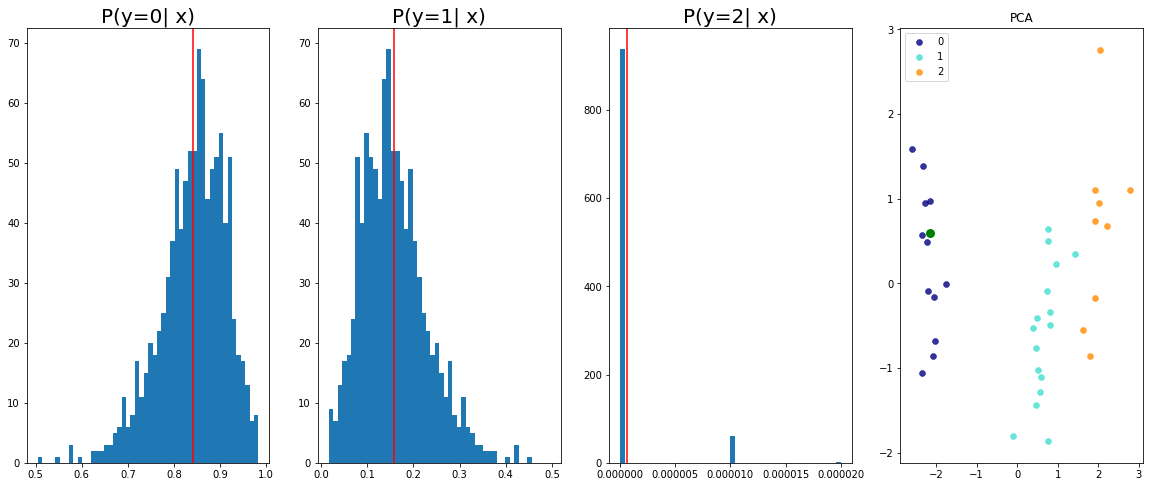

True -> 0
Predicted -> 0
STDS: 0.09987819194793701


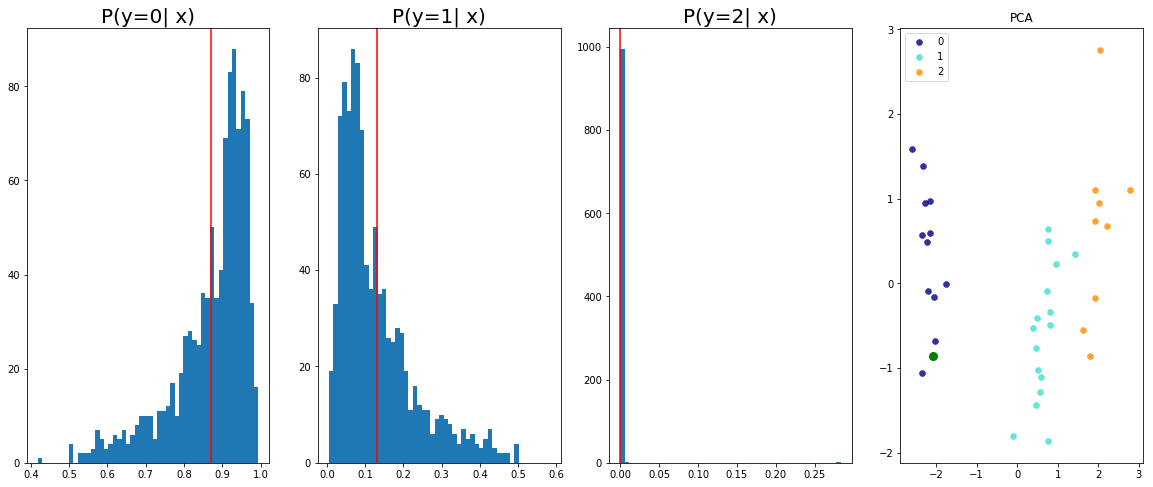

True -> 2
Predicted -> 2
STDS: 0.05386827886104584


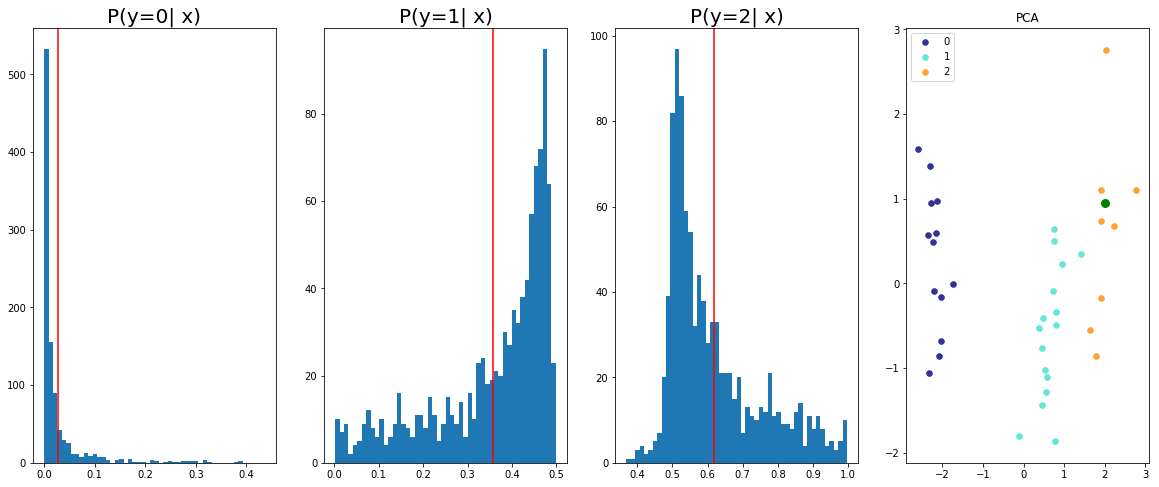

True -> 1
Predicted -> 1
STDS: 0.08846960216760635


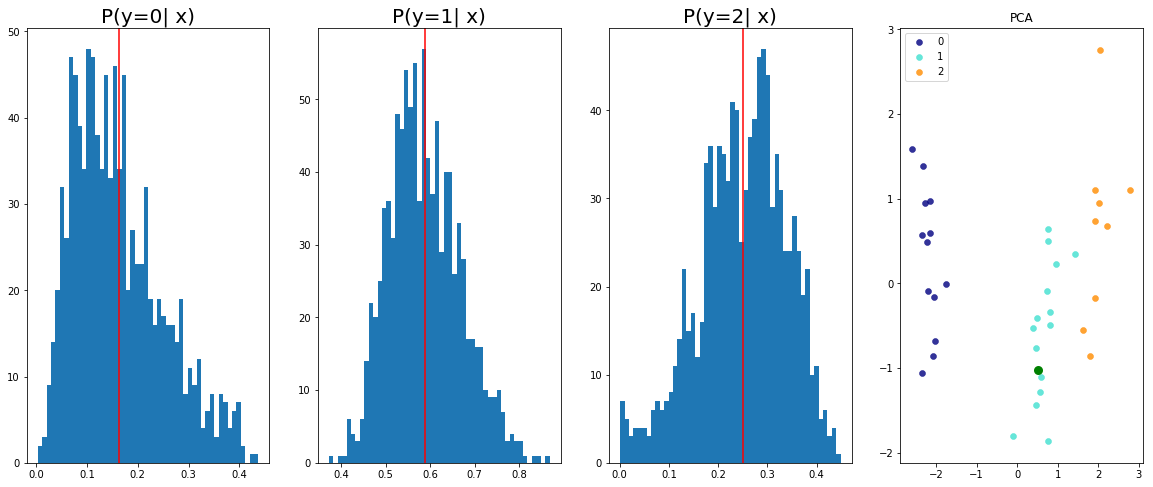

True -> 0
Predicted -> 0
STDS: 0.07483415305614471


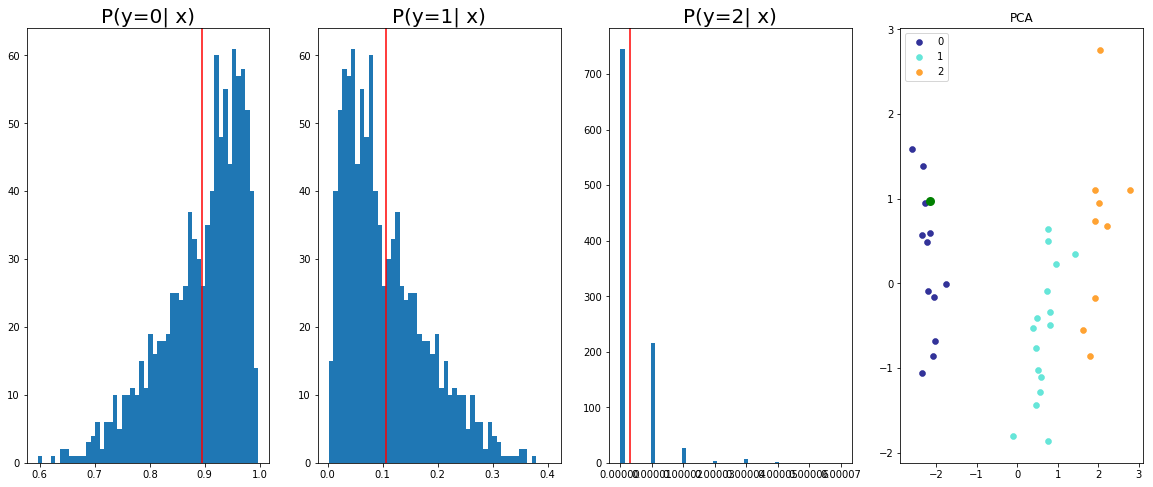

True -> 2
Predicted -> 2
STDS: 0.034651387482881546


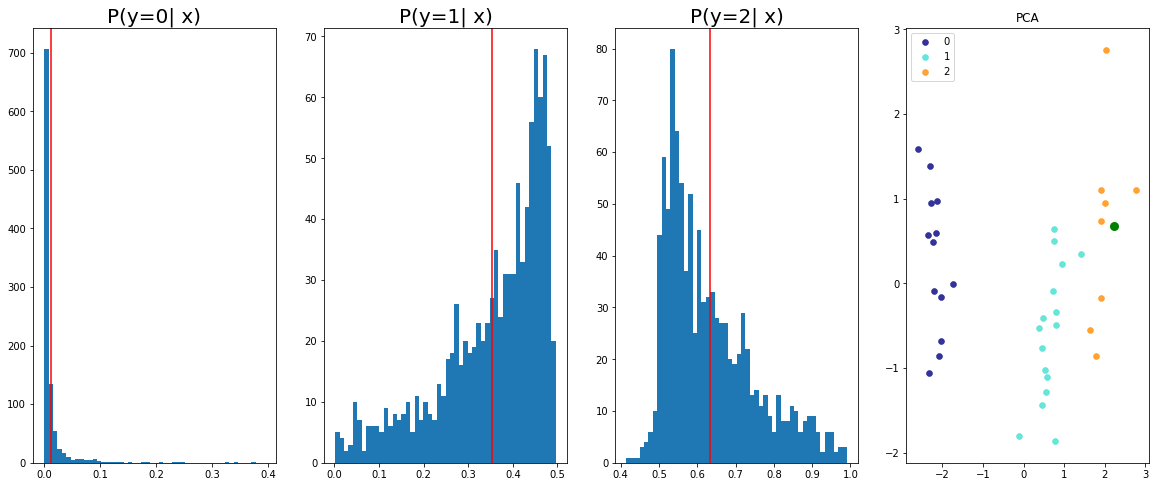

True -> 1
Predicted -> 1
STDS: 0.1401941478252411


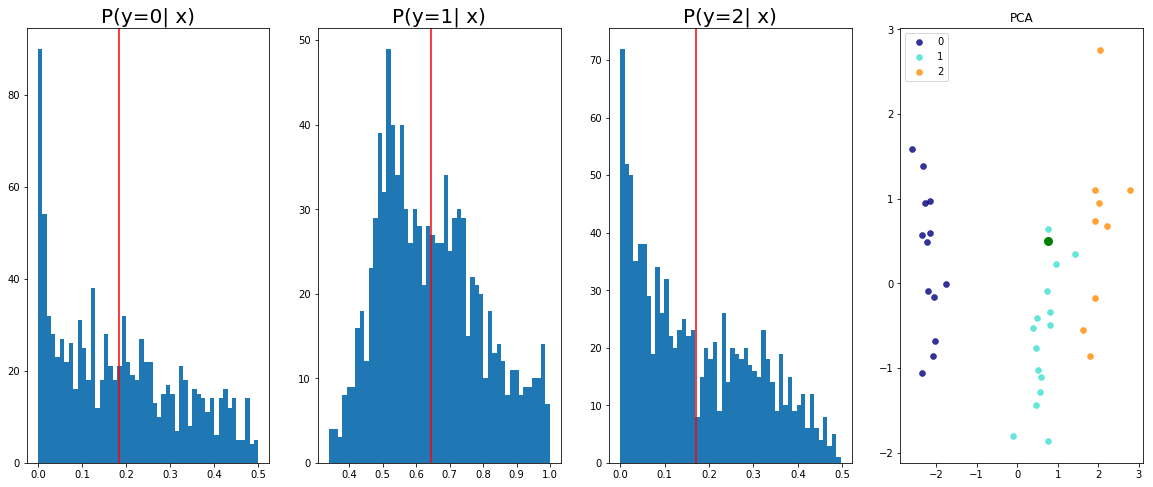

True -> 1
Predicted -> 1
STDS: 0.06242700666189194


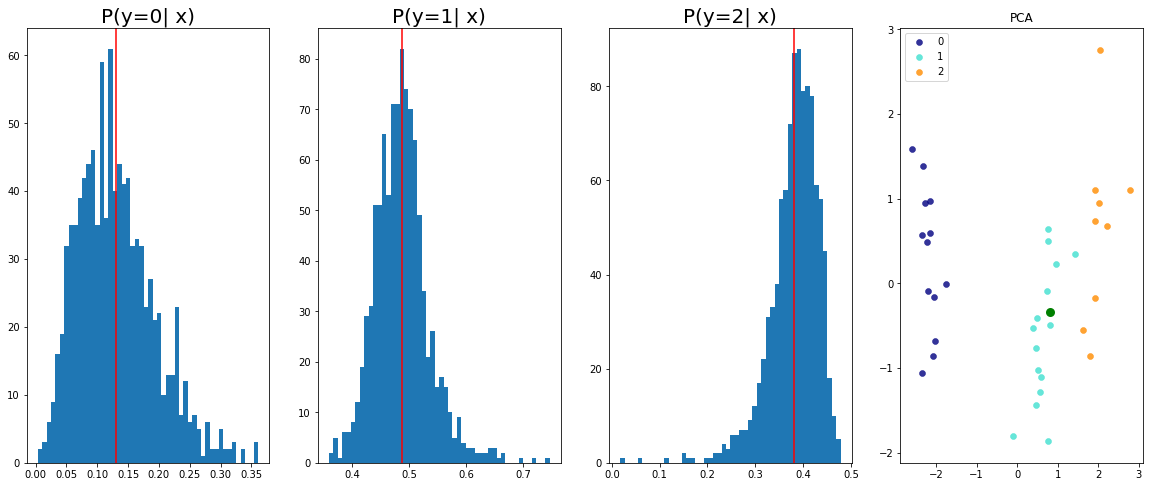

True -> 0
Predicted -> 0
STDS: 0.10543514788150787


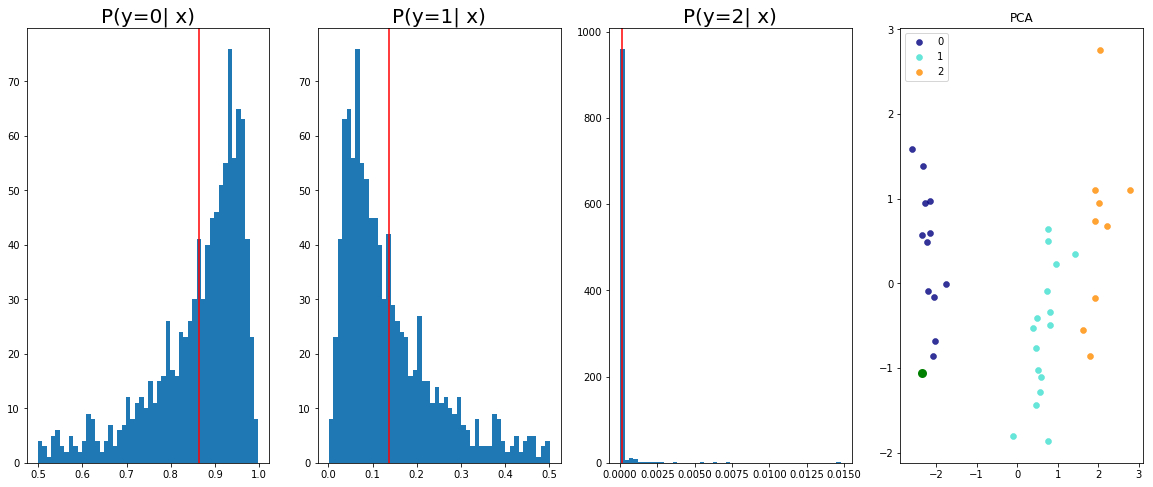

True -> 1
Predicted -> 1
STDS: 0.09375502914190292


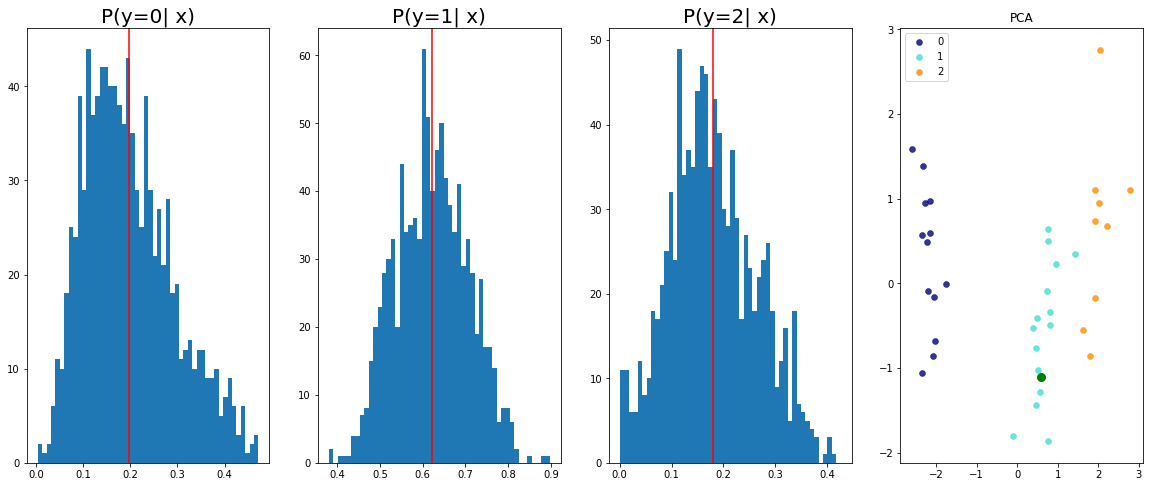

True -> 1
Predicted -> 1
STDS: 0.07412047684192657


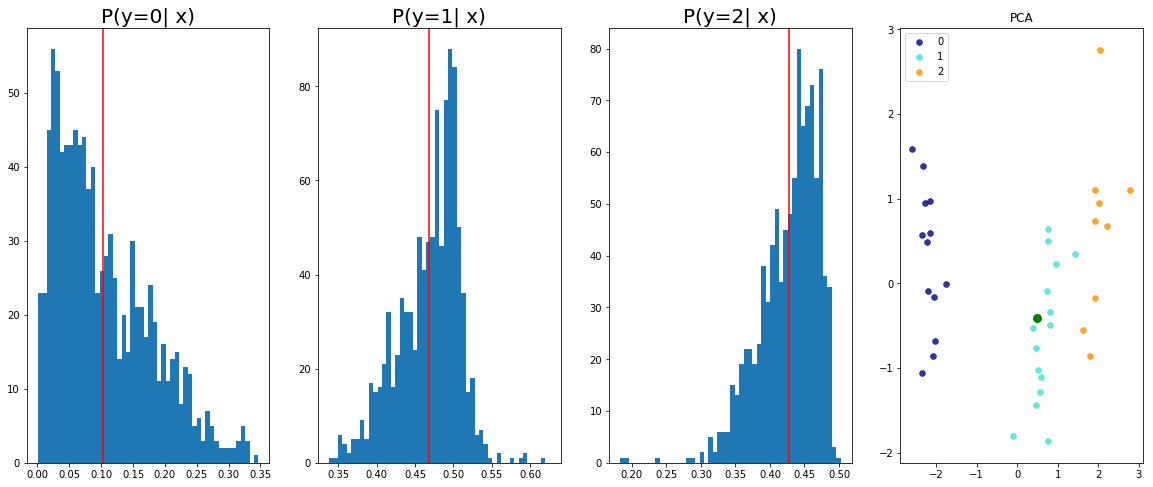

True -> 0
Predicted -> 0
STDS: 0.06351975351572037


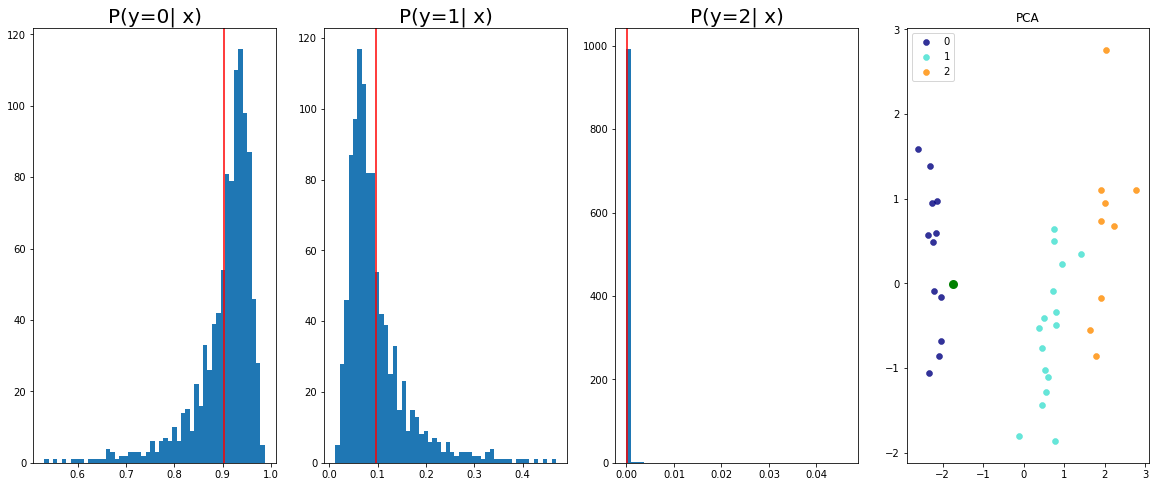

True -> 0
Predicted -> 0
STDS: 0.09610296785831451


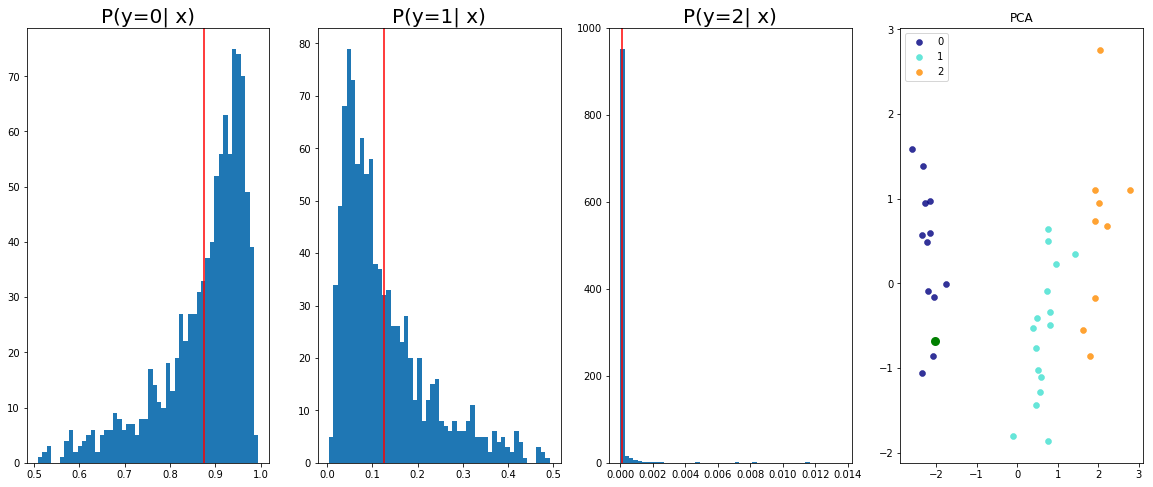

True -> 1
Predicted -> 1
STDS: 0.08926736563444138


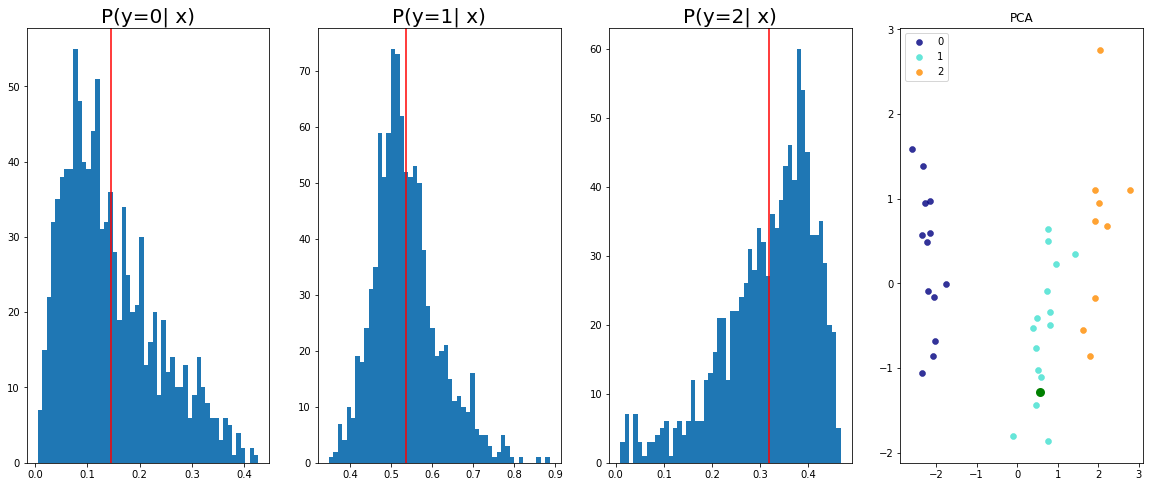

True -> 1
Predicted -> 1
STDS: 0.08073766529560089


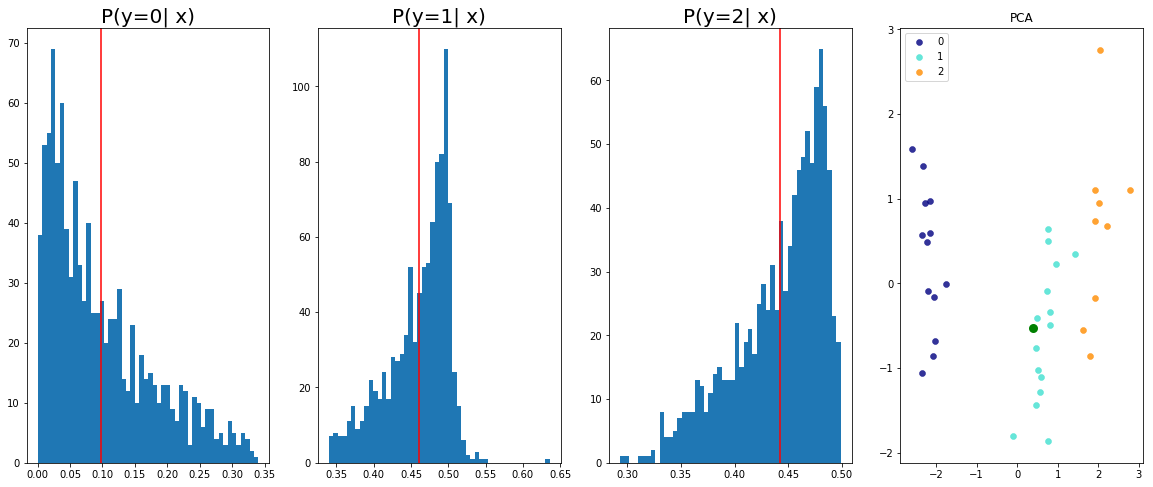

True -> 1
Predicted -> 1
STDS: 0.07359510660171509


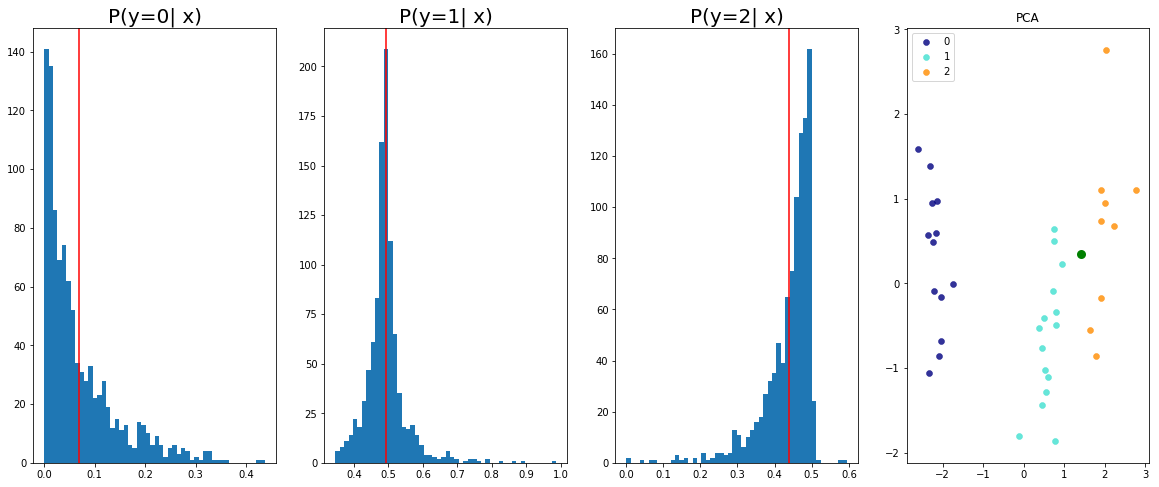

True -> 0
Predicted -> 0
STDS: 0.0665154904127121


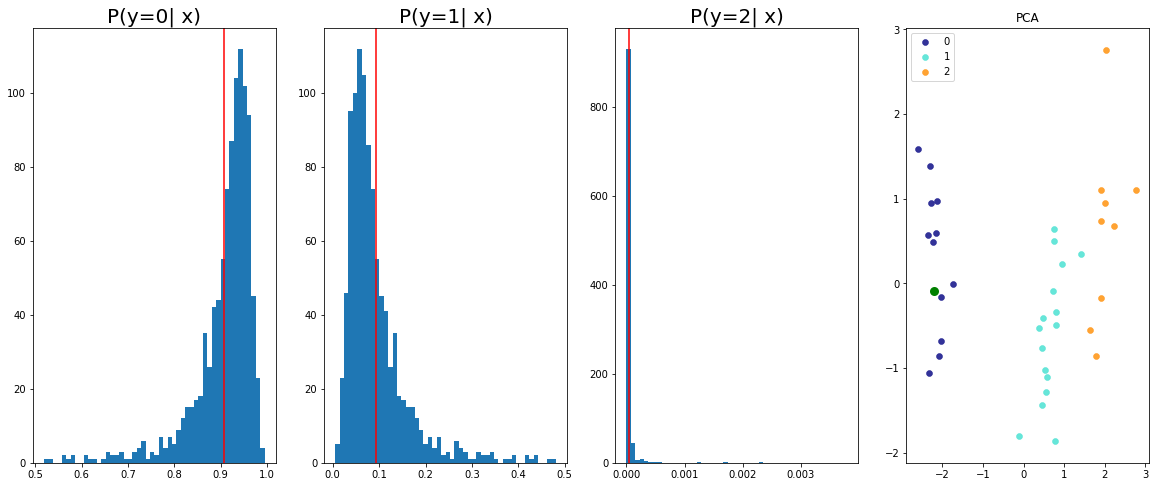

True -> 2
Predicted -> 2
STDS: 0.02820996753871441


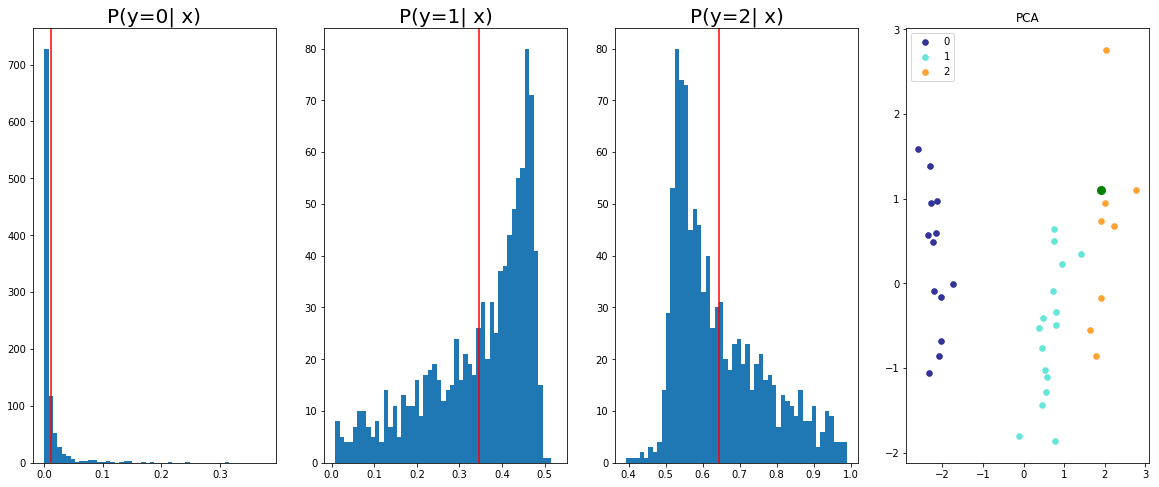

True -> 1
Predicted -> 1
STDS: 0.08391118049621582


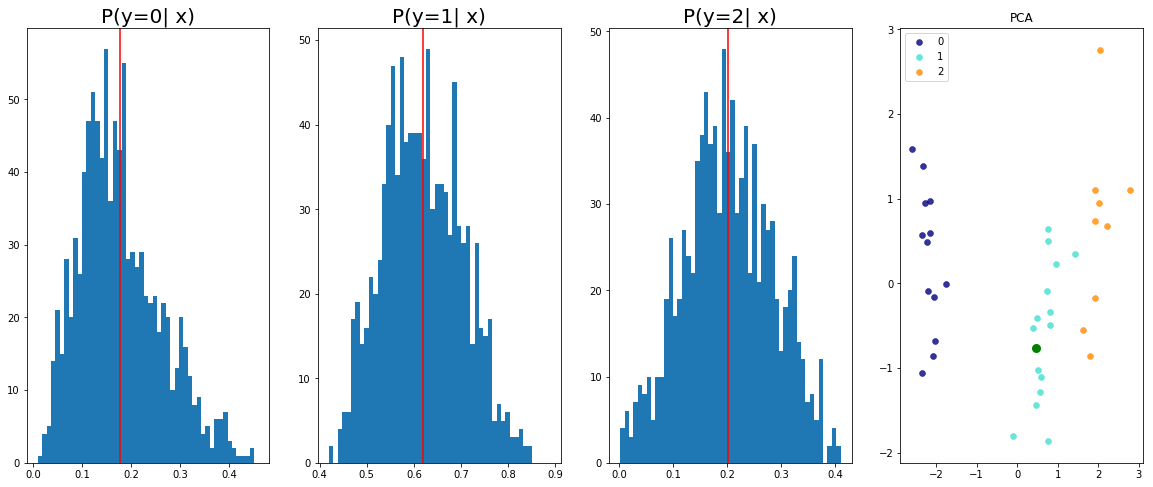

True -> 0
Predicted -> 0
STDS: 0.0746115893125534


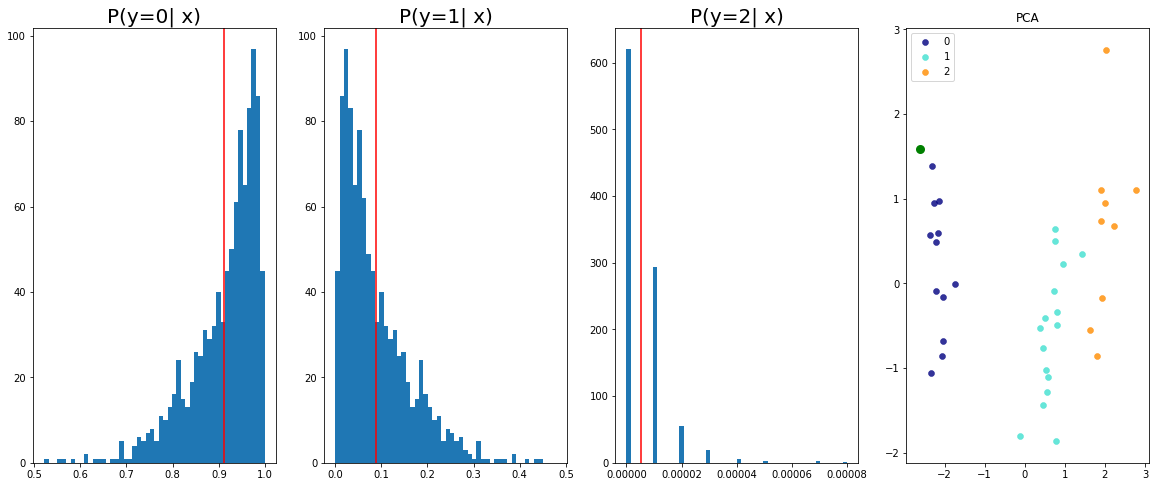

True -> 0
Predicted -> 0
STDS: 0.07384000718593597


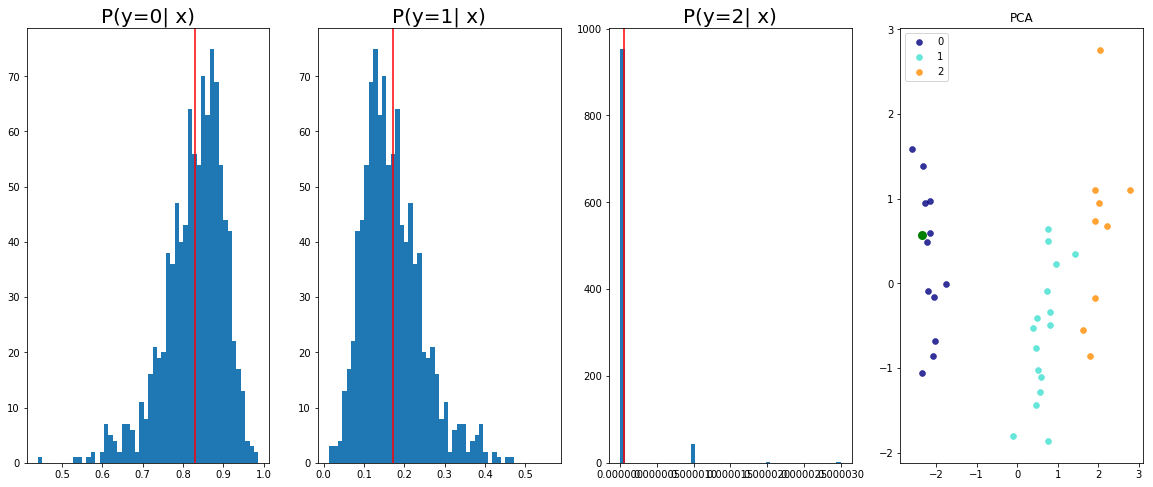

True -> 1
Predicted -> 1
STDS: 0.07461754232645035


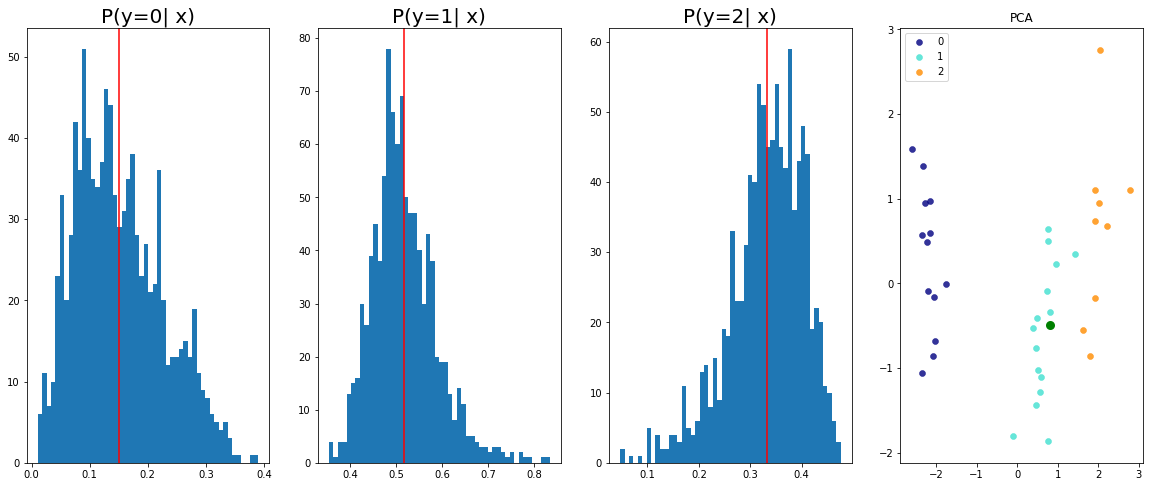

True -> 2
Predicted -> 2
STDS: 0.0608082041144371


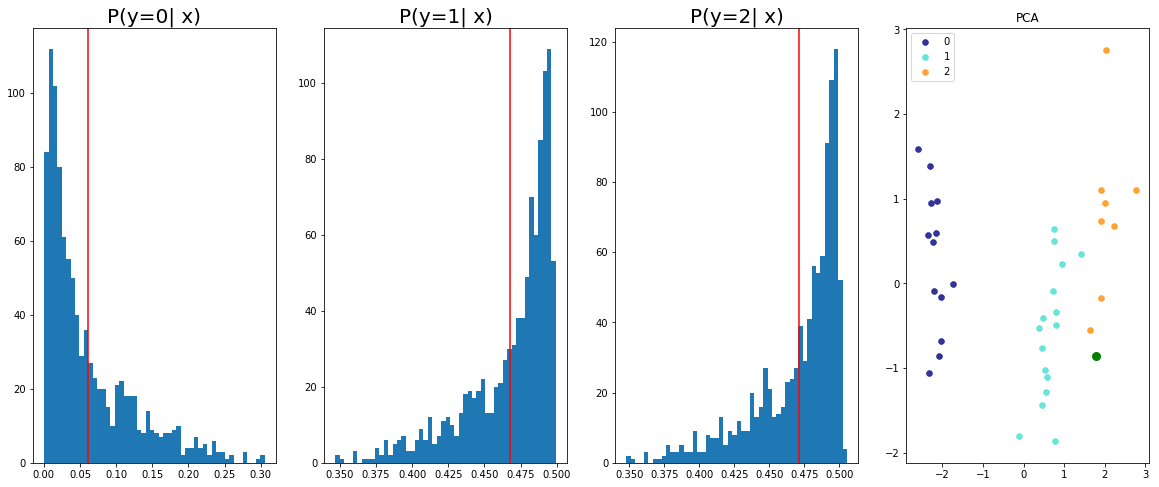

True -> 1
Predicted -> 1
STDS: 0.09363450109958649


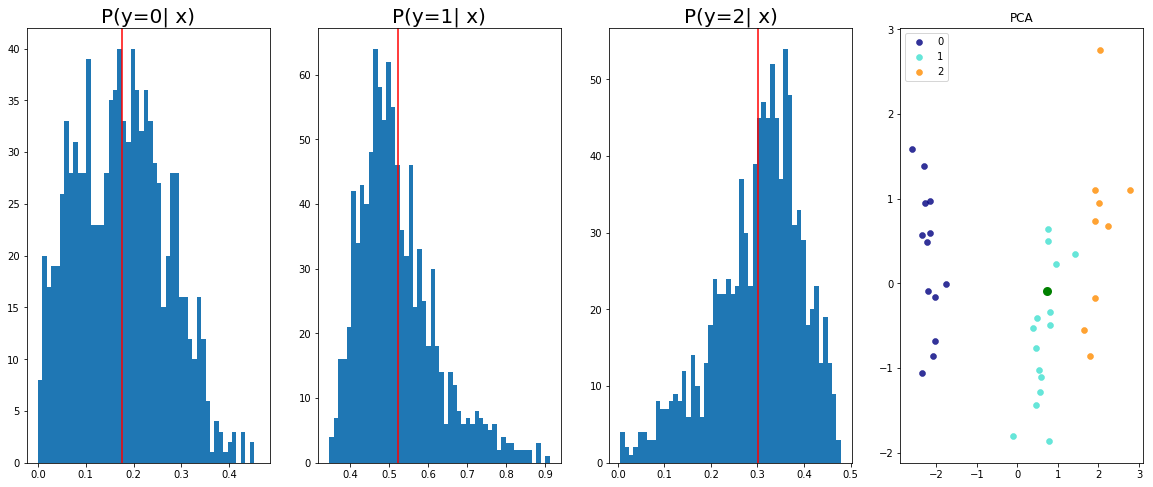

True -> 2
Predicted -> 2
STDS: 0.03468935191631317


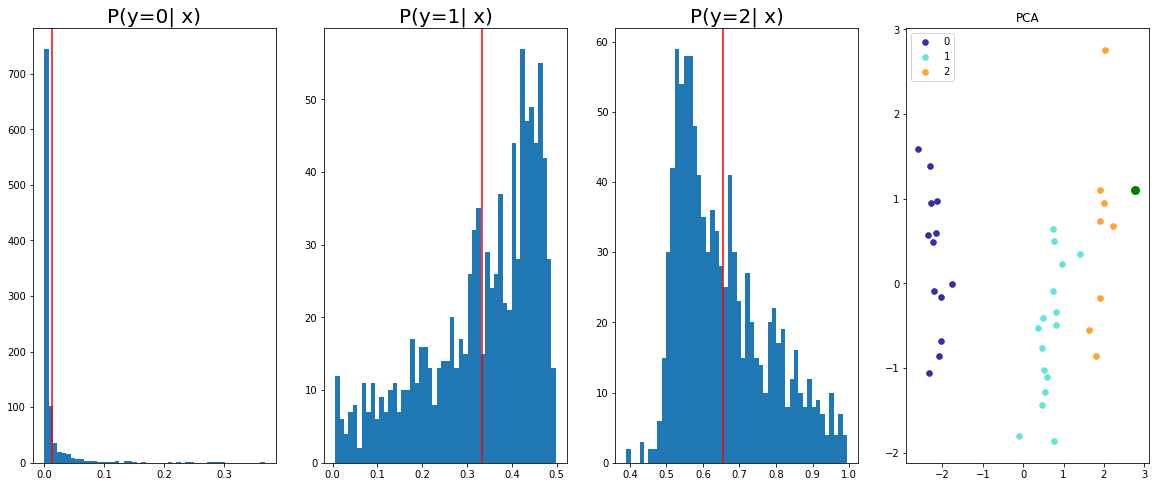

True -> 1
Predicted -> 1
STDS: 0.11047064512968063


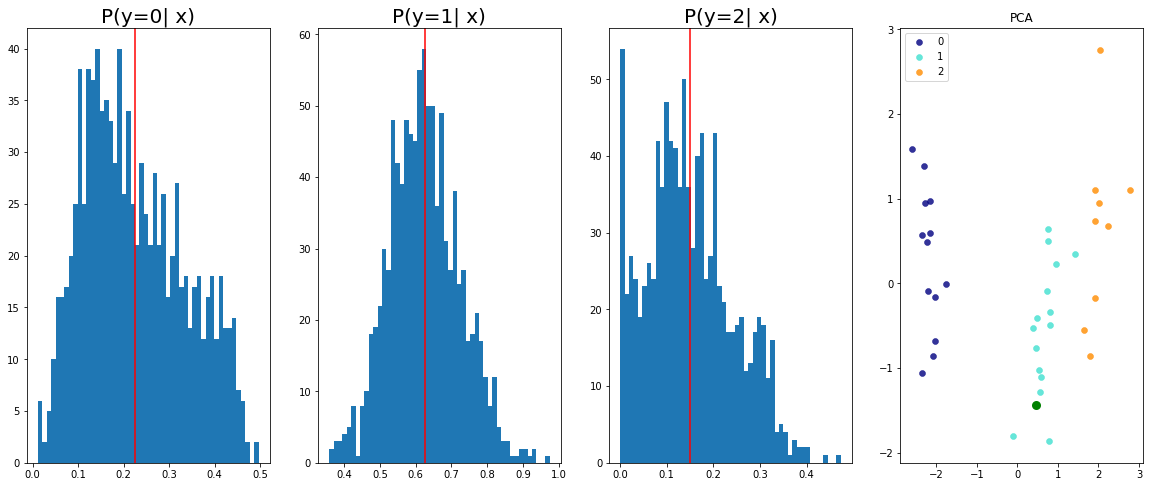

True -> 2
Predicted -> 2
STDS: 0.09543460607528687


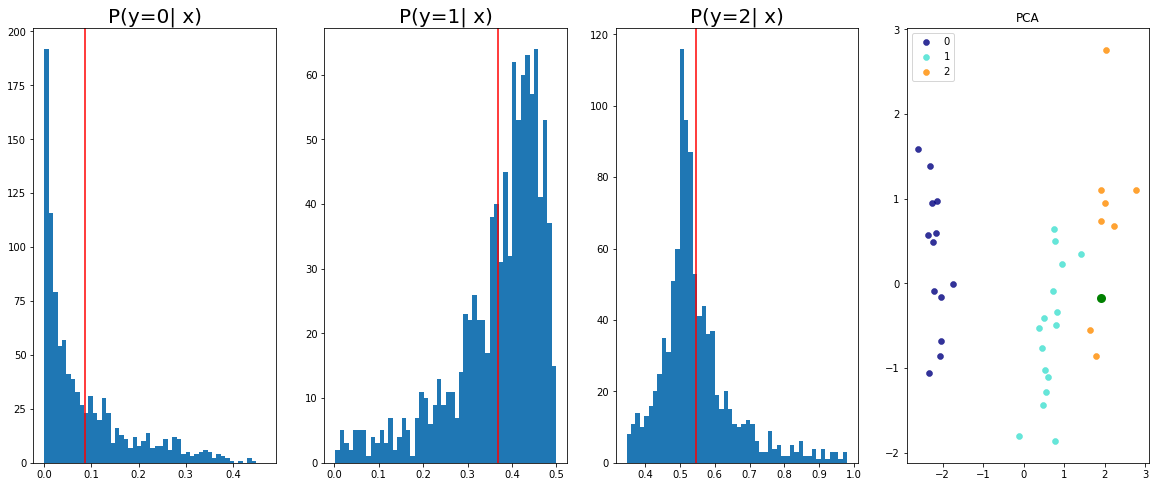

True -> 2
Predicted -> 2
STDS: 0.09992211312055588


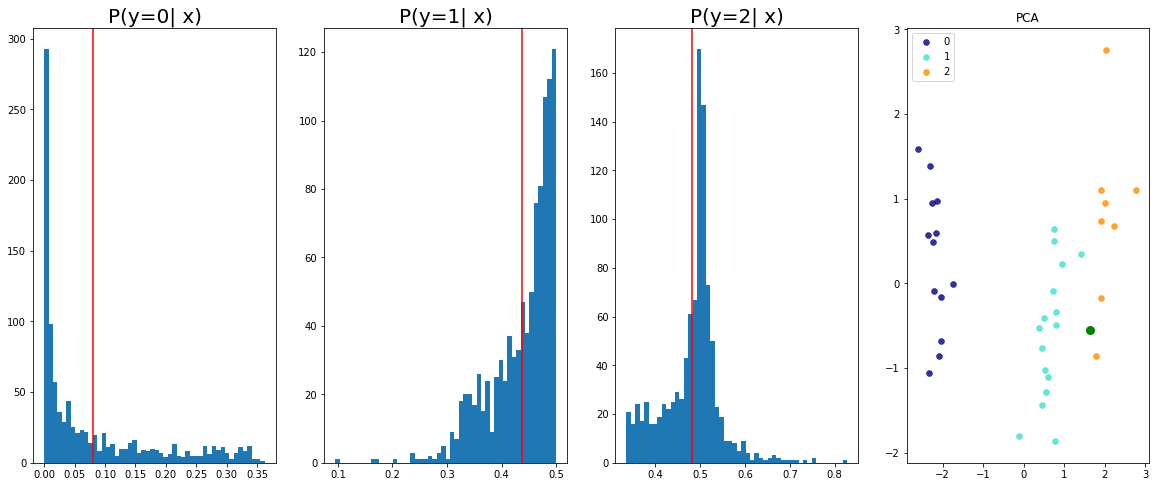

True -> 0
Predicted -> 0
STDS: 0.08229018747806549


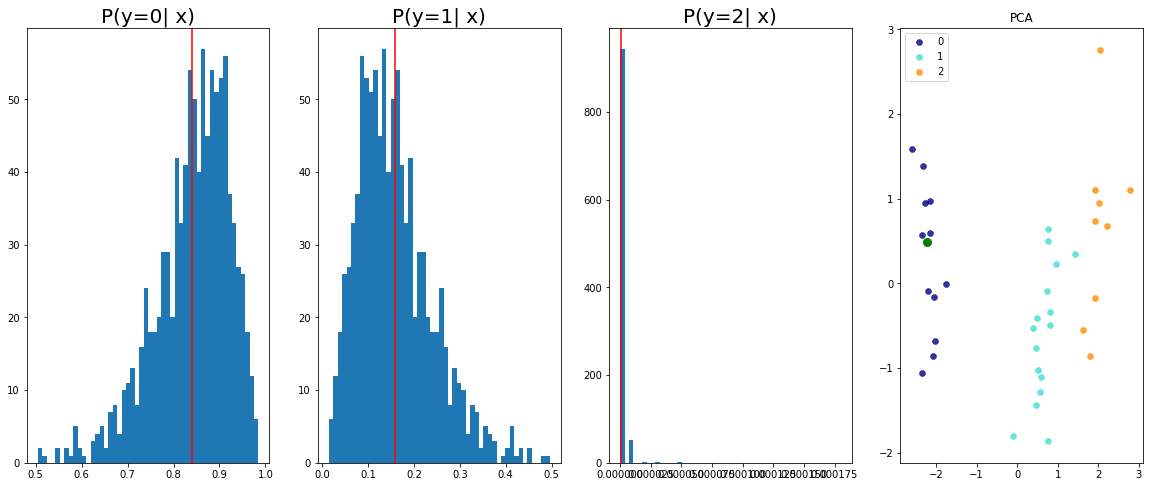

True -> 1
Predicted -> 1
STDS: 0.10388845205307007


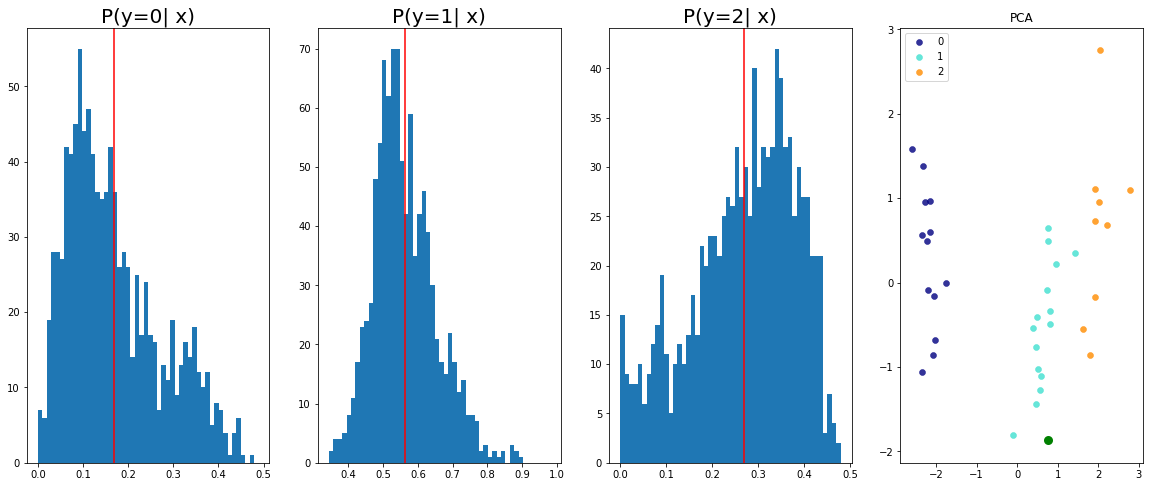

True -> 0
Predicted -> 0
STDS: 0.07828448712825775


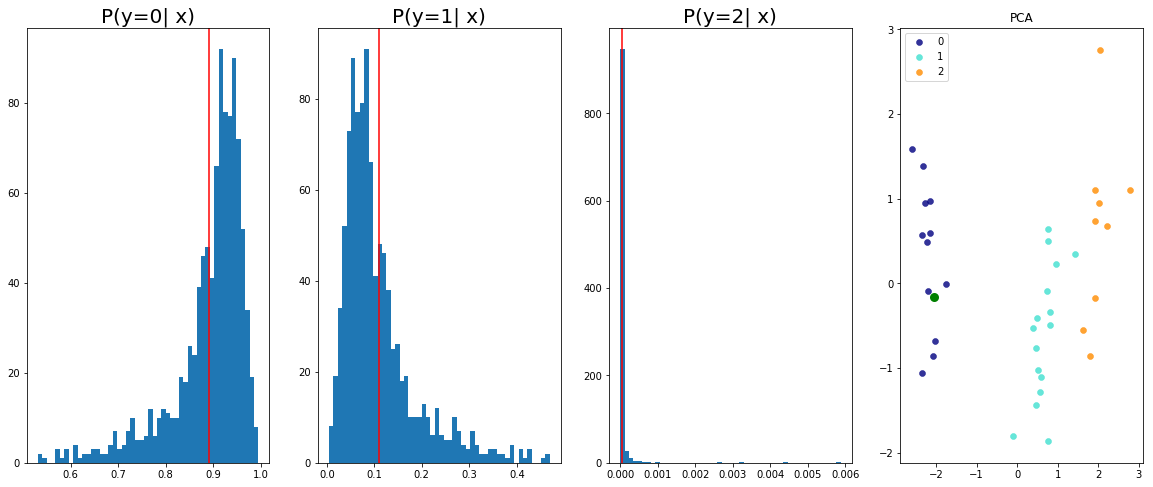

In [29]:
for i in range(len(estimator)):
    plot_prediction_probabilities(estimator=estimator, index_to_plot=i)

In [30]:
# estimator.output_distribution

In [14]:
data_nas = process_reports_nas(reports)
data_nas['version'] = 'Grid Search BackProp'
data_nas

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,duration,end_condition,n_parameters,n_nodes,n_connections,f1,accuracy,version
0,nas_v1,08d6a5a2-9092-4947-a5a0-65321cc6b4ed,0.75,0.0,True,0.000001,0:00:00.000016,normal,198,15,84,0.932597,93.263158,Grid Search BackProp
0,nas_v1,2b591dde-a40c-4b89-b87a-8b1405e5874f,0.75,0.0,True,0.000001,0:00:00.000014,normal,942,42,429,0.914497,91.473684,Grid Search BackProp
0,nas_v1,6c92d9b1-79bc-40f2-800e-1dcbc355376f,0.75,0.0,True,0.000001,0:00:00.000029,normal,146,13,60,0.934205,93.421053,Grid Search BackProp
0,nas_v1,d22e3a31-33b4-426f-a230-58b49b7f2dd2,0.75,0.0,True,0.000001,0:00:00.000015,normal,198,15,84,0.940826,94.078947,Grid Search BackProp


In [41]:
data = pd.concat([data_ne, data_nas])
data.dropna(axis=1, inplace=True)
data.drop(columns=['correlation_id', 'execution_id', ], inplace=True)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,accuracy,beta,duration,end_condition,f1,is_bayesian,n_connections,n_nodes,n_parameters,noise,train_percentage,version
0,95.410526,0.000001,0:04:57.346098,normal,0.954199,True,32,15,94,0.0,0.75,Bayesian Neuro-Evolution
1,86.792105,0.000001,0:11:48.839582,normal,0.868889,True,57,28,170,0.0,0.75,Bayesian Neuro-Evolution
2,93.563158,0.000001,0:08:07.872646,normal,0.936056,True,46,22,136,0.0,0.75,Bayesian Neuro-Evolution
3,96.981579,0.000001,0:04:09.267670,normal,0.969852,True,35,15,100,0.0,0.75,Bayesian Neuro-Evolution
4,94.713158,0.000001,0:23:22.603487,normal,0.947125,True,64,31,190,0.0,0.75,Bayesian Neuro-Evolution
0,93.263158,0.000001,0:00:00.000016,normal,0.932597,True,84,15,198,0.0,0.75,Grid Search BackProp
0,91.473684,0.000001,0:00:00.000014,normal,0.914497,True,429,42,942,0.0,0.75,Grid Search BackProp
0,93.421053,0.000001,0:00:00.000029,normal,0.934205,True,60,13,146,0.0,0.75,Grid Search BackProp
0,94.078947,0.000001,0:00:00.000015,normal,0.940826,True,84,15,198,0.0,0.75,Grid Search BackProp


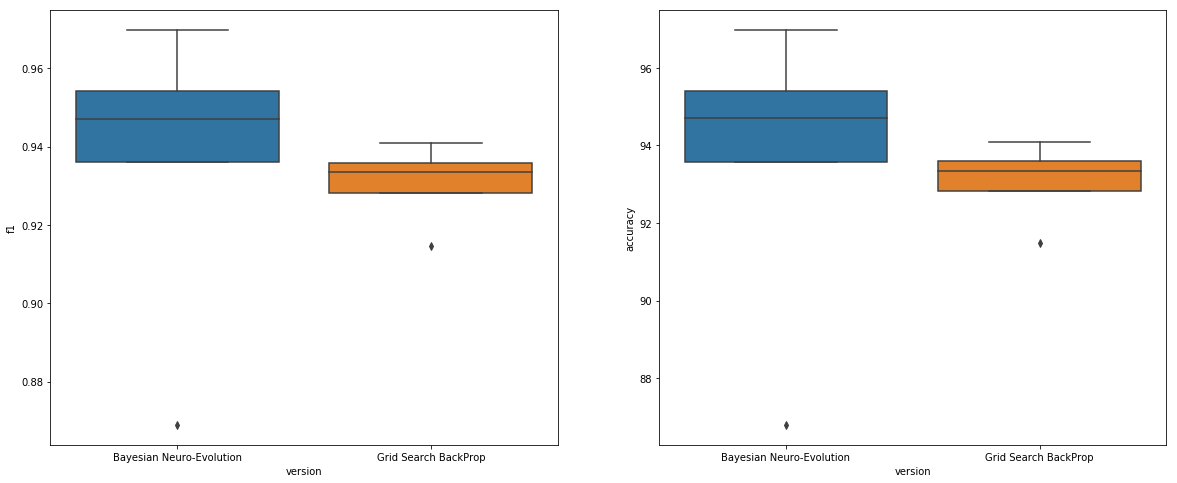

In [45]:
# sns.boxplot(data=data, y='accuracy', x='version')

_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='f1', ax=ax1)
sns.boxplot(data=data, x='version', y='accuracy', ax=ax2)
# ax1.set_ylim([0, 1])
# ax2.set_ylim([0, 100])

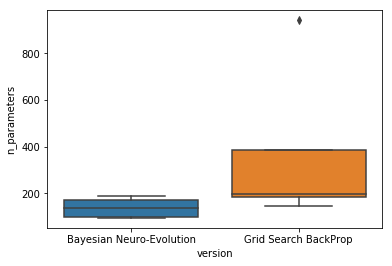

In [47]:
sns.boxplot(data=data, y='n_parameters', x='version')

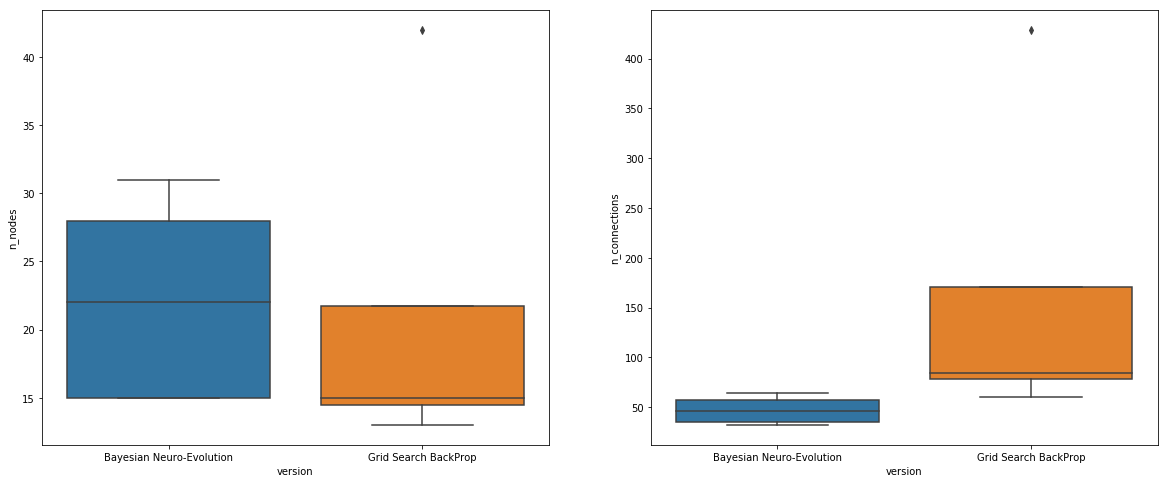

In [46]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='n_nodes', ax=ax1)
sns.boxplot(data=data, x='version', y='n_connections', ax=ax2)

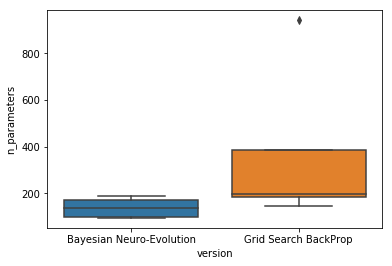

In [43]:
sns.boxplot(data=data, y='n_parameters', x='version')